In [1]:
import numpy as np
import pandas as pd

import cv2
import io
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import kmeans_plusplus
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def fractal_dimension(Z, threshold=50):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [3]:
A1 = [cv2.threshold(cv2.cvtColor(cv2.imread('A1-1.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1], 
      cv2.threshold(cv2.cvtColor(cv2.imread('A1-2.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('A1-3.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('A1-4.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1]]

A2 = [cv2.threshold(cv2.cvtColor(cv2.imread('A2-1.png'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1], 
      cv2.threshold(cv2.cvtColor(cv2.imread('A2-2.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('A2-3.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1]]

B1 = [cv2.threshold(cv2.cvtColor(cv2.imread('B1-1.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1], 
      cv2.threshold(cv2.cvtColor(cv2.imread('B1-2.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('B1-3.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1]]

B2 = [cv2.threshold(cv2.cvtColor(cv2.imread('B2-0.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('B2-1.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('B2-2.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('B2-3.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('B2-4.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1]]

C1 = [cv2.threshold(cv2.cvtColor(cv2.imread('C1-1.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1], 
      cv2.threshold(cv2.cvtColor(cv2.imread('C1-2.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('C1-3.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('C1-4.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1]]

D1 = [cv2.threshold(cv2.cvtColor(cv2.imread('D1-1.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1], 
      cv2.threshold(cv2.cvtColor(cv2.imread('D1-2.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('D1-3.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1],
      cv2.threshold(cv2.cvtColor(cv2.imread('D1-4.PNG'), cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)[1]]

In [4]:
x_names = ["A1", "A2", "B1", "B2", "C1", "D1"]

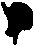

In [5]:
img = D1[1]
byteImgIO = io.BytesIO()
byteImg = Image.fromarray(img)
byteImg = byteImg.convert("L")
byteImg.save(byteImgIO, "PNG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)

# Площадь минимальной выпуклой оболочки - МВО (minimal convex hull - MCH)

In [6]:
def find_contour(gray):
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY_INV)[1]
    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = max(cnts, key=cv2.contourArea)
    cnts = np.asarray(cnts)
    cnts = cnts.reshape(-1,2)
    return cnts

In [7]:
def rotate(A,B,C):
    return (B[0]-A[0])*(C[1]-B[1])-(B[1]-A[1])*(C[0]-B[0])

#Алгоритм Джарвиса
def jarvismarch(A):
    n = len(A)
    P = list(range(n))
    # start point
    for i in range(1,n):
        if A[P[i]][0]<A[P[0]][0]: 
            P[i], P[0] = P[0], P[i]  
    H = [P[0]]
    del P[0]
    P.append(H[0])
    while True:
        right = 0
        for i in range(1,len(P)):
            if rotate(A[H[-1]],A[P[right]],A[P[i]])<0:
                right = i
        if P[right]==H[0]: 
            break
        else:
            H.append(P[right])
            del P[right]
    return [A[i] for i in H] 

In [8]:
def square_polygon(points):
    n = len(points)
    sum = points[n-1][0] * points[0][1] - points[n-1][1] * points[0][0]
    for i in range(0, n-1):
        sum = sum + (points[i][0] * points[i + 1][1] - points[i][1] * points[i + 1][0])
    return abs(sum)/2

In [9]:
def mch(Cat):
    cat = []
    for c in Cat:
        cnts = find_contour(c)
        mvp = jarvismarch(cnts)
        cat.append(square_polygon(mvp))
    return cat

In [10]:
a1_mch = mch(A1)
a2_mch = mch(A2)
b1_mch = mch(B1)
b2_mch = mch(B2)
c1_mch = mch(C1)
d1_mch = mch(D1)

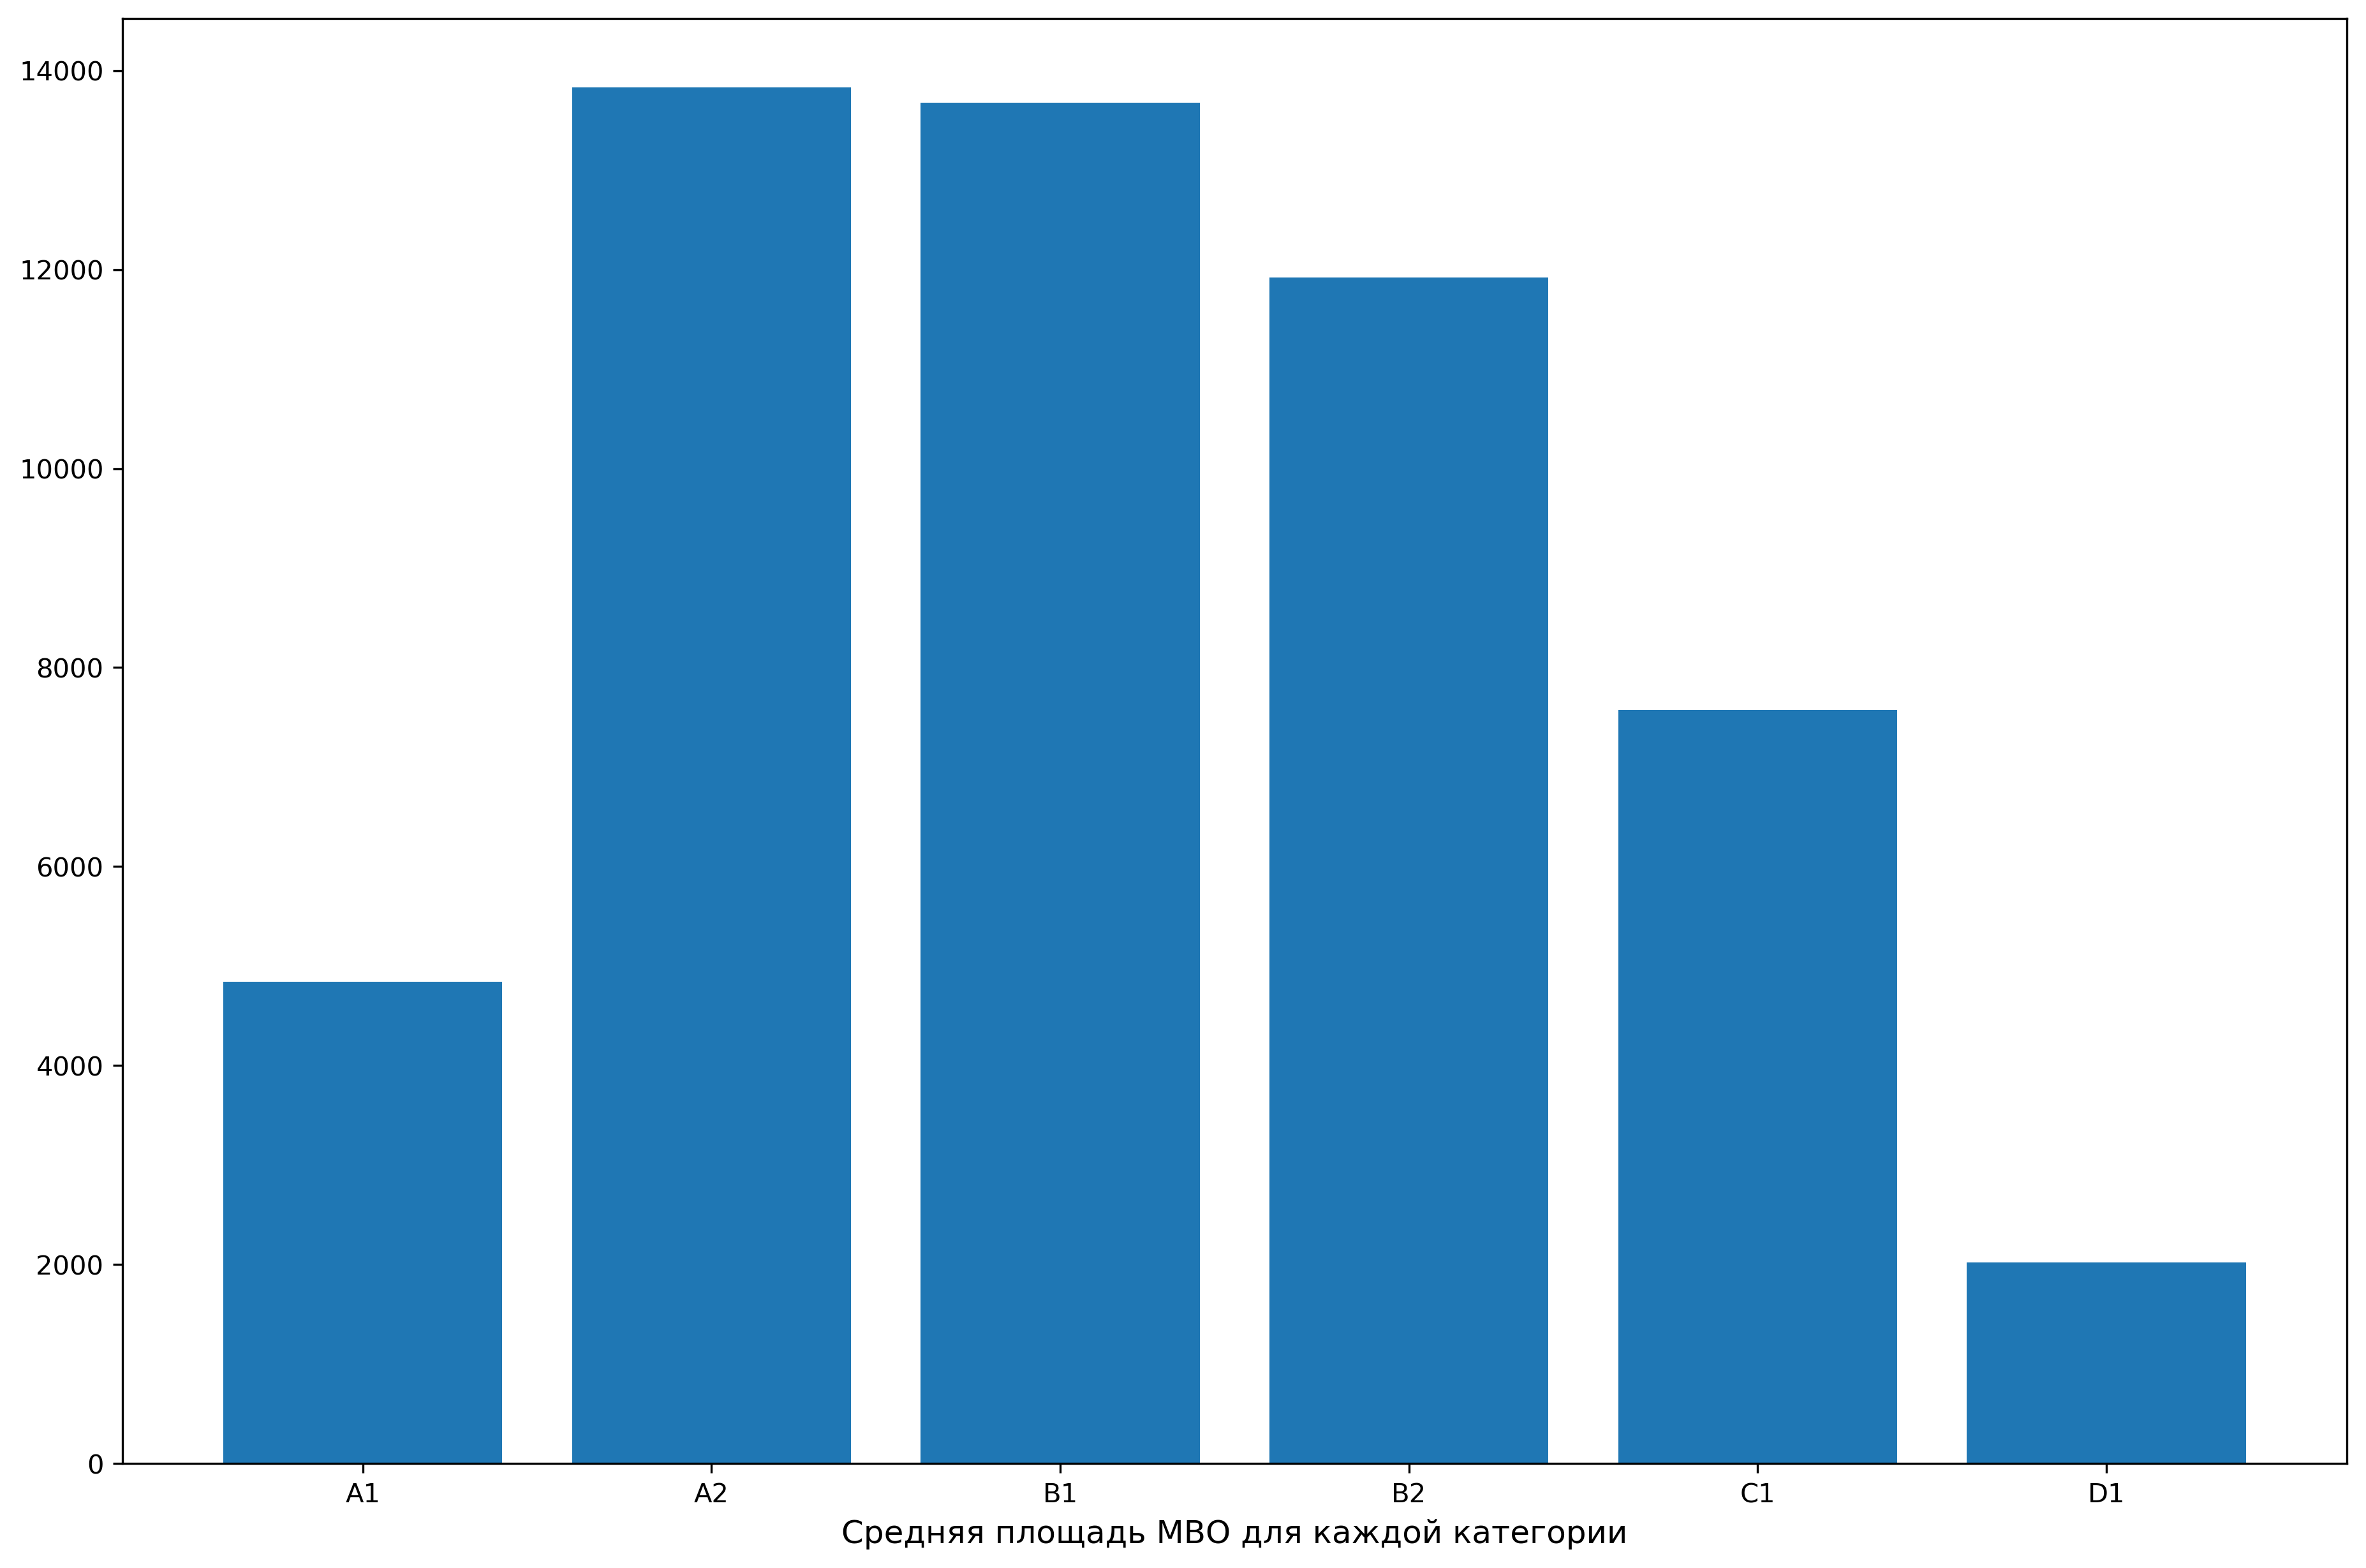

In [11]:
y_mch = [np.mean(a1_mch),np.mean(a2_mch), np.mean(b1_mch), np.mean(b2_mch), np.mean(c1_mch), np.mean(d1_mch)]

ig, ax = plt.subplots(figsize=(15, 10), dpi=300)
plt.bar(x_names, y_mch) 
# Custom Axis title
plt.xlabel('Средняя площадь МВО для каждой категории', fontsize='12', horizontalalignment='center')
# Show the graph
plt.show()

# Отношение черных пикселей к МВО

In [12]:
# def black(Cat):
#     cat = []
#     for c in Cat:
#         contours,_ = cv2.findContours(c, 1, 2)
#         cnts = max(contours, key=cv2.contourArea)
#         cat.append(cv2.contourArea(cnts))
#     return cat

def black(Cat):
    cat = []
    for c in Cat:
        cnts = find_contour(c)
        mvp = jarvismarch(cnts)
        cat.append((c!=255).sum()/square_polygon(mvp))
    return cat

In [13]:
a1_black = black(A1)
a2_black = black(A2)
b1_black = black(B1)
b2_black = black(B2)
c1_black = black(C1)
d1_black = black(D1)

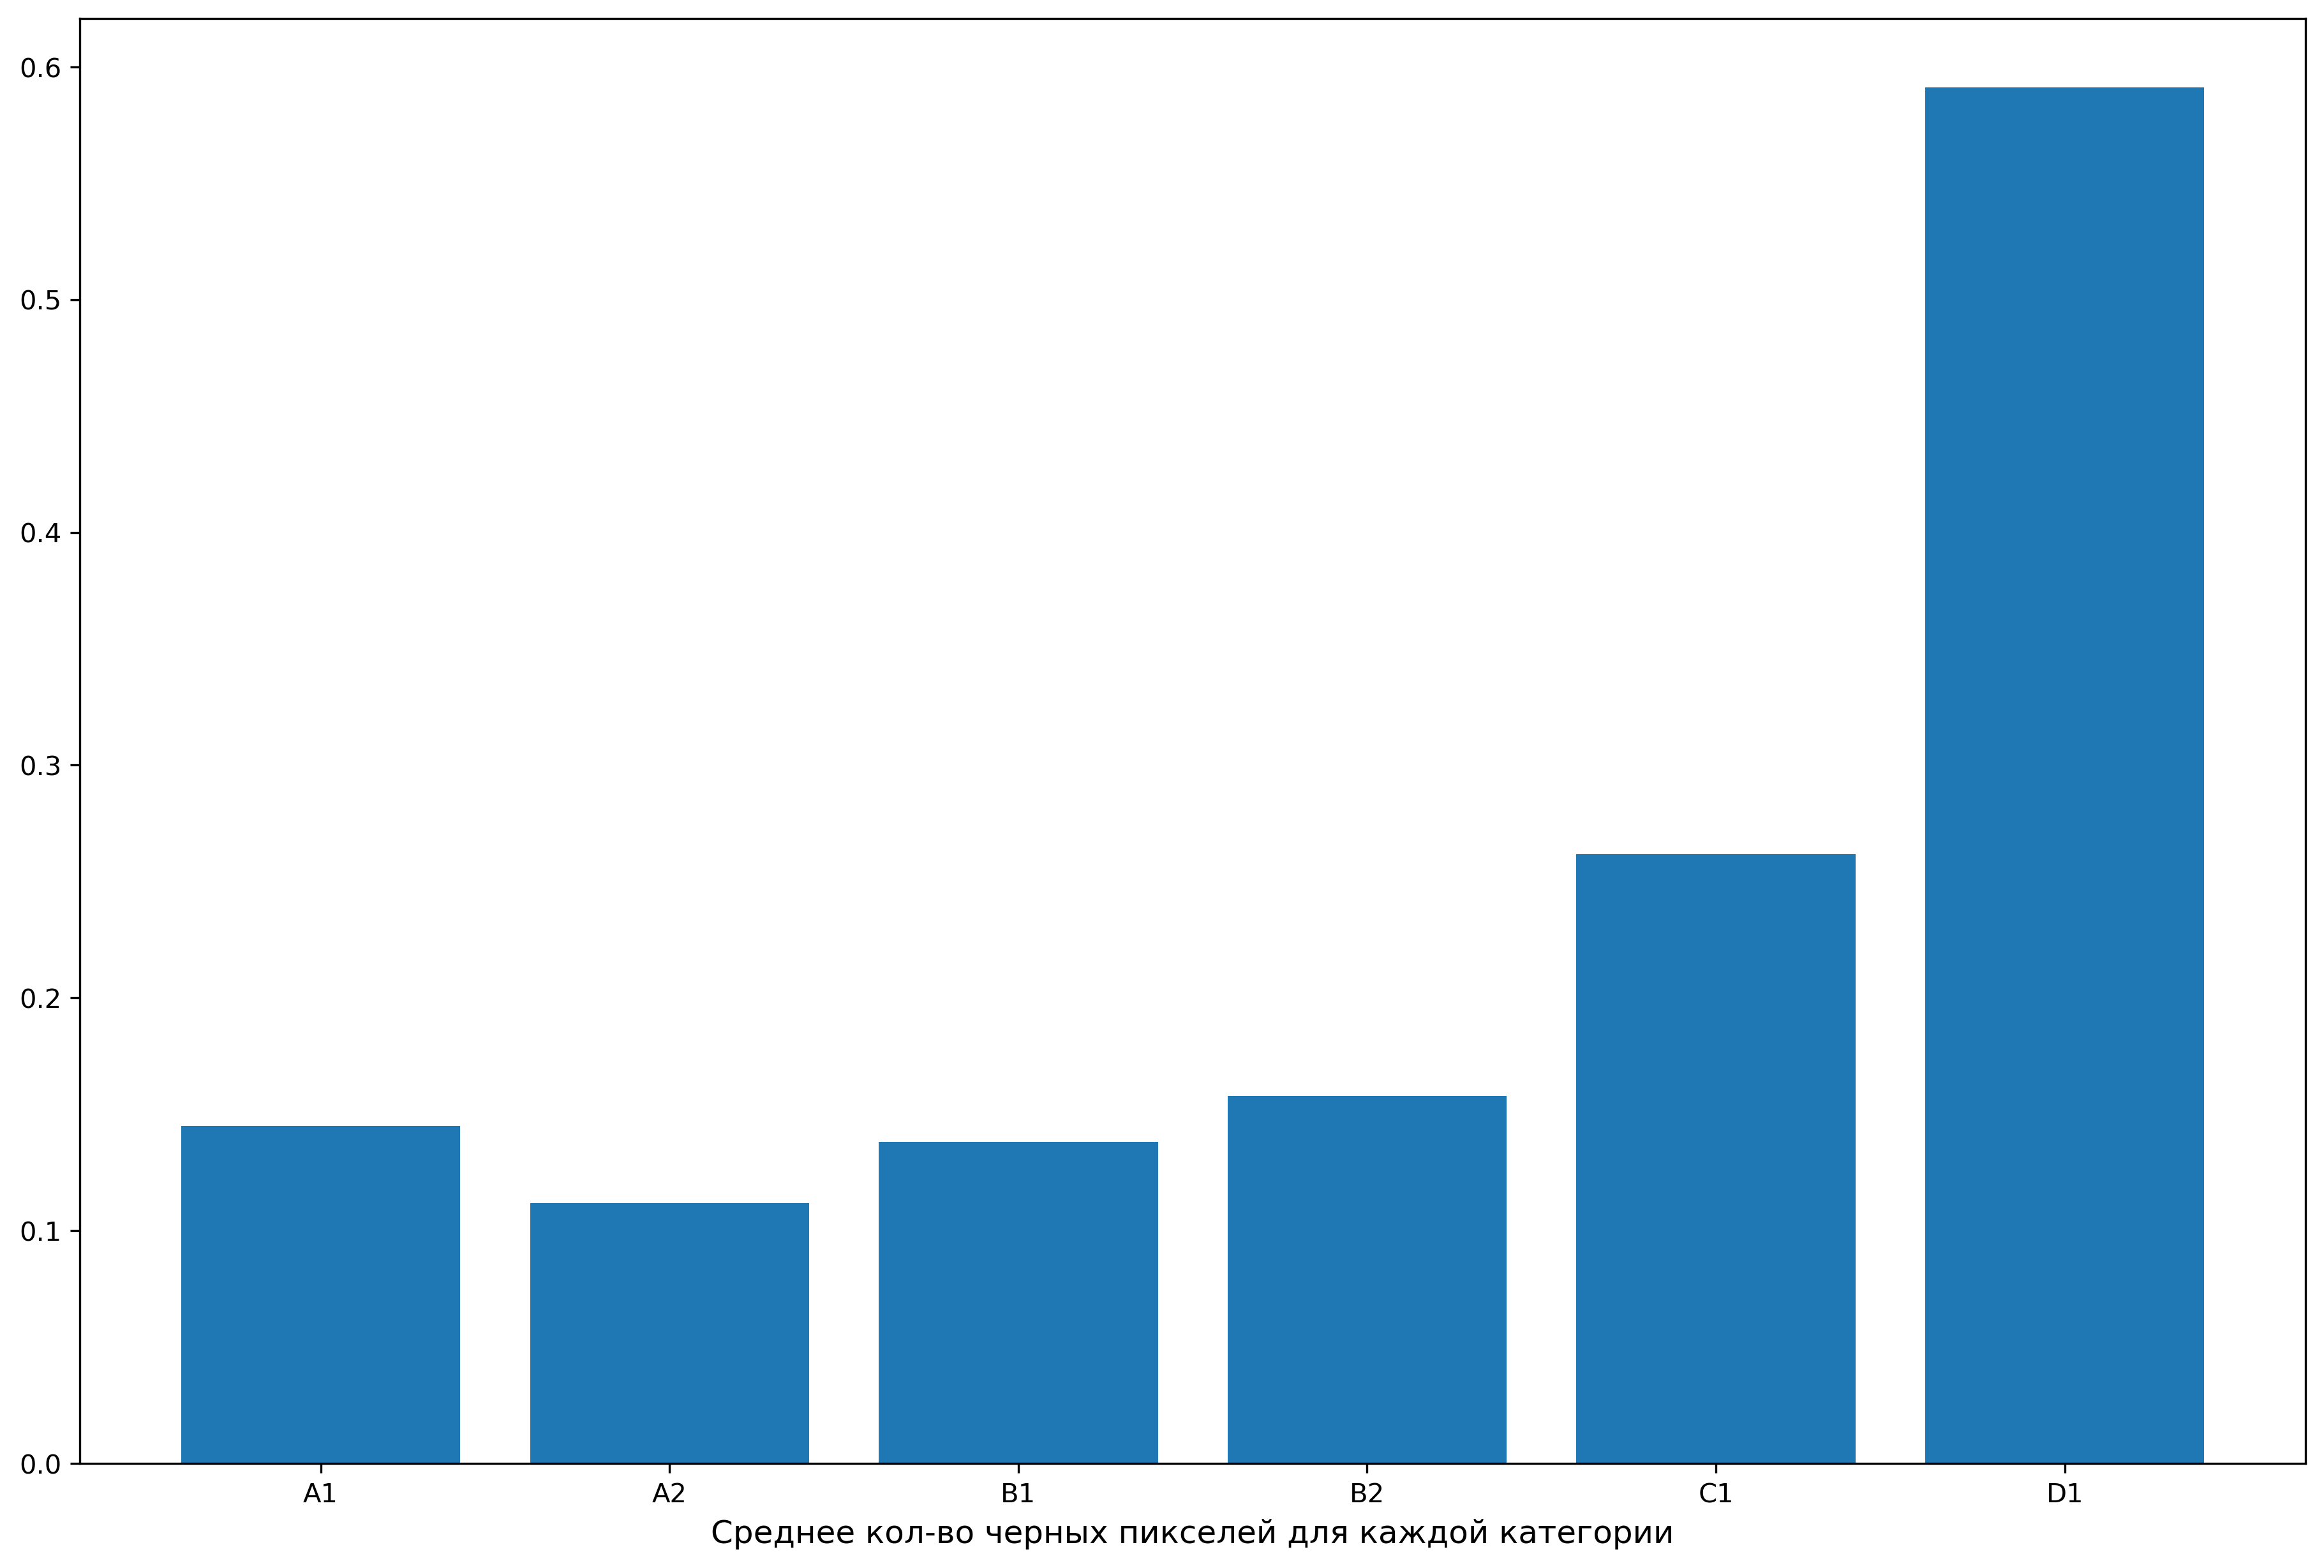

In [14]:
y_black = [np.mean(a1_black),np.mean(a2_black), np.mean(b1_black), np.mean(b2_black), np.mean(c1_black), np.mean(d1_black)]

fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
plt.bar(x_names, y_black)
# Custom Axis title
plt.xlabel('Среднее кол-во черных пикселей для каждой категории', fontsize='12', horizontalalignment='center')
# Show the graph
plt.show()

In [15]:
data = pd.DataFrame([], columns=["Отношение", "ЧП"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        data = data.append({"ЧП": cv2.countNonZero(c),"Тип": key}, ignore_index=True)

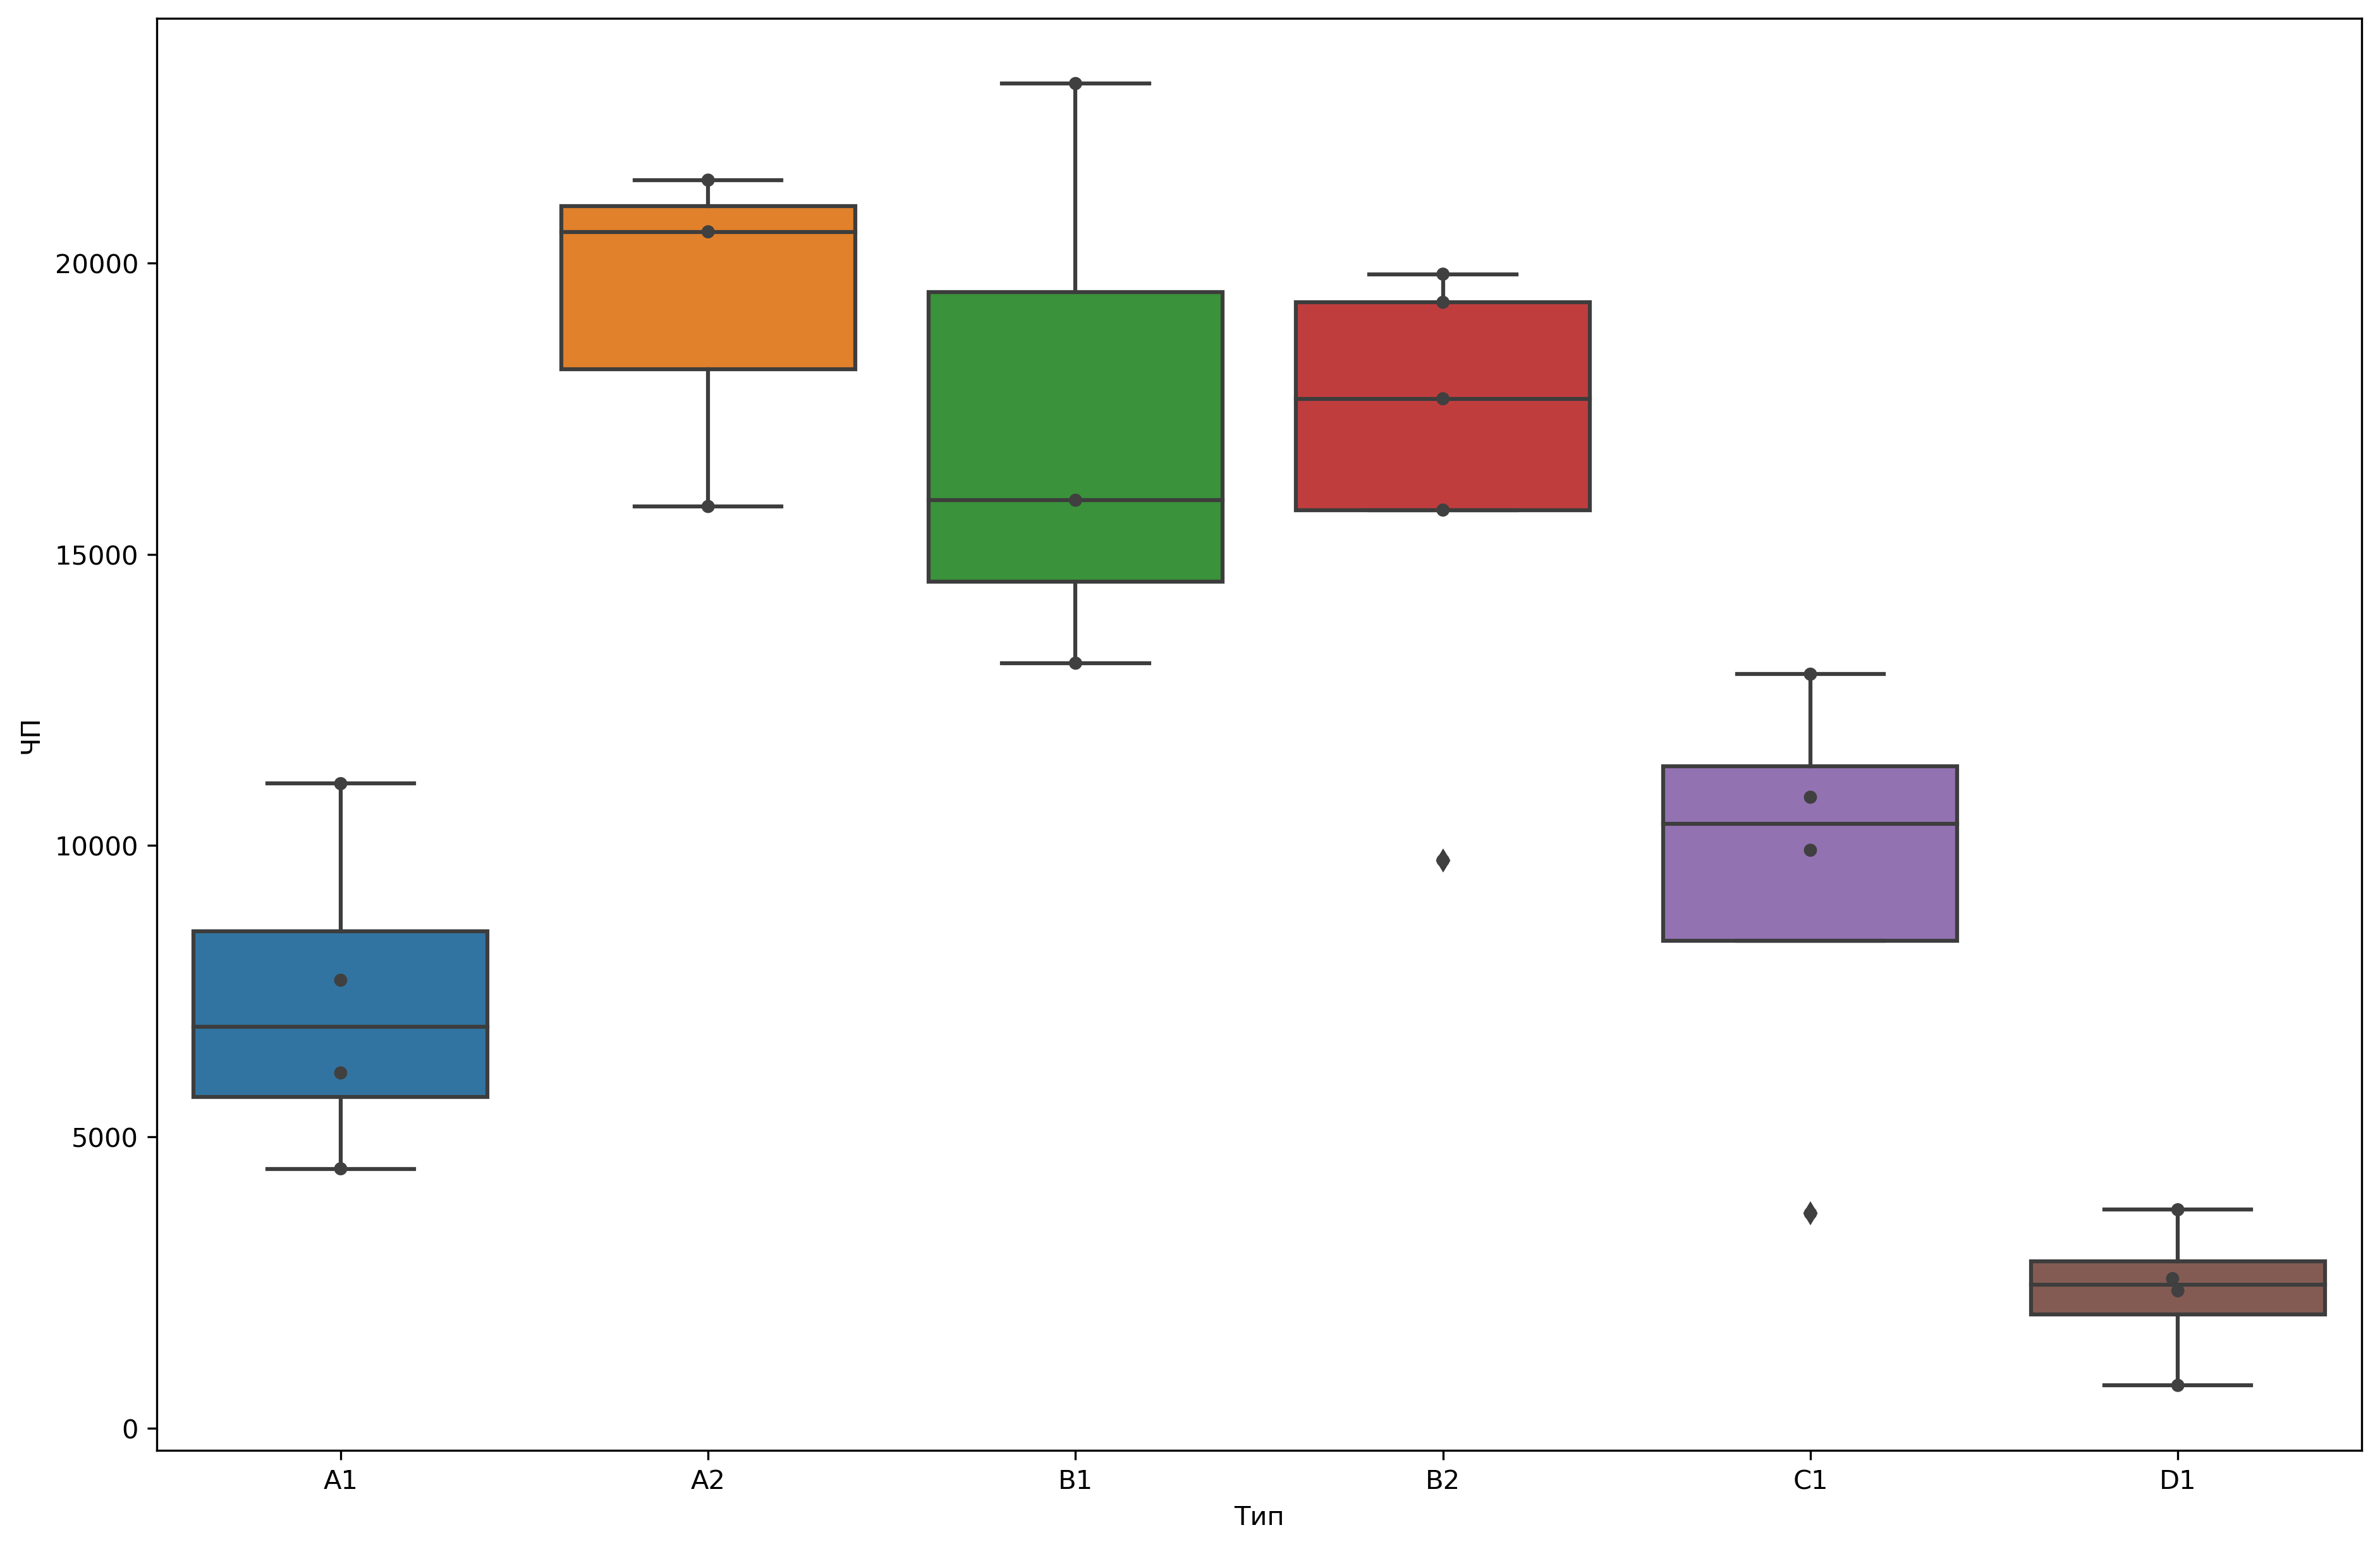

In [16]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
ax = sns.boxplot(x="Тип", y="ЧП", data=data)
ax = sns.swarmplot(x="Тип", y="ЧП", data=data, color=".25")

# Фрактальный размер

In [17]:
def fract(Cat):
    cat = []
    for c in Cat:
        cat.append(fractal_dimension(c))
    return cat

In [18]:
a1_fract = fract(A1)
a2_fract = fract(A2)
b1_fract = fract(B1)
b2_fract = fract(B2)
c1_fract = fract(C1)
d1_fract = fract(D1)

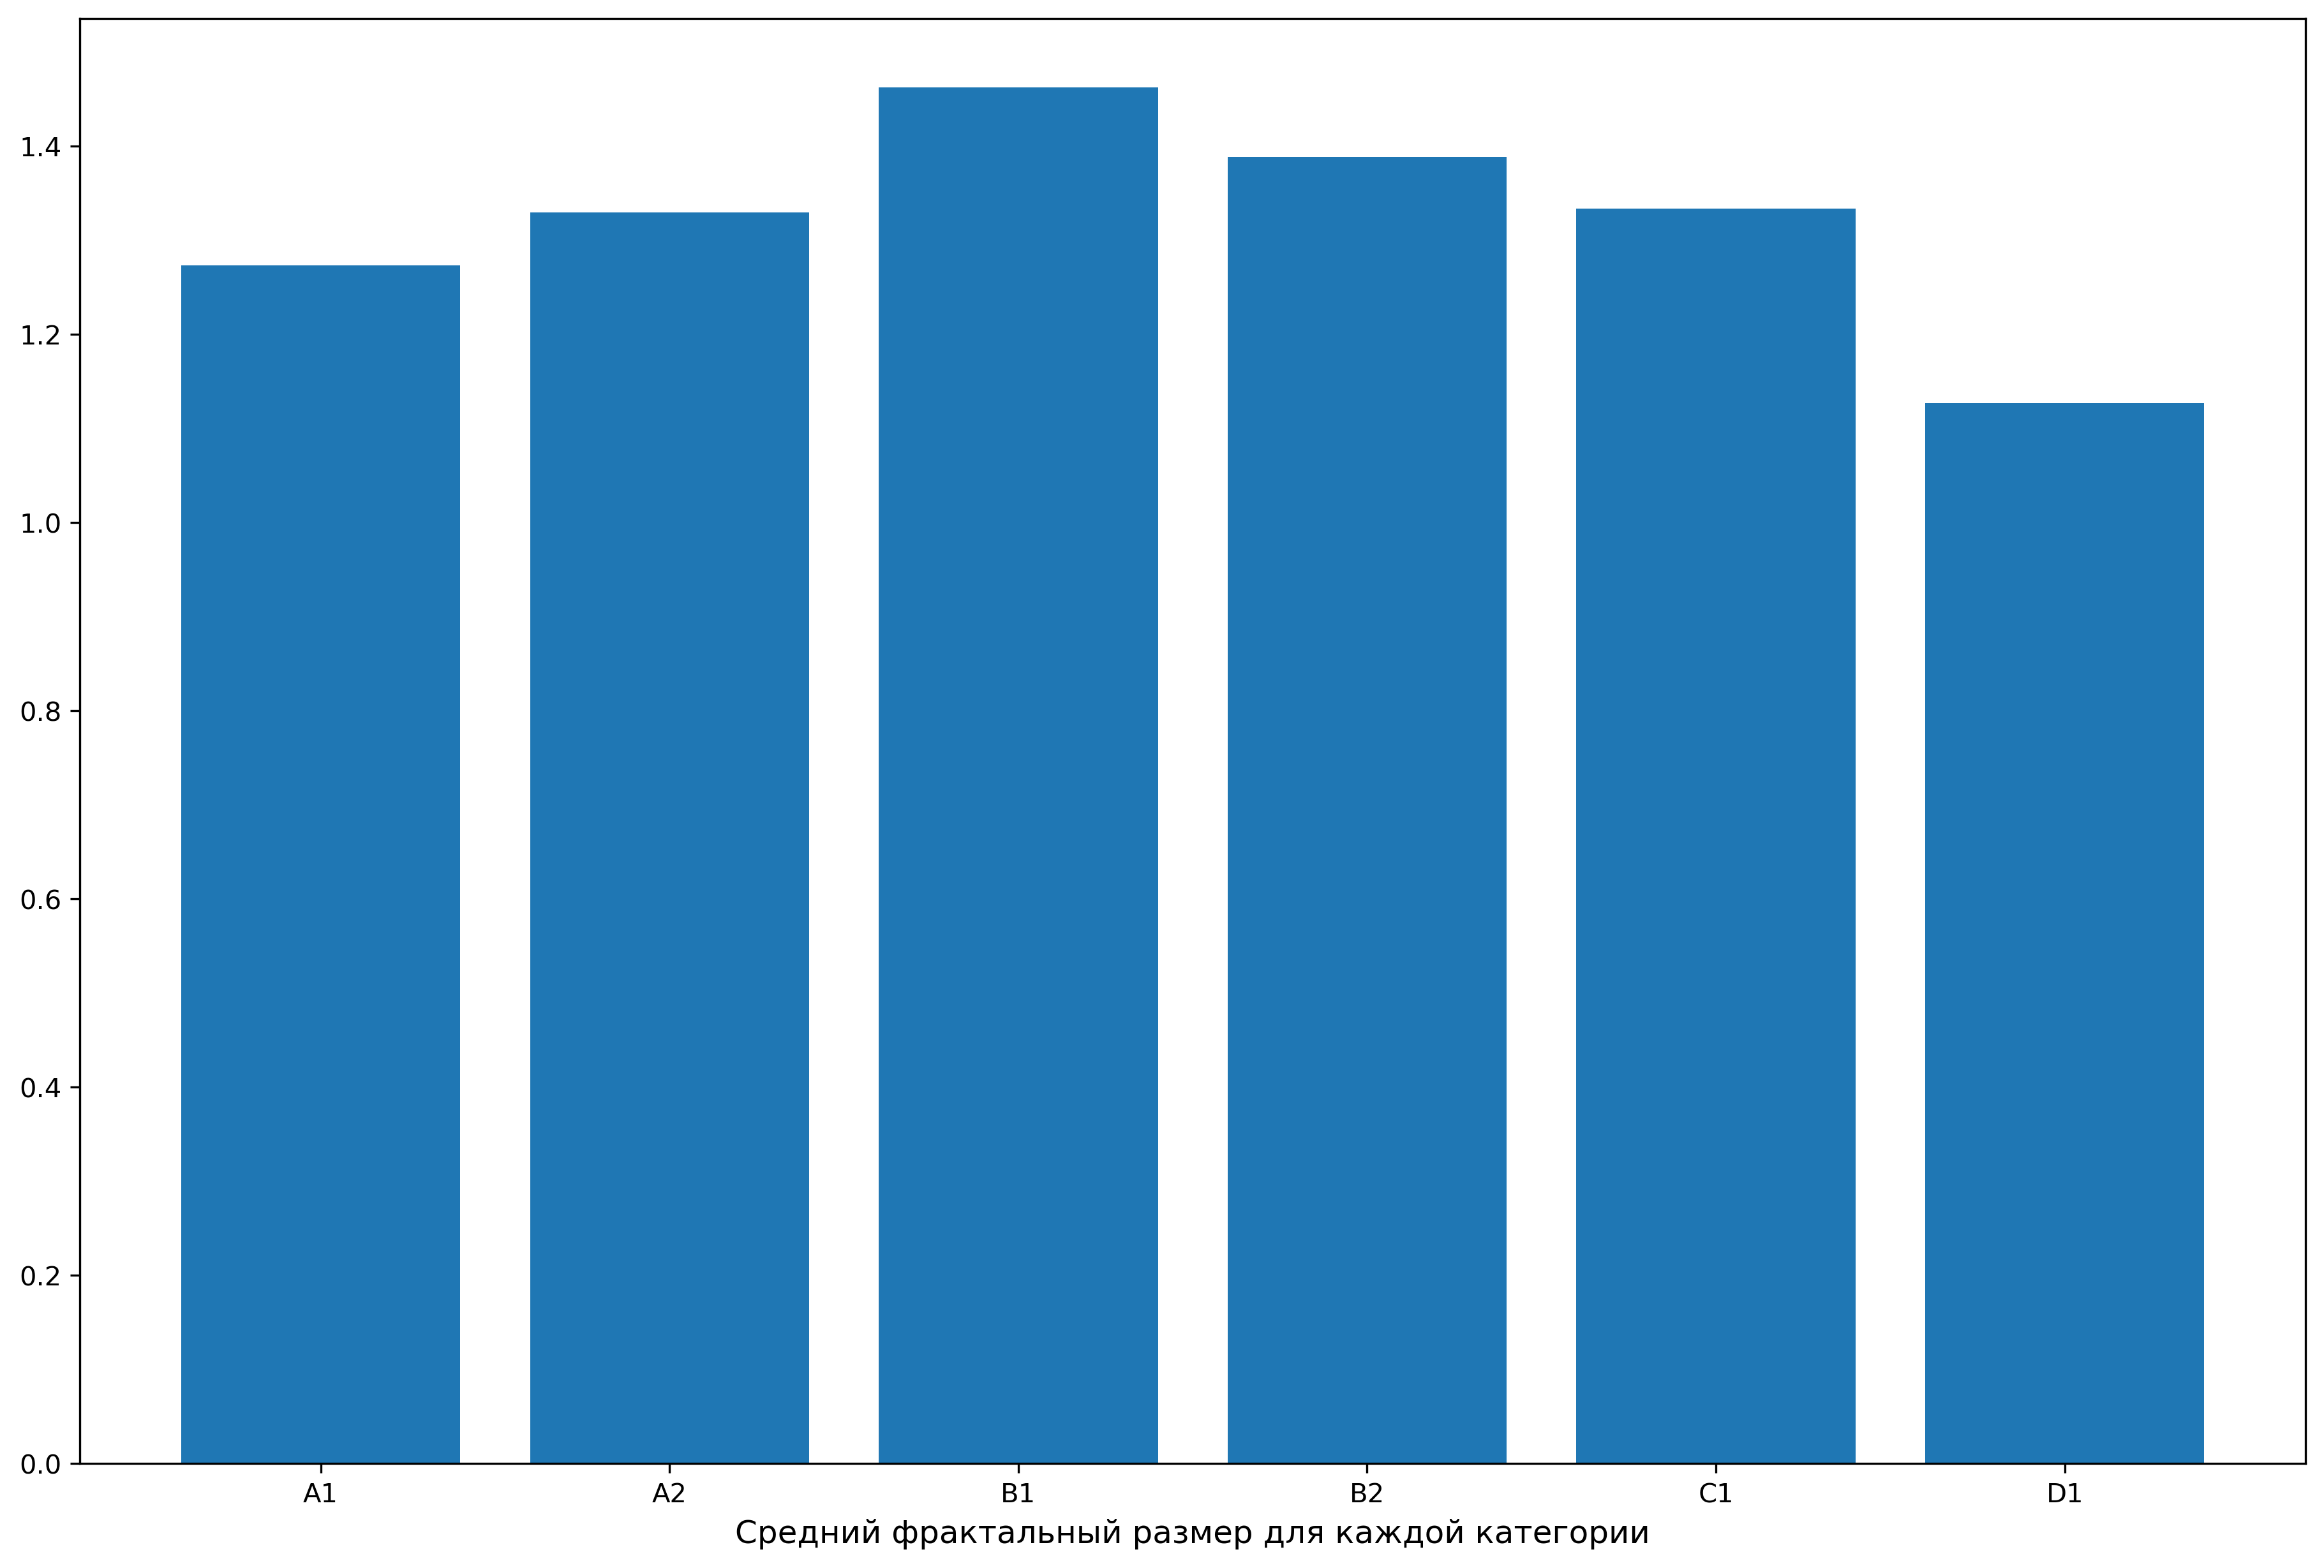

In [19]:
y_frac = [np.mean(a1_fract),np.mean(a2_fract), np.mean(b1_fract), np.mean(b2_fract), np.mean(c1_fract), np.mean(d1_fract)]

fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
plt.bar(x_names, y_frac)
# Custom Axis title
plt.xlabel('Средний фрактальный размер для каждой категории', fontsize='12', horizontalalignment='center')
# Show the graph
plt.show()

# Кластеризация

In [20]:
def scatter_plot(data, x1, x2):
    fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
    b = sns.scatterplot(data=data, x=x1, y=x2, hue="Тип", style="Тип", palette='binary', s=100)
    fontsize = 20
    b.set_xlabel(x1,fontsize=fontsize)
    b.set_ylabel(x2,fontsize=fontsize)
    b.tick_params(labelsize=10)

In [21]:
# def alg_comparison(data,cat,i,clf):
#     x = data.values.astype('int')
#     y = pd.Categorical(cat).codes
#     clf.fit(x, y)
#     # Plotting decision region
#     plot_decision_regions(x, y, clf=clf, legend=2)
#     # Adding axes annotations
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('Score of '+i+':'+ str(clf.score(x,y)))
#     plt.show()

# def alg_comparison(x,cat,i,clf):
#     y = pd.Categorical(cat).codes
#     clf.fit(x, y)
#     plt.scatter(x.iloc[:, [0]],x.iloc[:, [1]], c=clf.predict(x))
#     plt.title('Score of '+i+':'+ str(clf.score(x,y)))
#     plt.show()

In [22]:
def alg_comparison(data,x1, x2, i, clf):
    fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
    clf.fit(data[[x1, x2]], data['Тип'])
    data['Предсказание'] = clf.predict(data[[x1,x2]])
    b = sns.scatterplot(data=data, x=x1, y=x2, hue="Предсказание", style="Предсказание", palette='binary', s=100)
    ax = plt.gca()
    fontsize = 20
    ax.set_title('Score of '+i+':'+ str(clf.score(data[[x1,x2]],data['Тип'])), fontsize=fontsize)
    b.set_xlabel(x1,fontsize=fontsize)
    b.set_ylabel(x2,fontsize=fontsize)
    b.tick_params(labelsize=10)

In [23]:
def kmeans_vis(data,x1, x2):
    n = 6
#     centroids, _ = kmeans_plusplus(data[[x1,x2]].to_numpy(), n_clusters=n, random_state=0)
#     kmeans = KMeans(n_clusters=n, random_state=0, init=centroids)
    kmeans = KMeans(n_clusters=n, random_state=0, n_init=10)
    kmeans.fit(data[[x1,x2]])
    data['Предсказание'] = kmeans.predict(data[[x1,x2]])
    fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
    b = sns.scatterplot(data=data, x=x1, y=x2, hue="Предсказание", style="Предсказание", palette='binary', s=100)
    fontsize = 20
    b.set_xlabel(x1,fontsize=fontsize)
    b.set_ylabel(x2,fontsize=fontsize)
    b.tick_params(labelsize=10)

In [24]:
def algs():
    lr = LogisticRegression(random_state=1,
                      solver='newton-cg',
                      multi_class='multinomial')
    rf = RandomForestClassifier(random_state=1, n_estimators=100)
    gaus = GaussianNB()
    neig = KNeighborsClassifier(n_neighbors=6)
    algs = {
    "RandomForest":rf,
    "Gausian": gaus,
    "KNeighbors":neig
    }
    return algs

## Трехмерное пространство данных

In [40]:
data = pd.DataFrame([], columns=["МВО", "Фрактал", "ЧП","Тип"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        cnts = find_contour(c)
        mvp = jarvismarch(cnts)
        mch = square_polygon(mvp)
        data = data.append({"МВО": mch,
                            "Фрактал": fractal_dimension(c), 
                            "ЧП": (c!=255).sum(), 
                            "Тип": key}, ignore_index=True)

In [41]:
data.head()

,МВО,Фрактал,ЧП,Тип
0,3490.0,1.401559,475,A1
1,4650.0,1.261811,579,A1
2,3435.5,1.142611,622,A1
3,7789.5,1.286943,1080,A1
4,15727.5,1.313664,1729,A2


In [42]:
for i, clf in algs().items():
    clf.fit(data.drop(["Тип"],axis=1), data["Тип"])
    print("score of "+i+" is "+str(clf.score(data.drop(["Тип"],axis=1), data["Тип"])))

score of RandomForest is 1.0
score of Gausian is 0.6521739130434783
score of KNeighbors is 0.5217391304347826


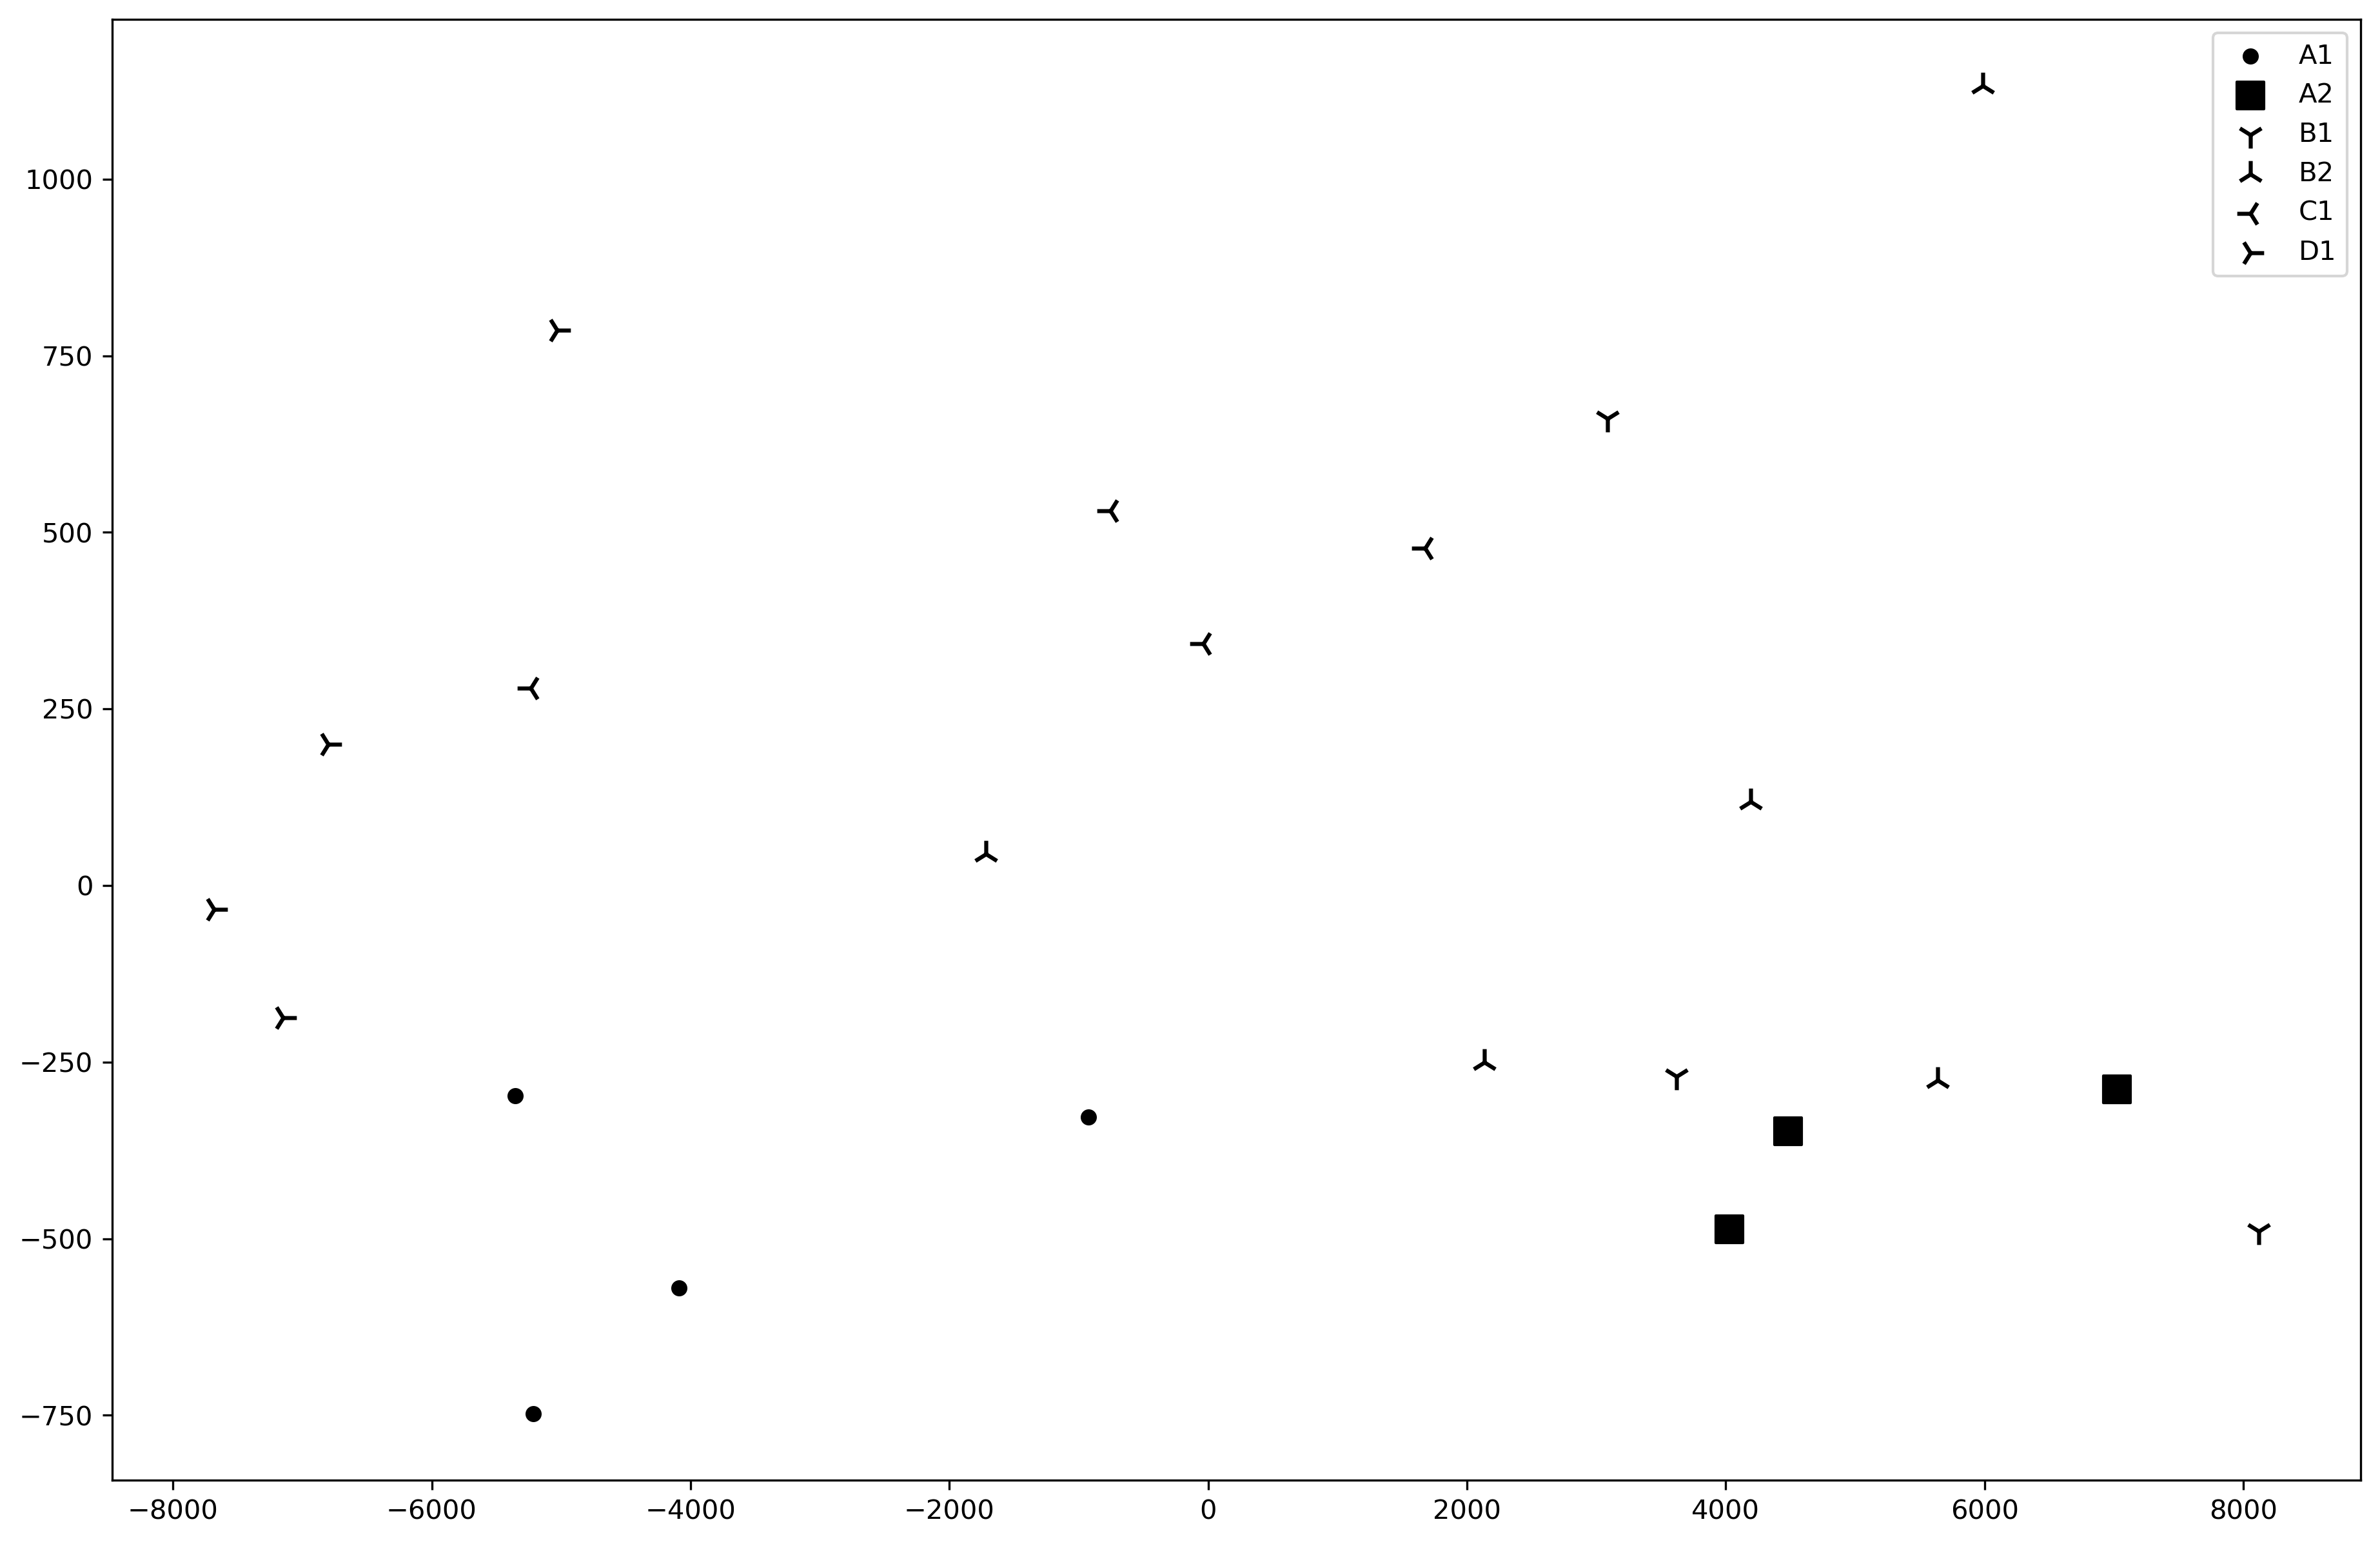

In [43]:
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]

# Определяем модель и скорость обучения
model = TSNE(n_components=2, learning_rate=1, init='pca')

# Обучаем модель
transformed = model.fit_transform(data.drop(["Тип"], axis=1))

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
group = data["Тип"]
fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
for i, g in enumerate(np.unique(group)):
    ix = np.where(group == g)
    ax.scatter(x_axis[ix], y_axis[ix],marker=unfilled_markers[i], c='black', label = g, s=100)
ax.legend()
plt.show()

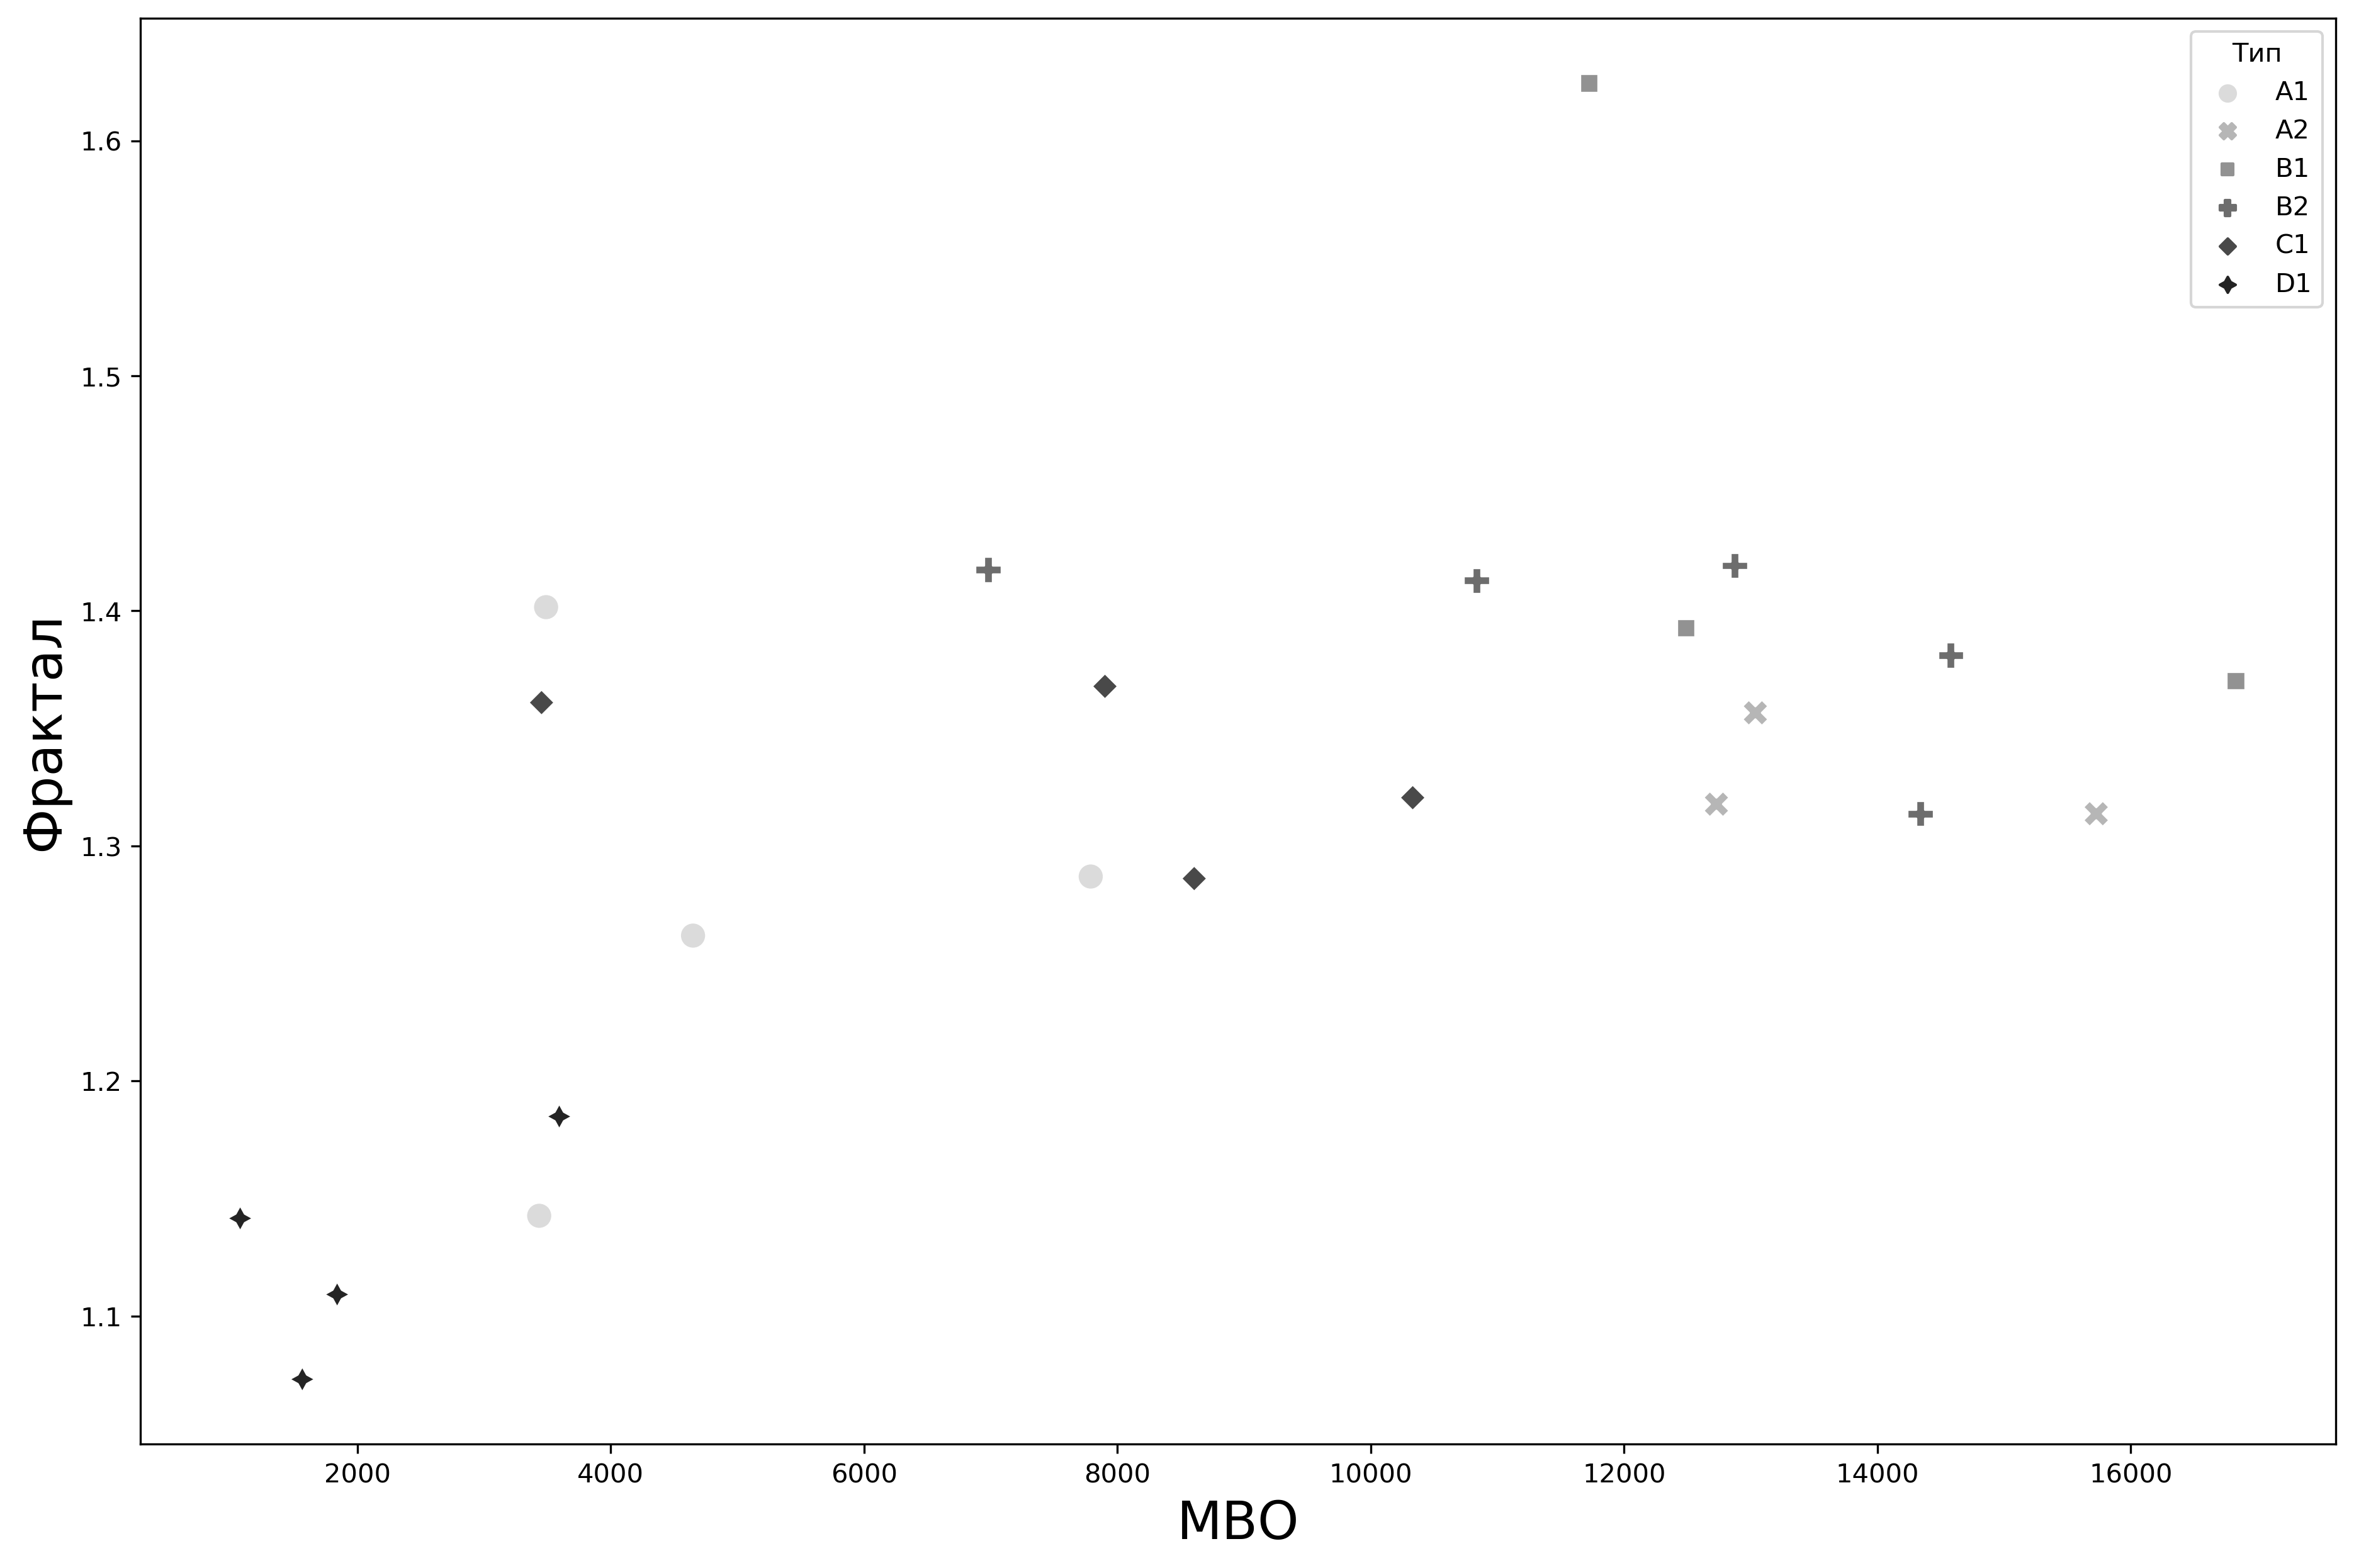

In [44]:
scatter_plot(data, "МВО", "Фрактал")

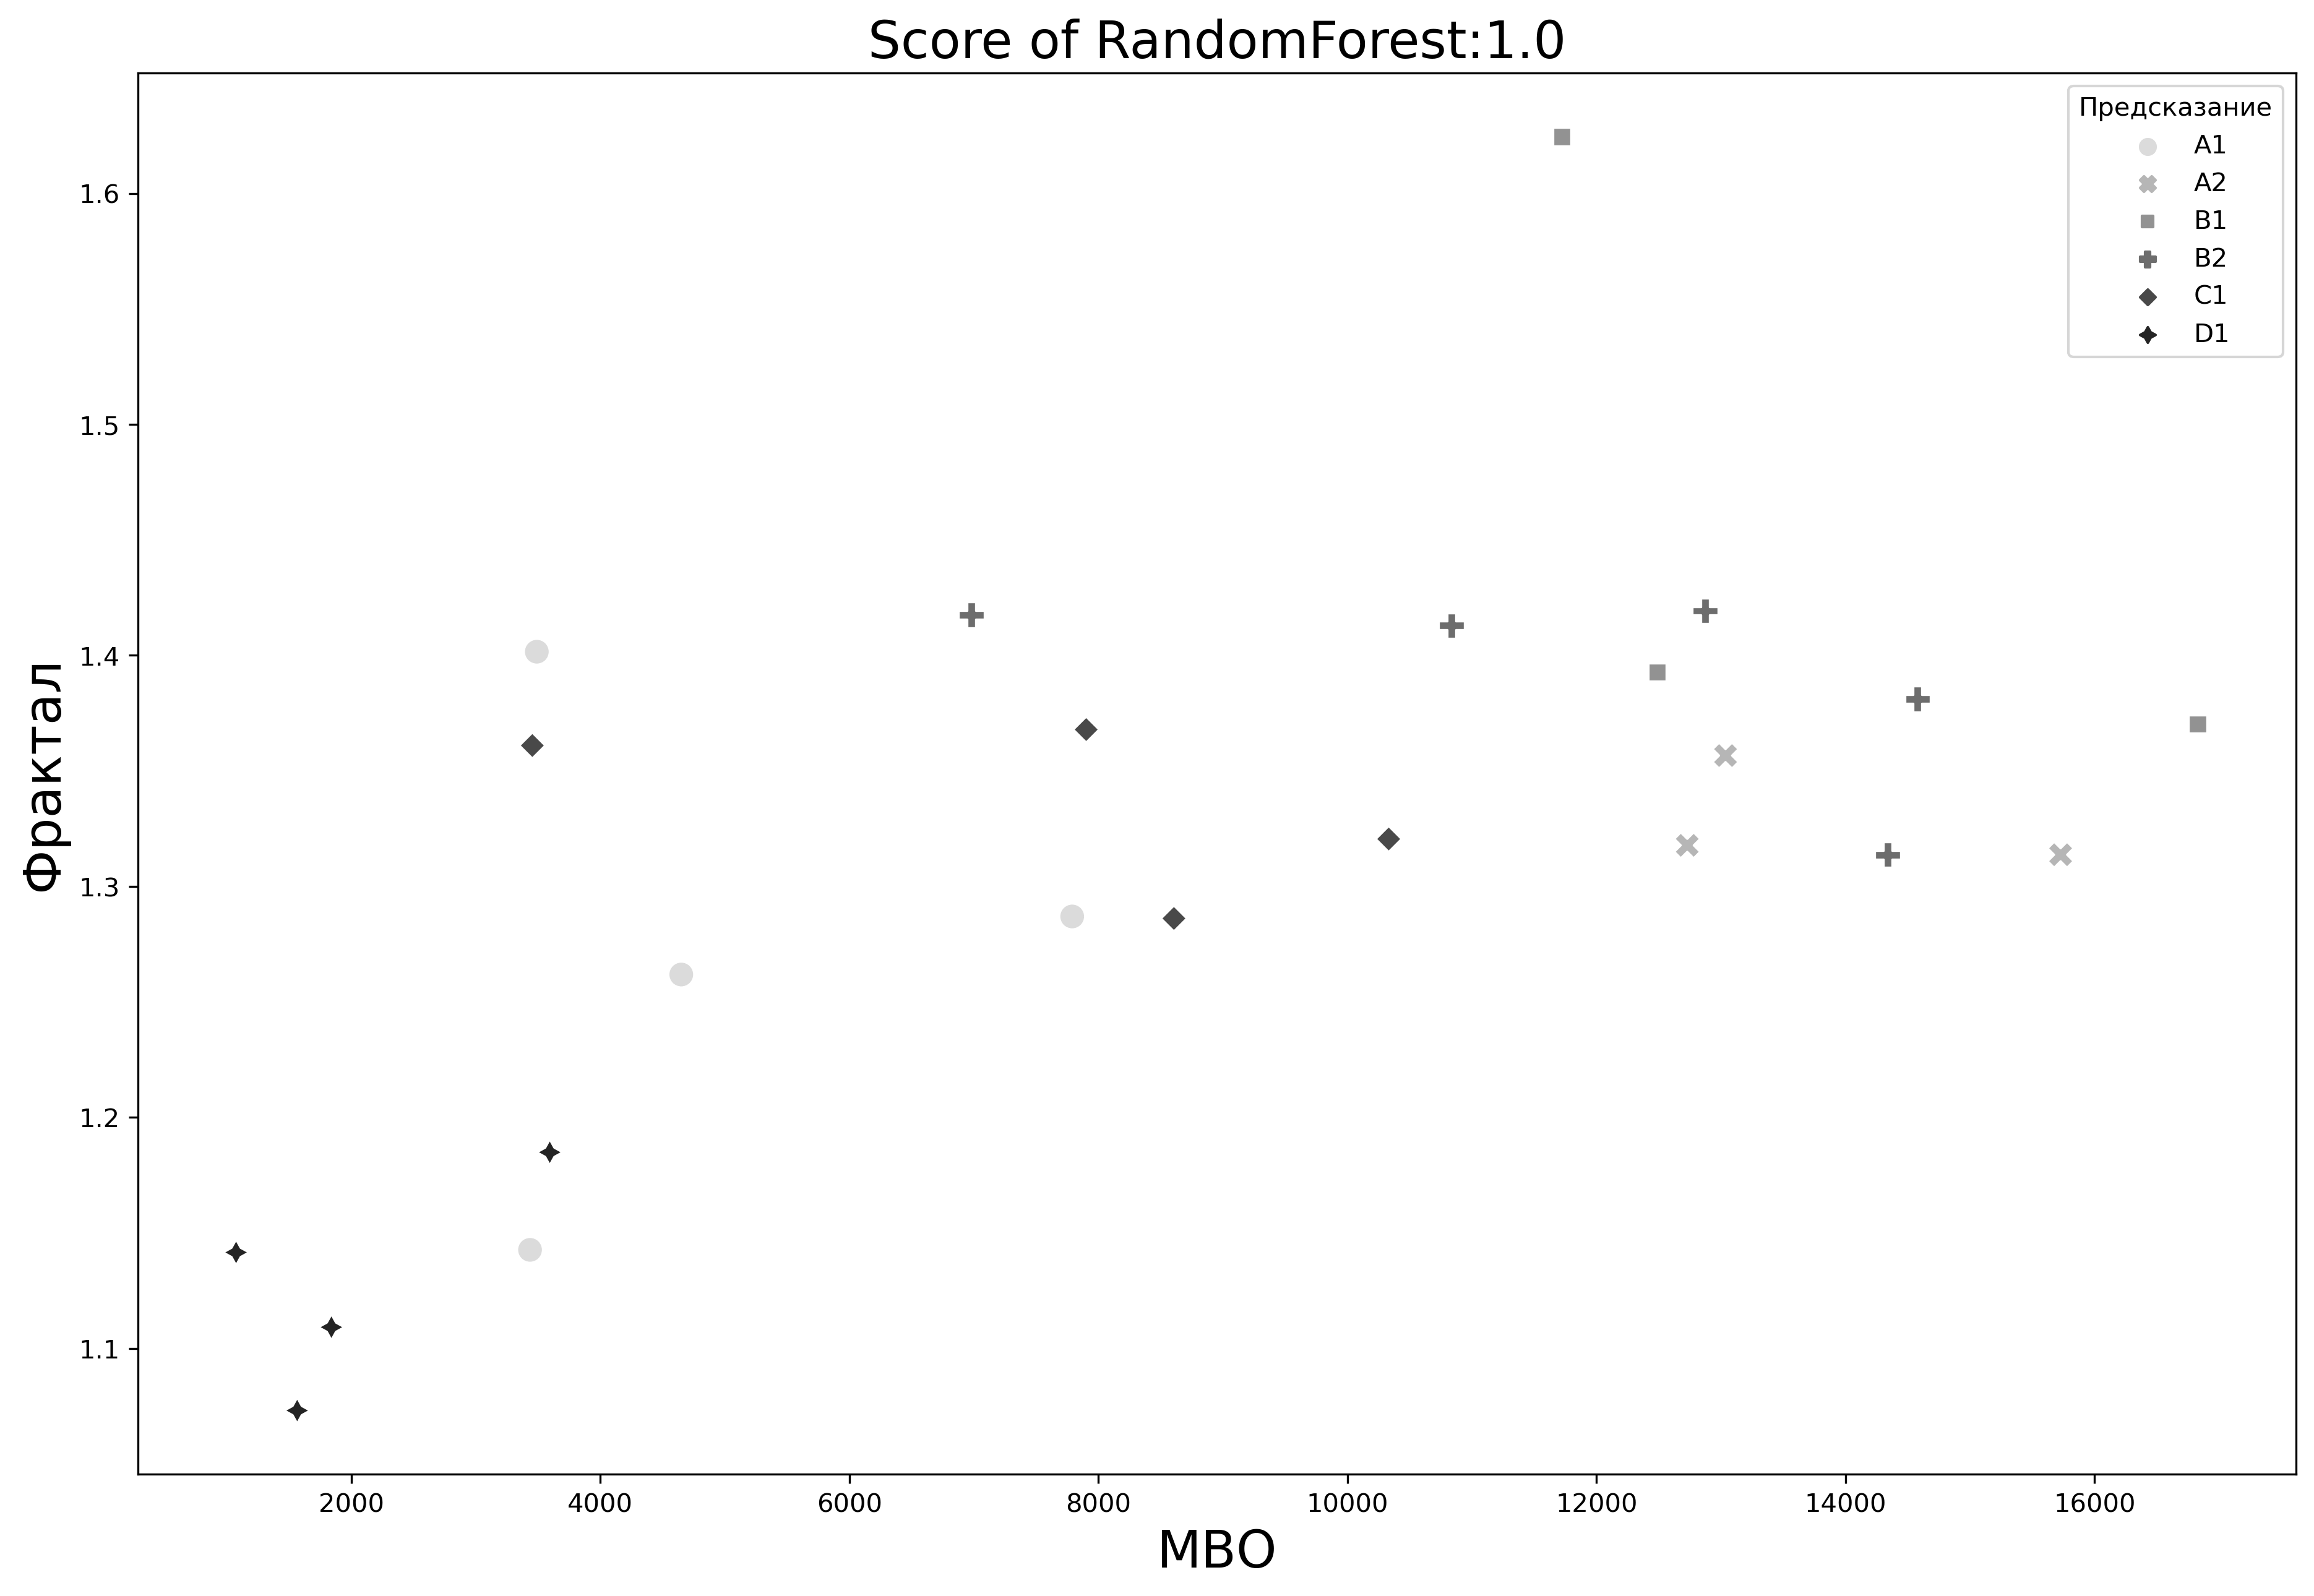

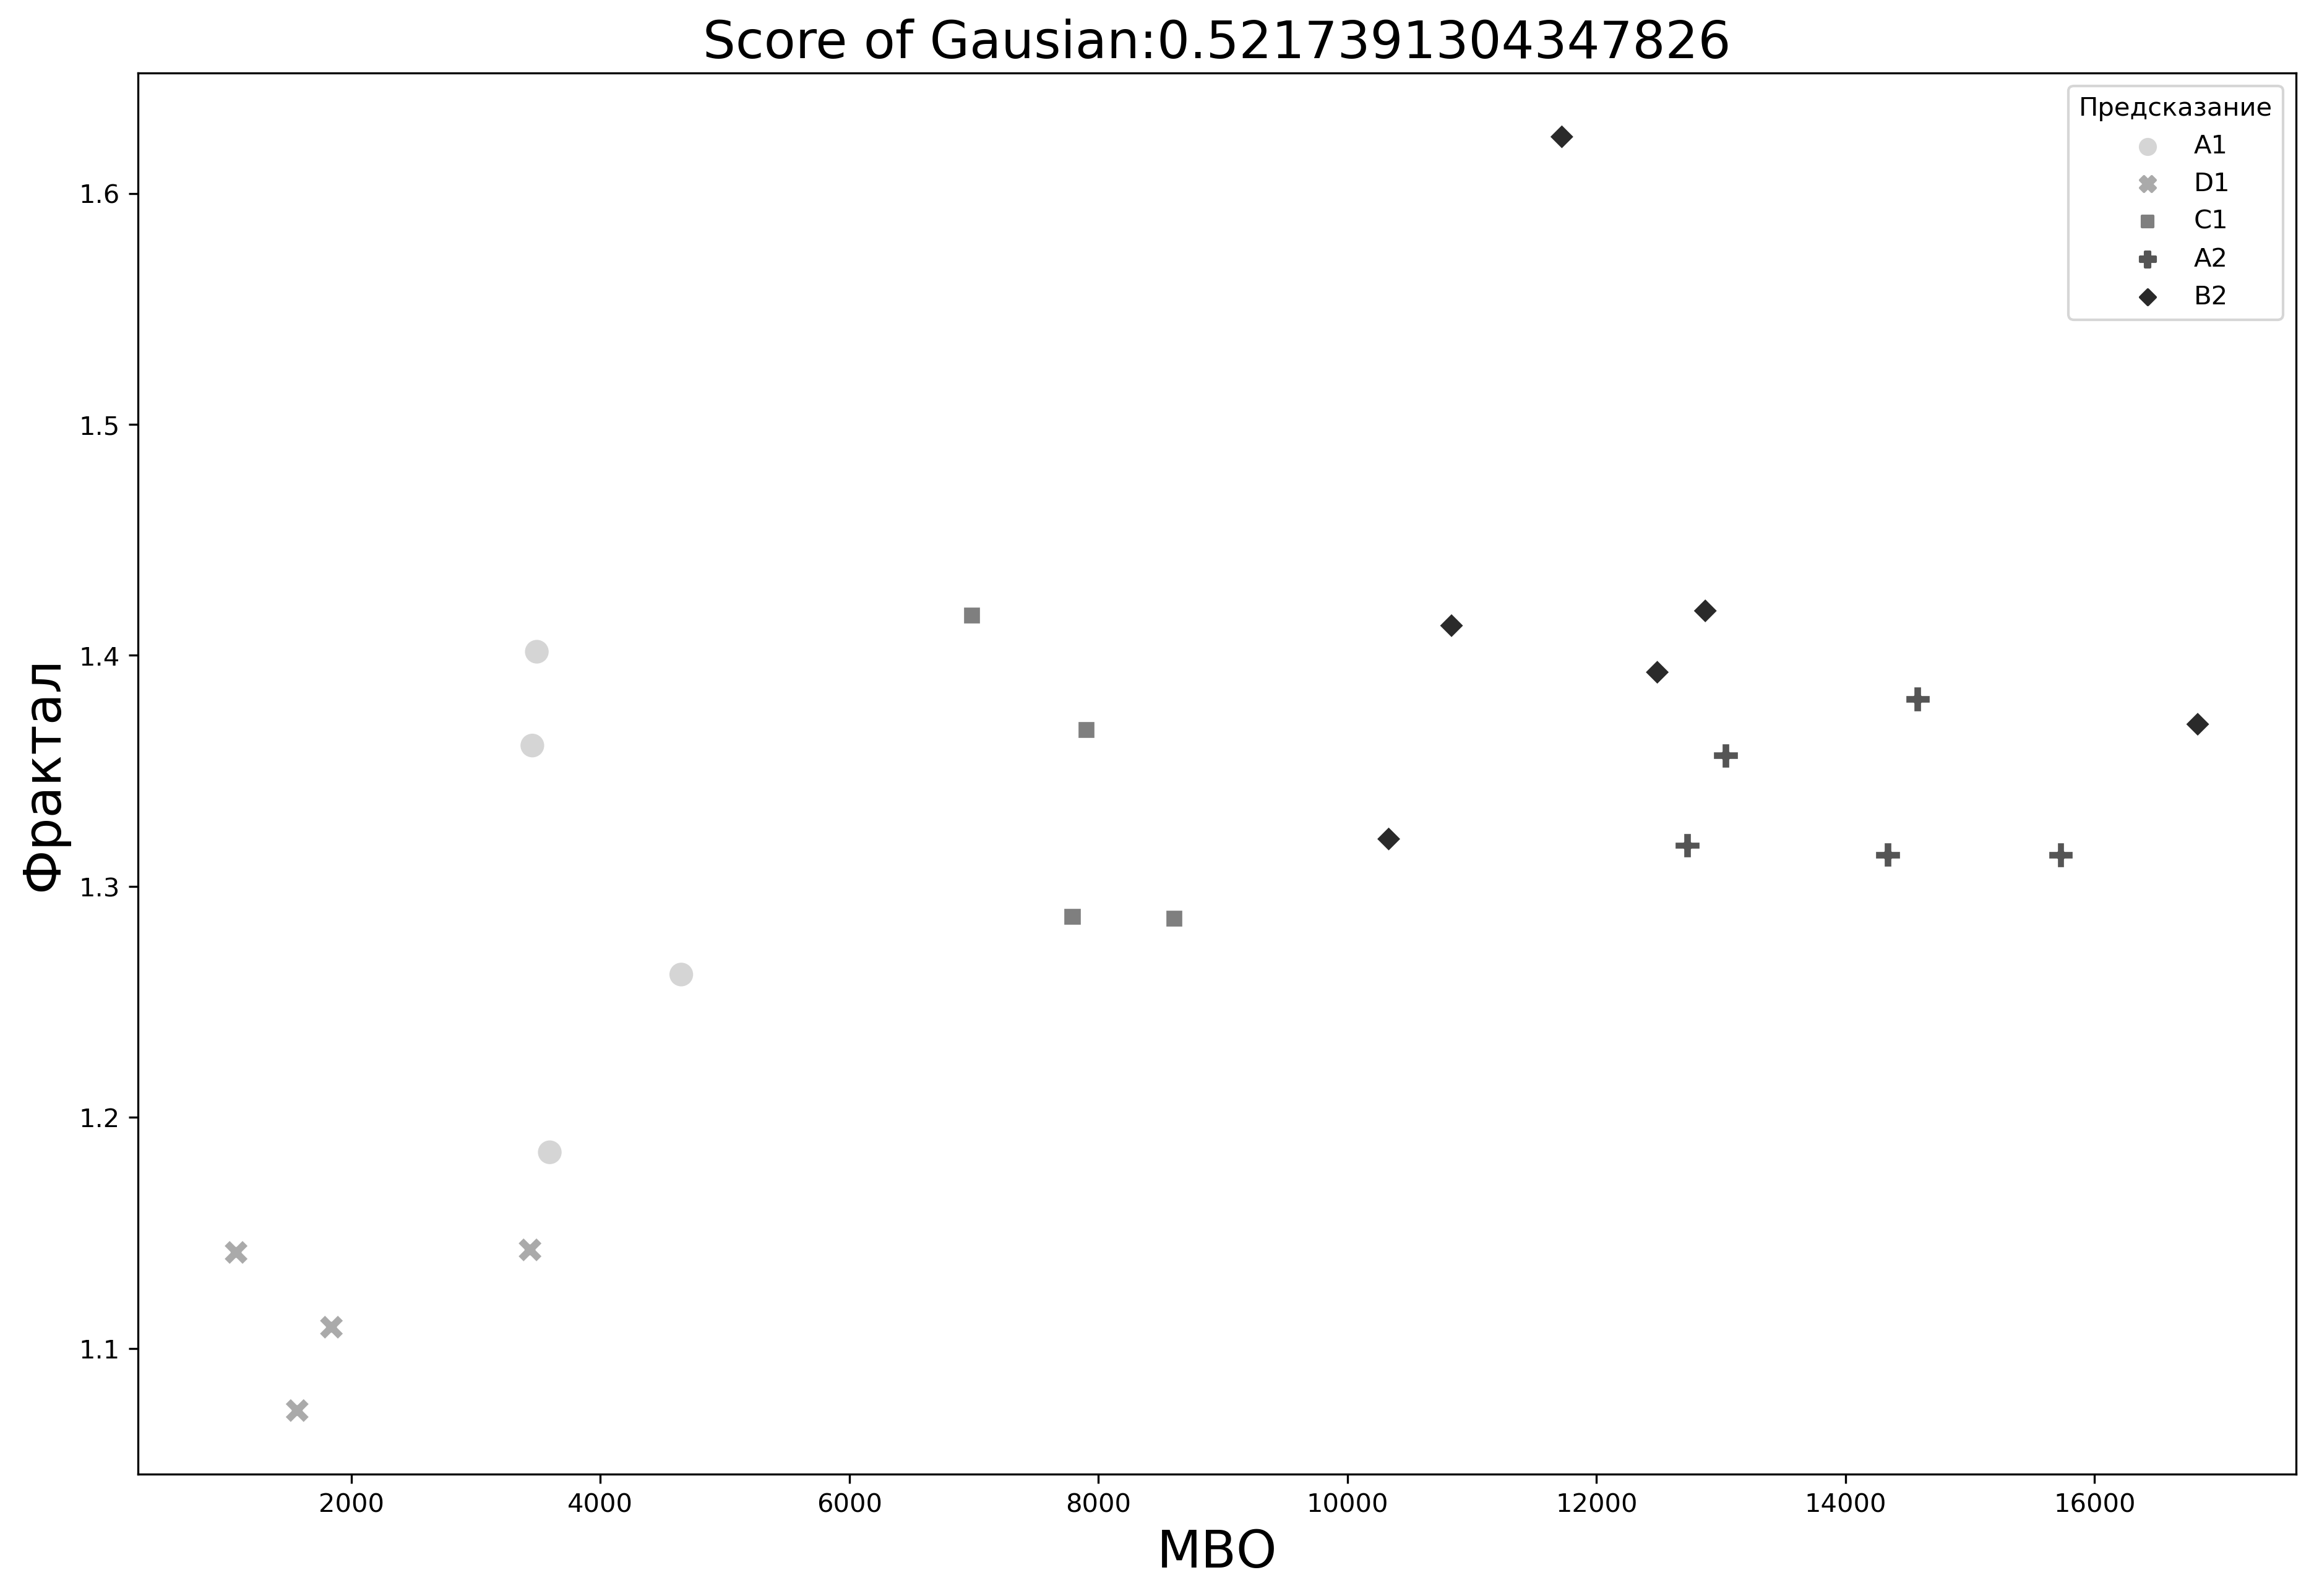

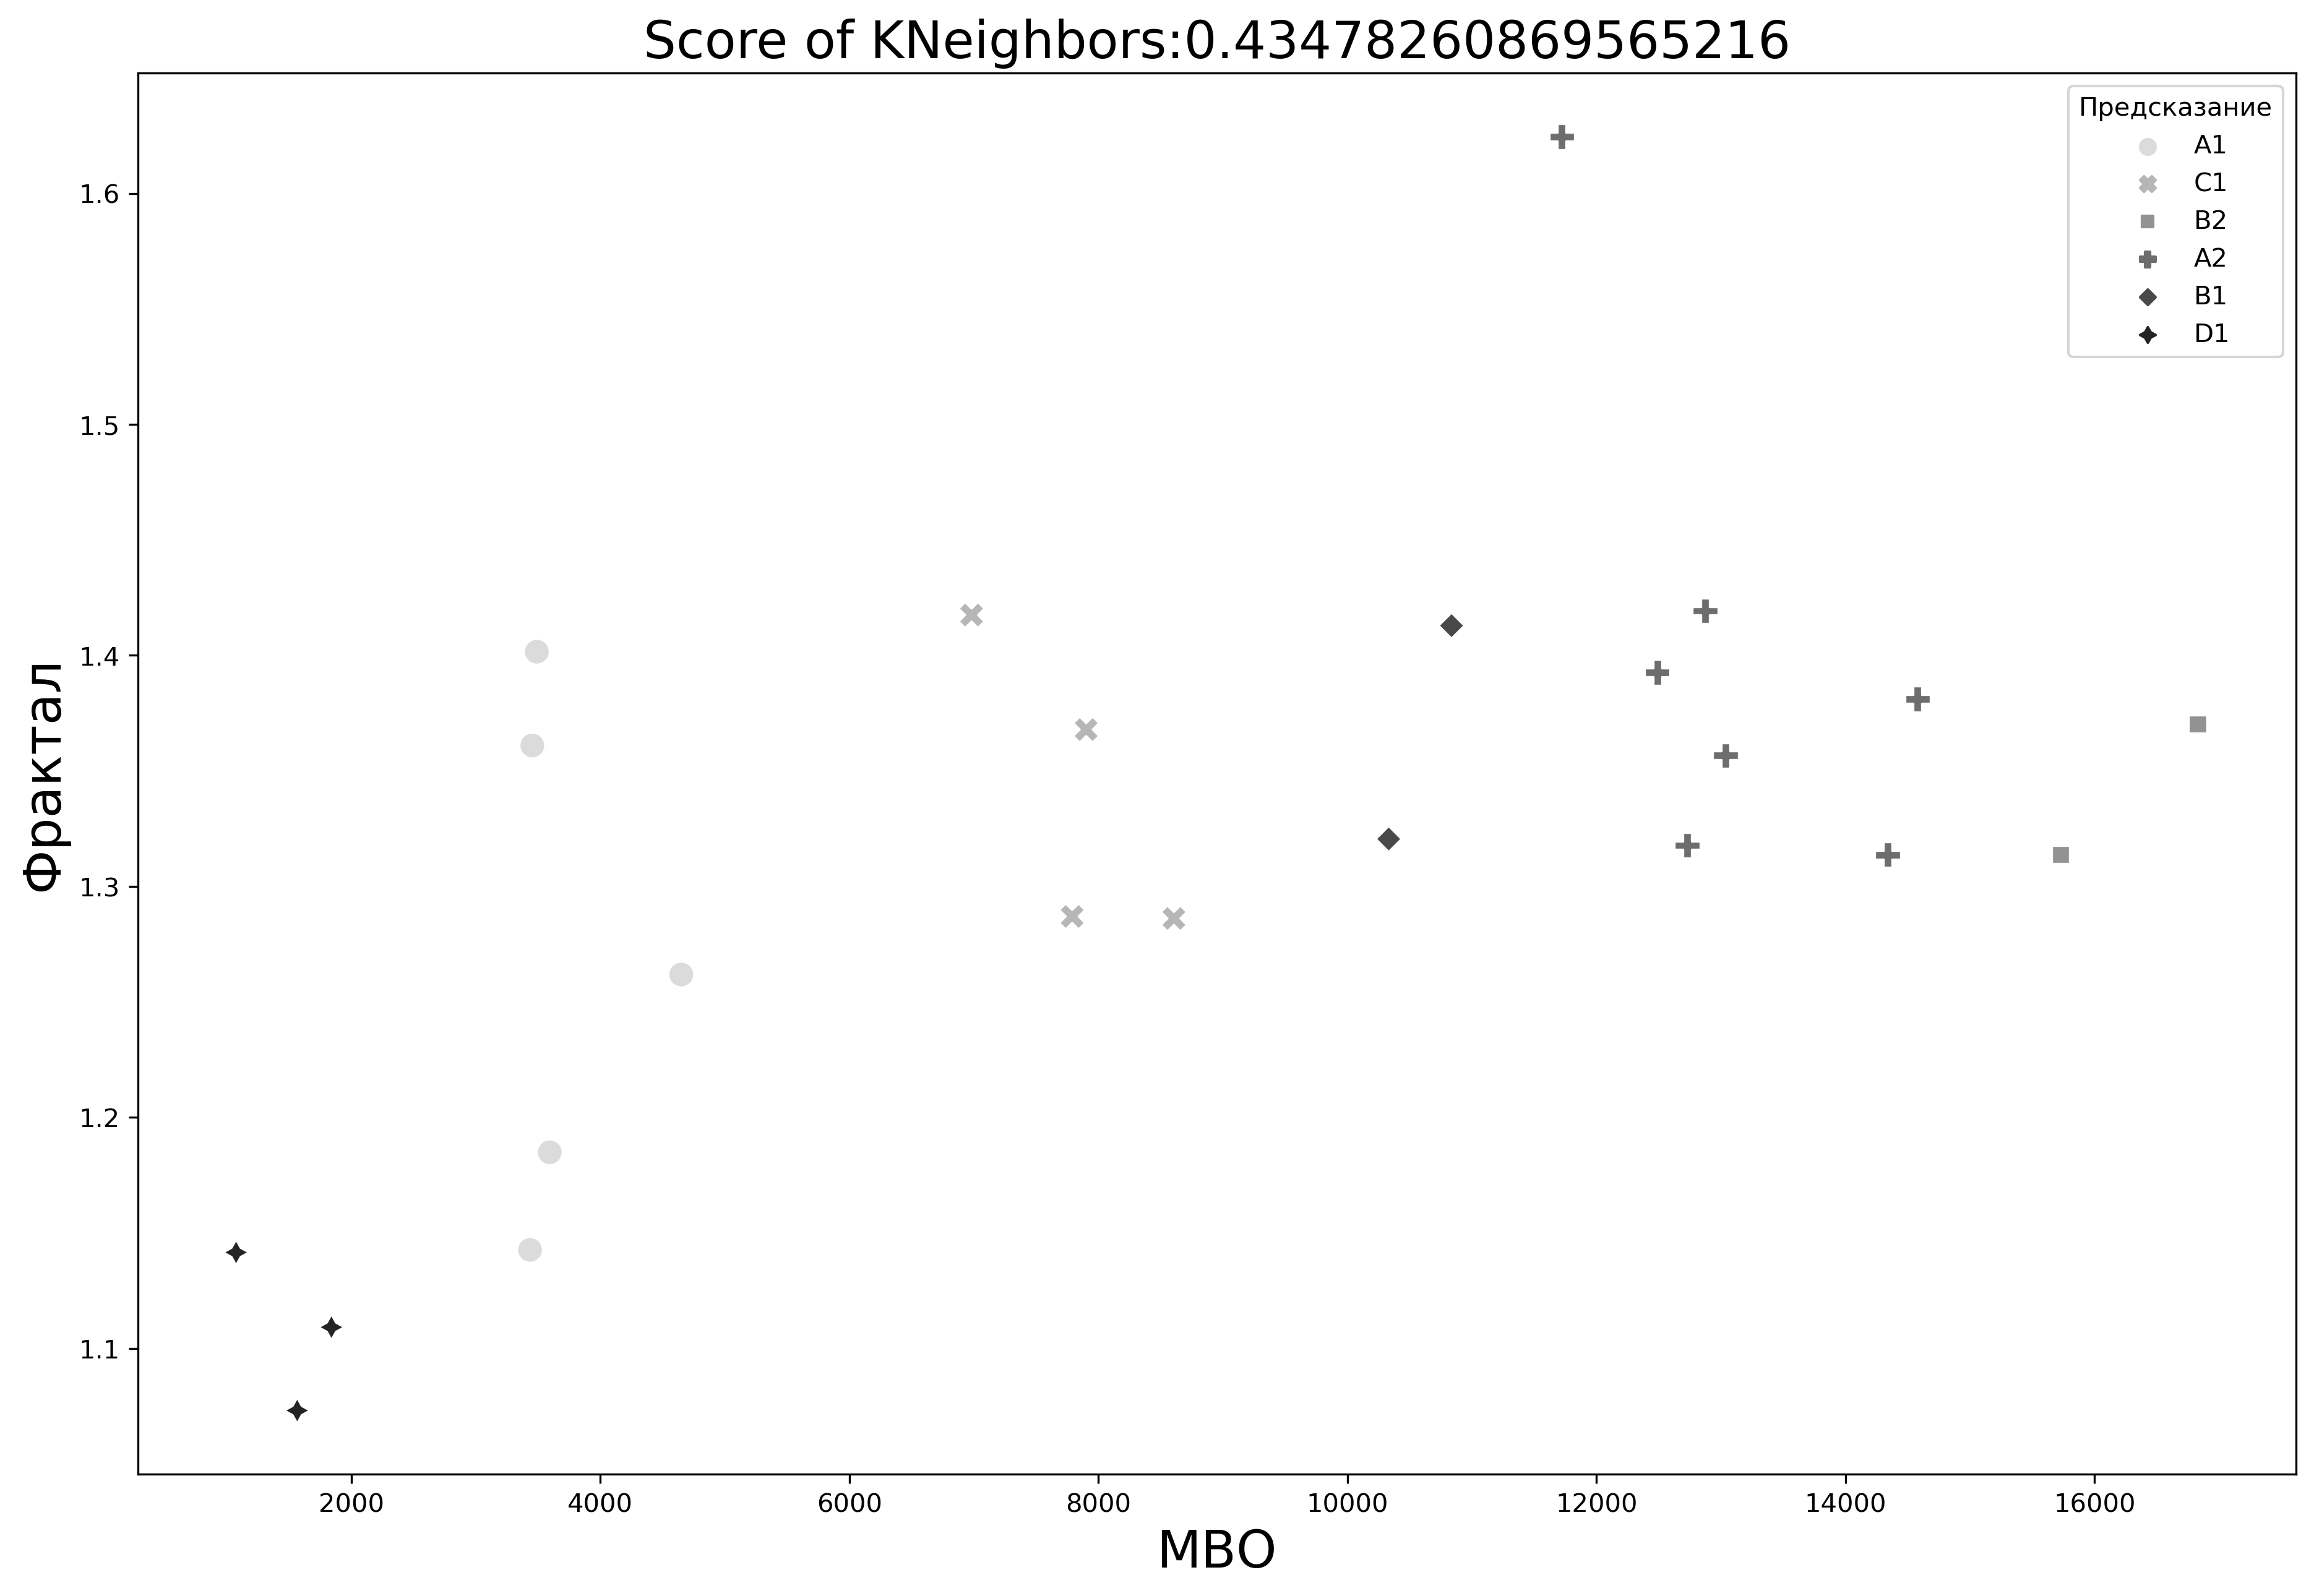

In [45]:
for i, clf in algs().items():
    alg_comparison(data, "МВО", "Фрактал", i, clf)    

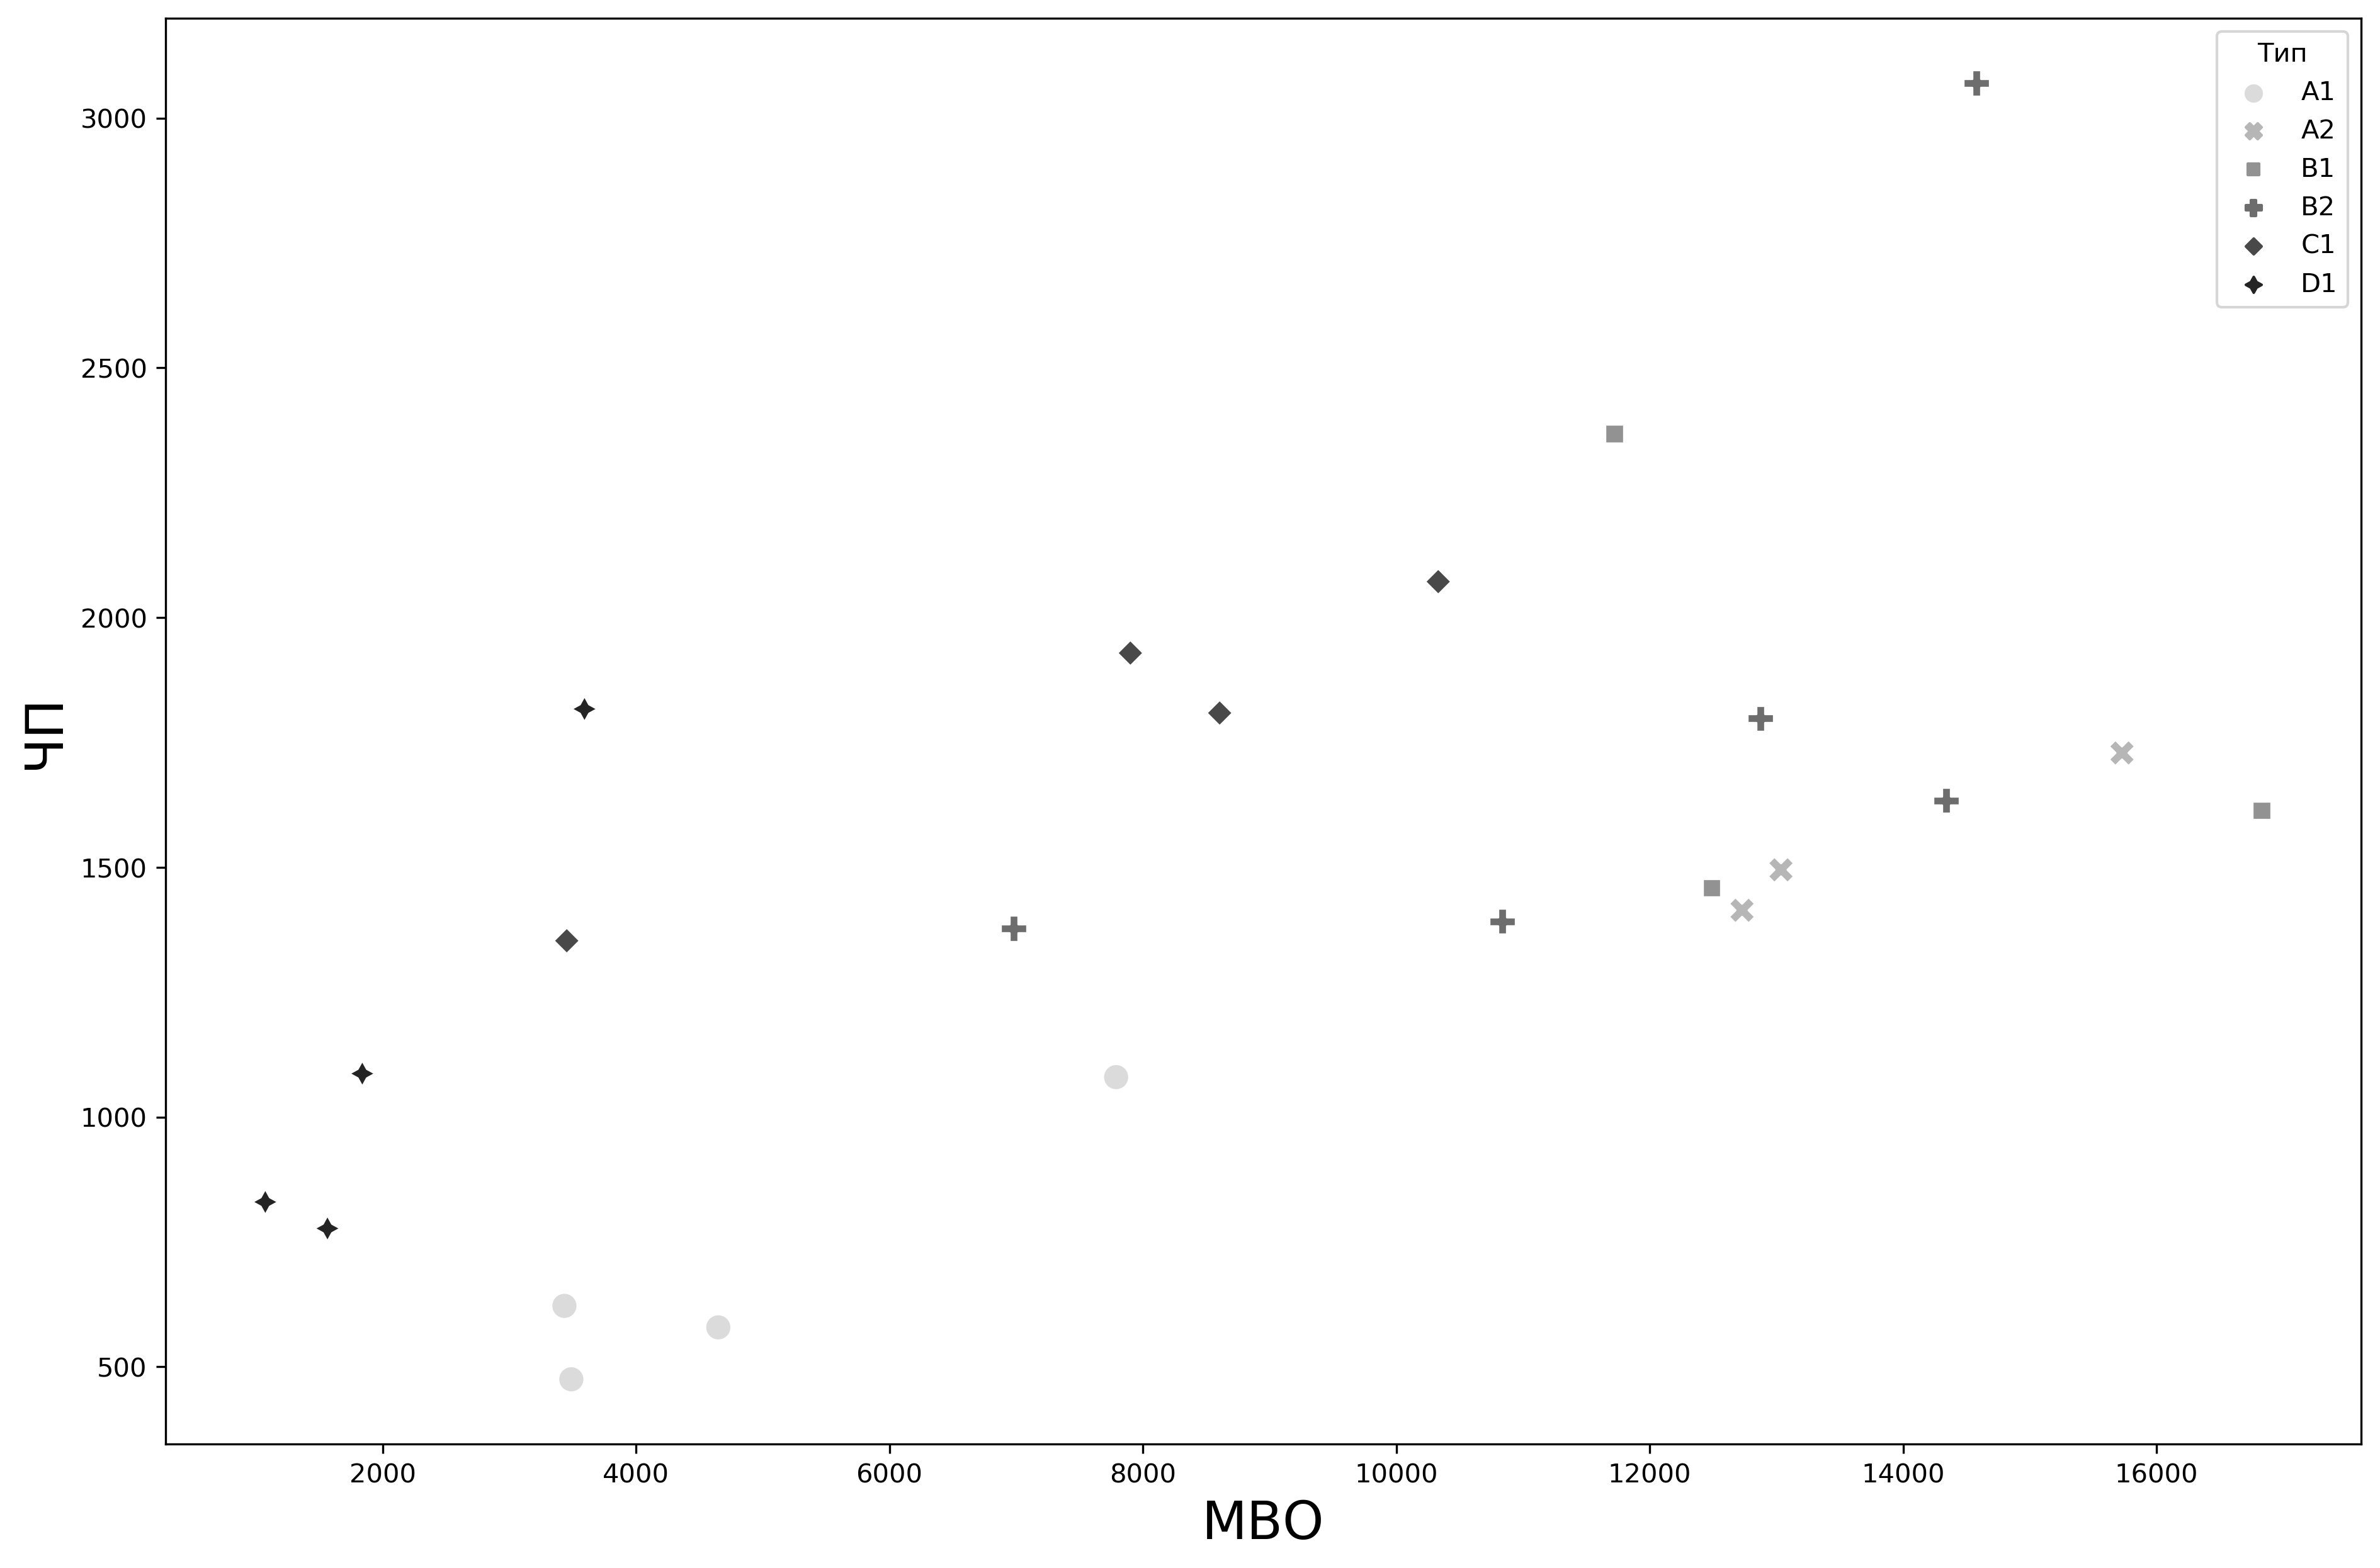

In [46]:
scatter_plot(data, "МВО", "ЧП")

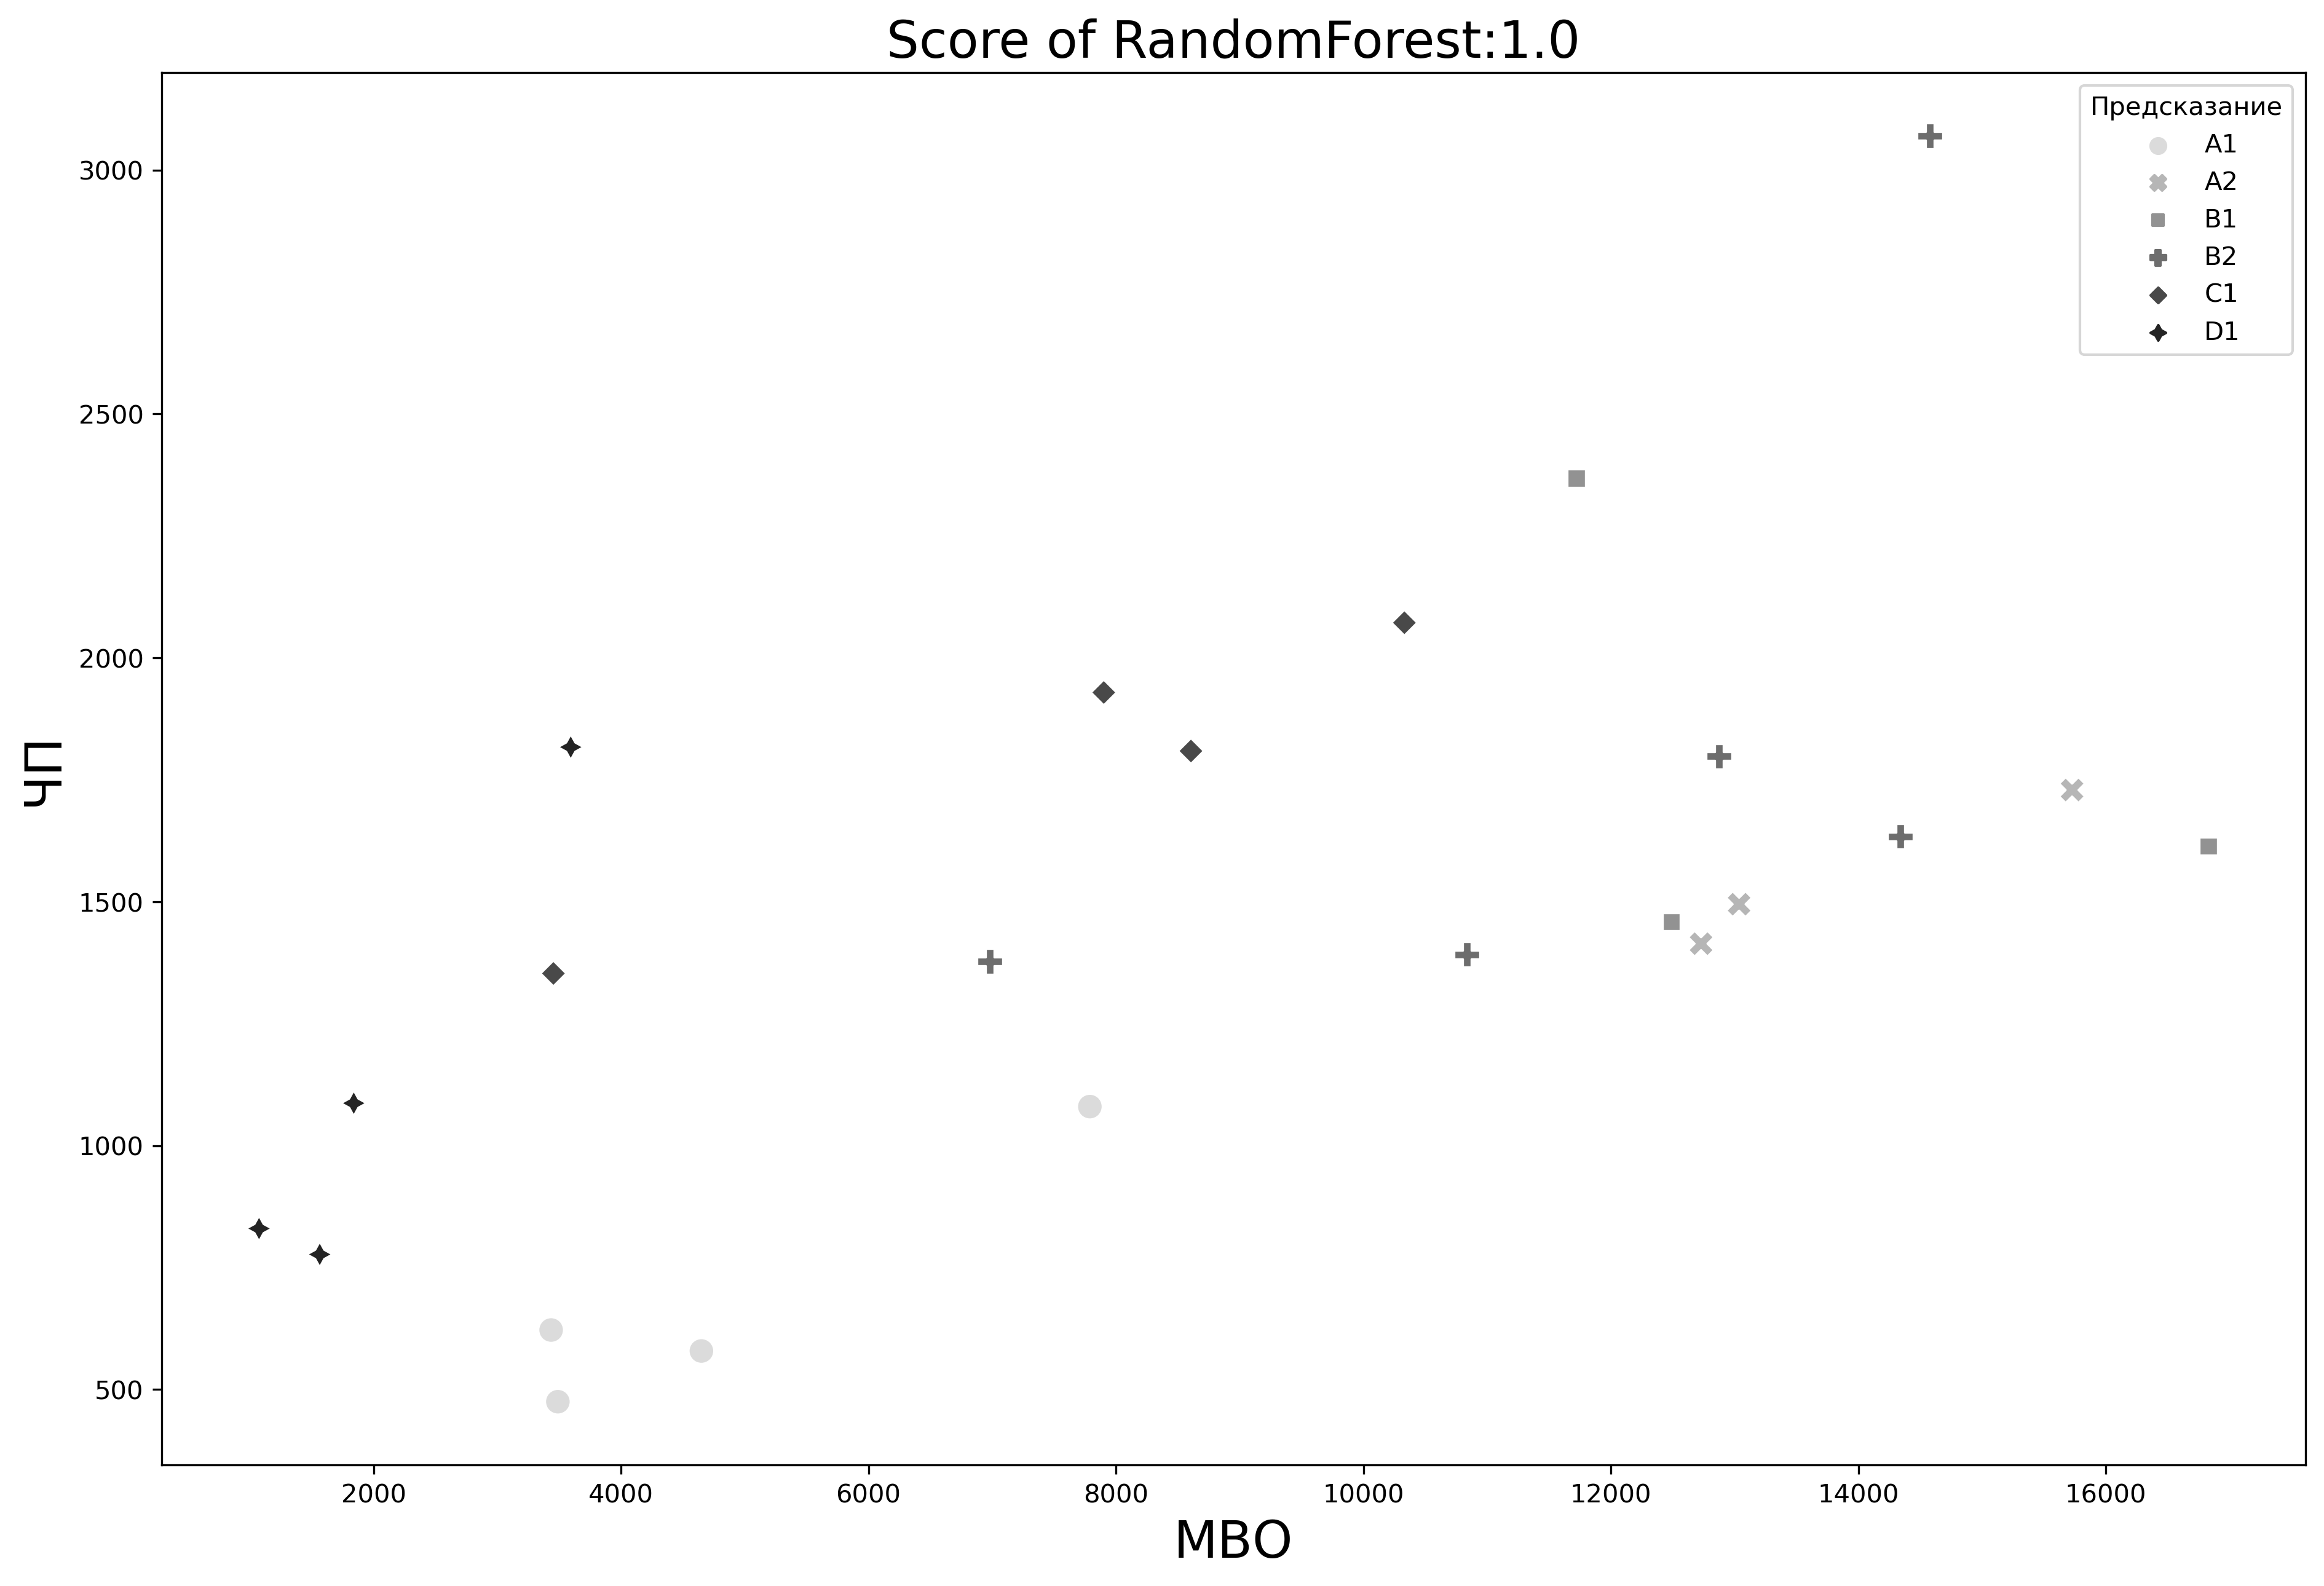

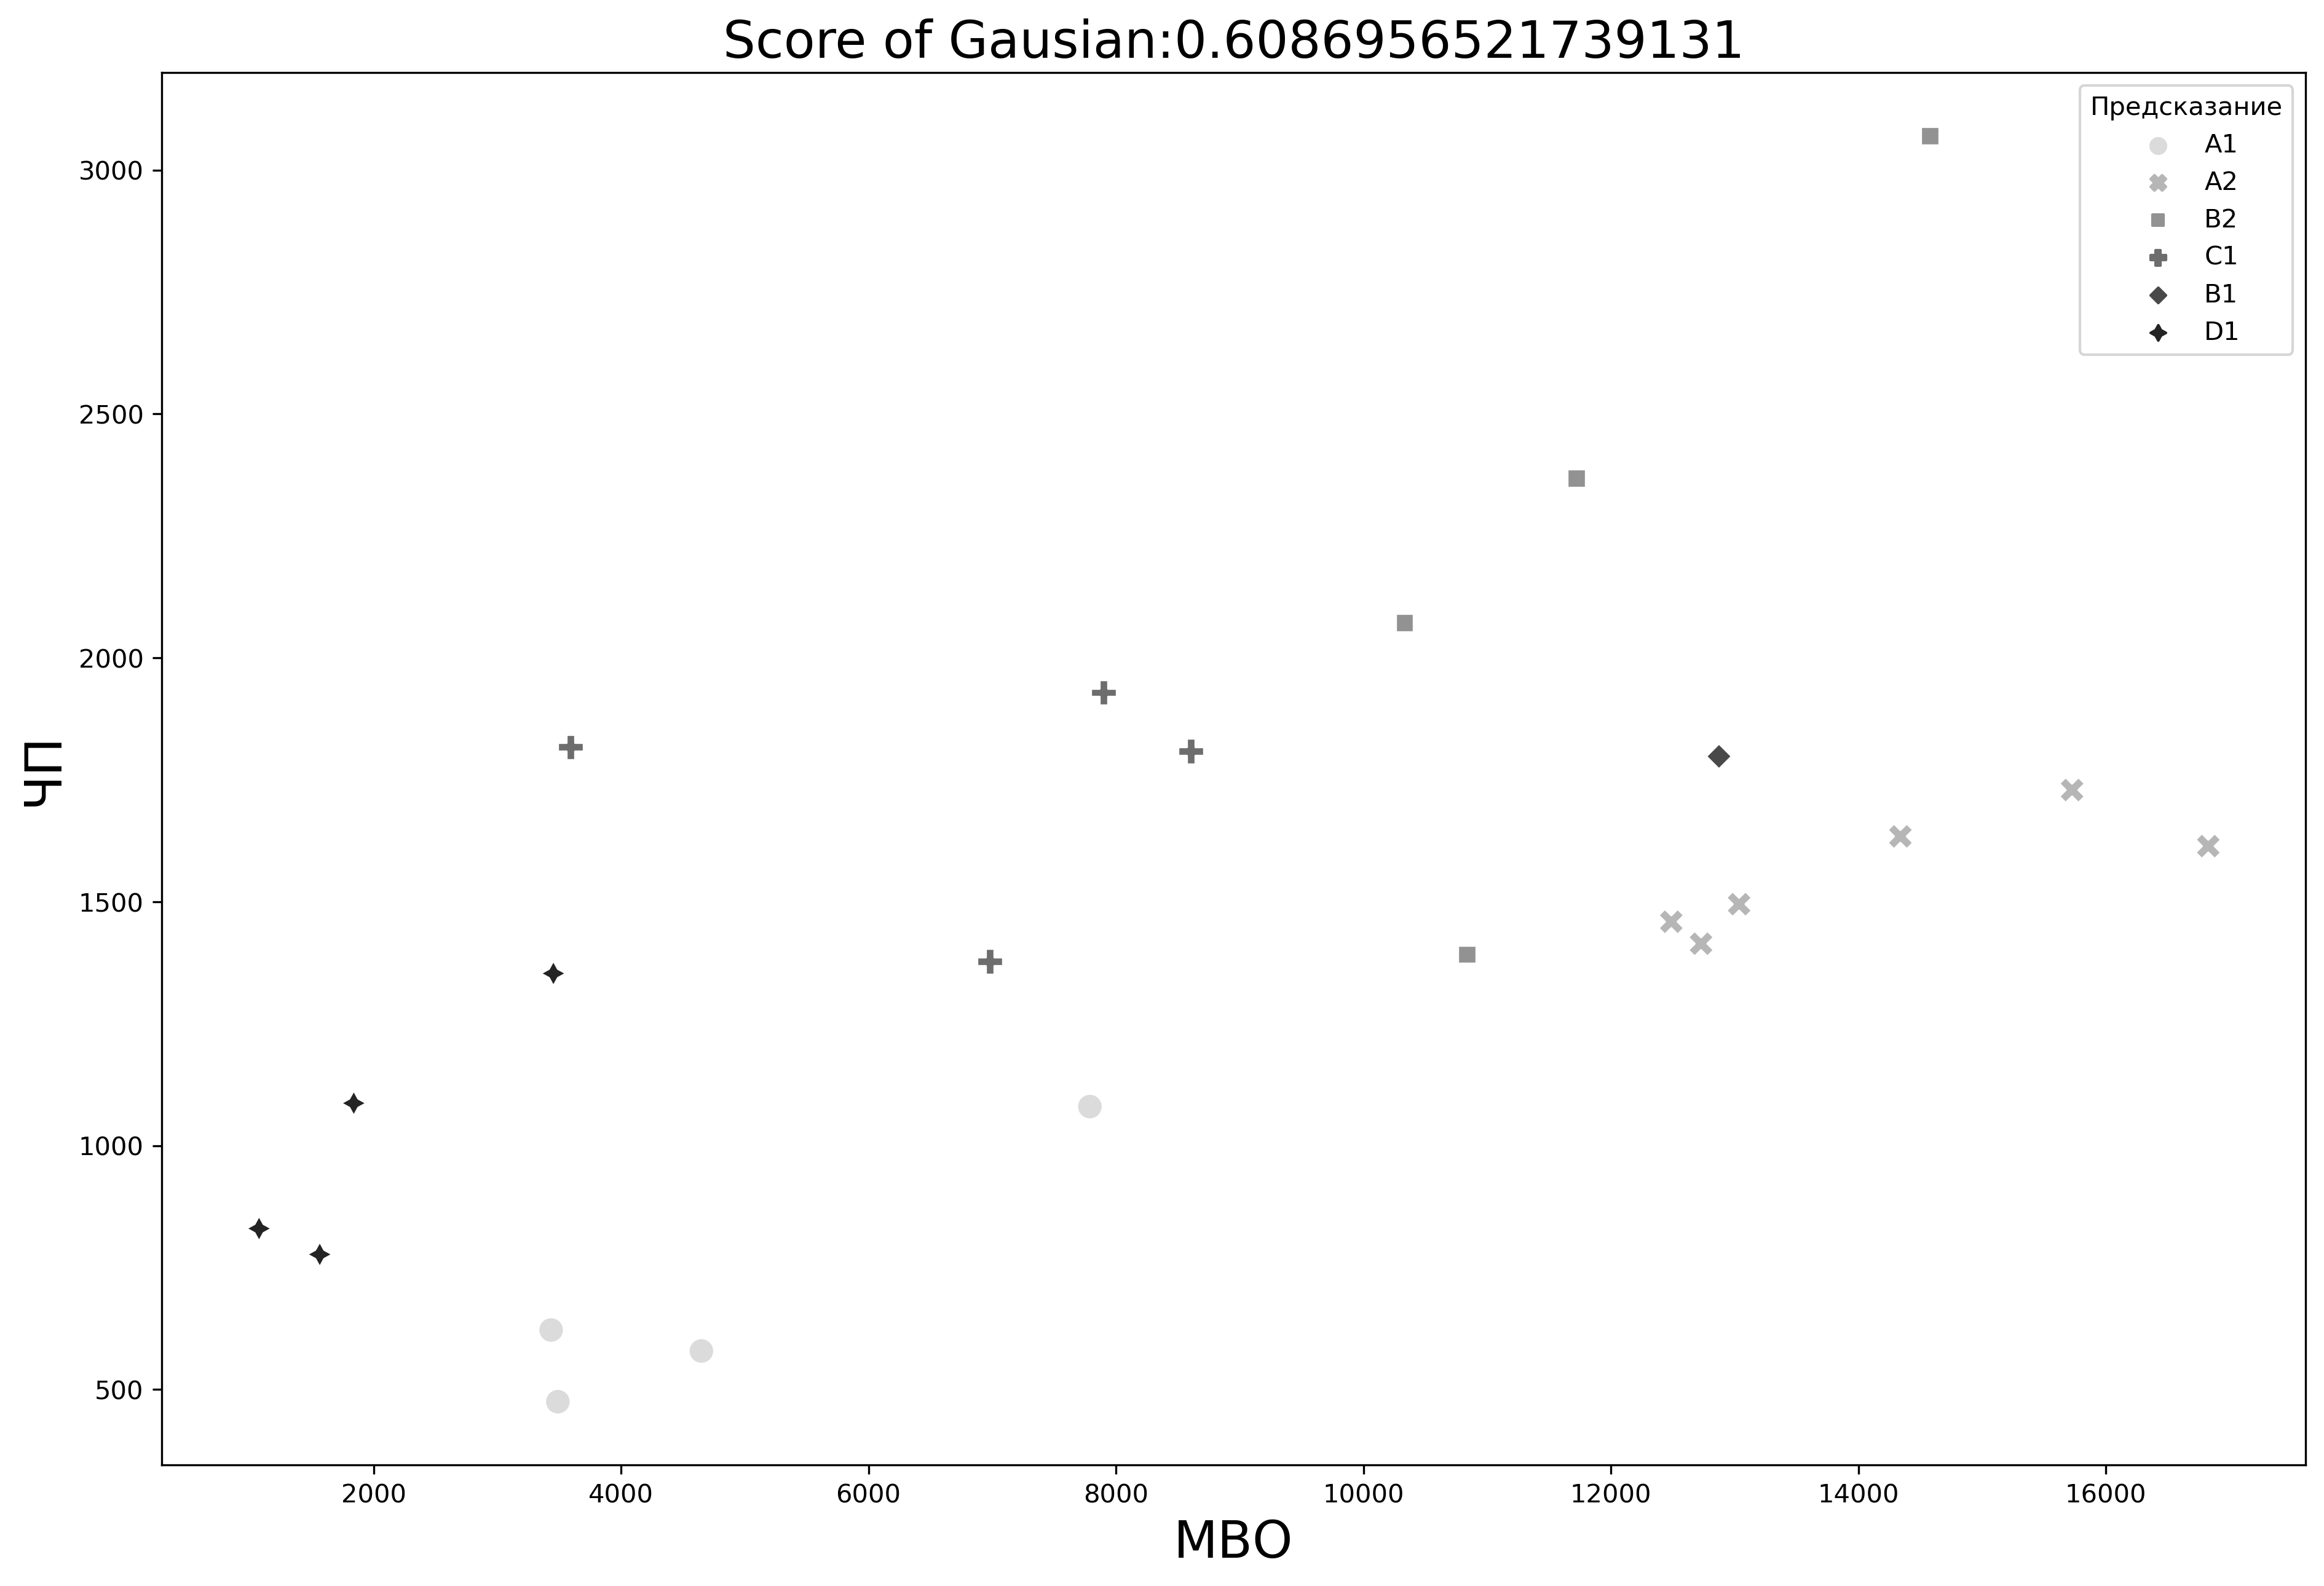

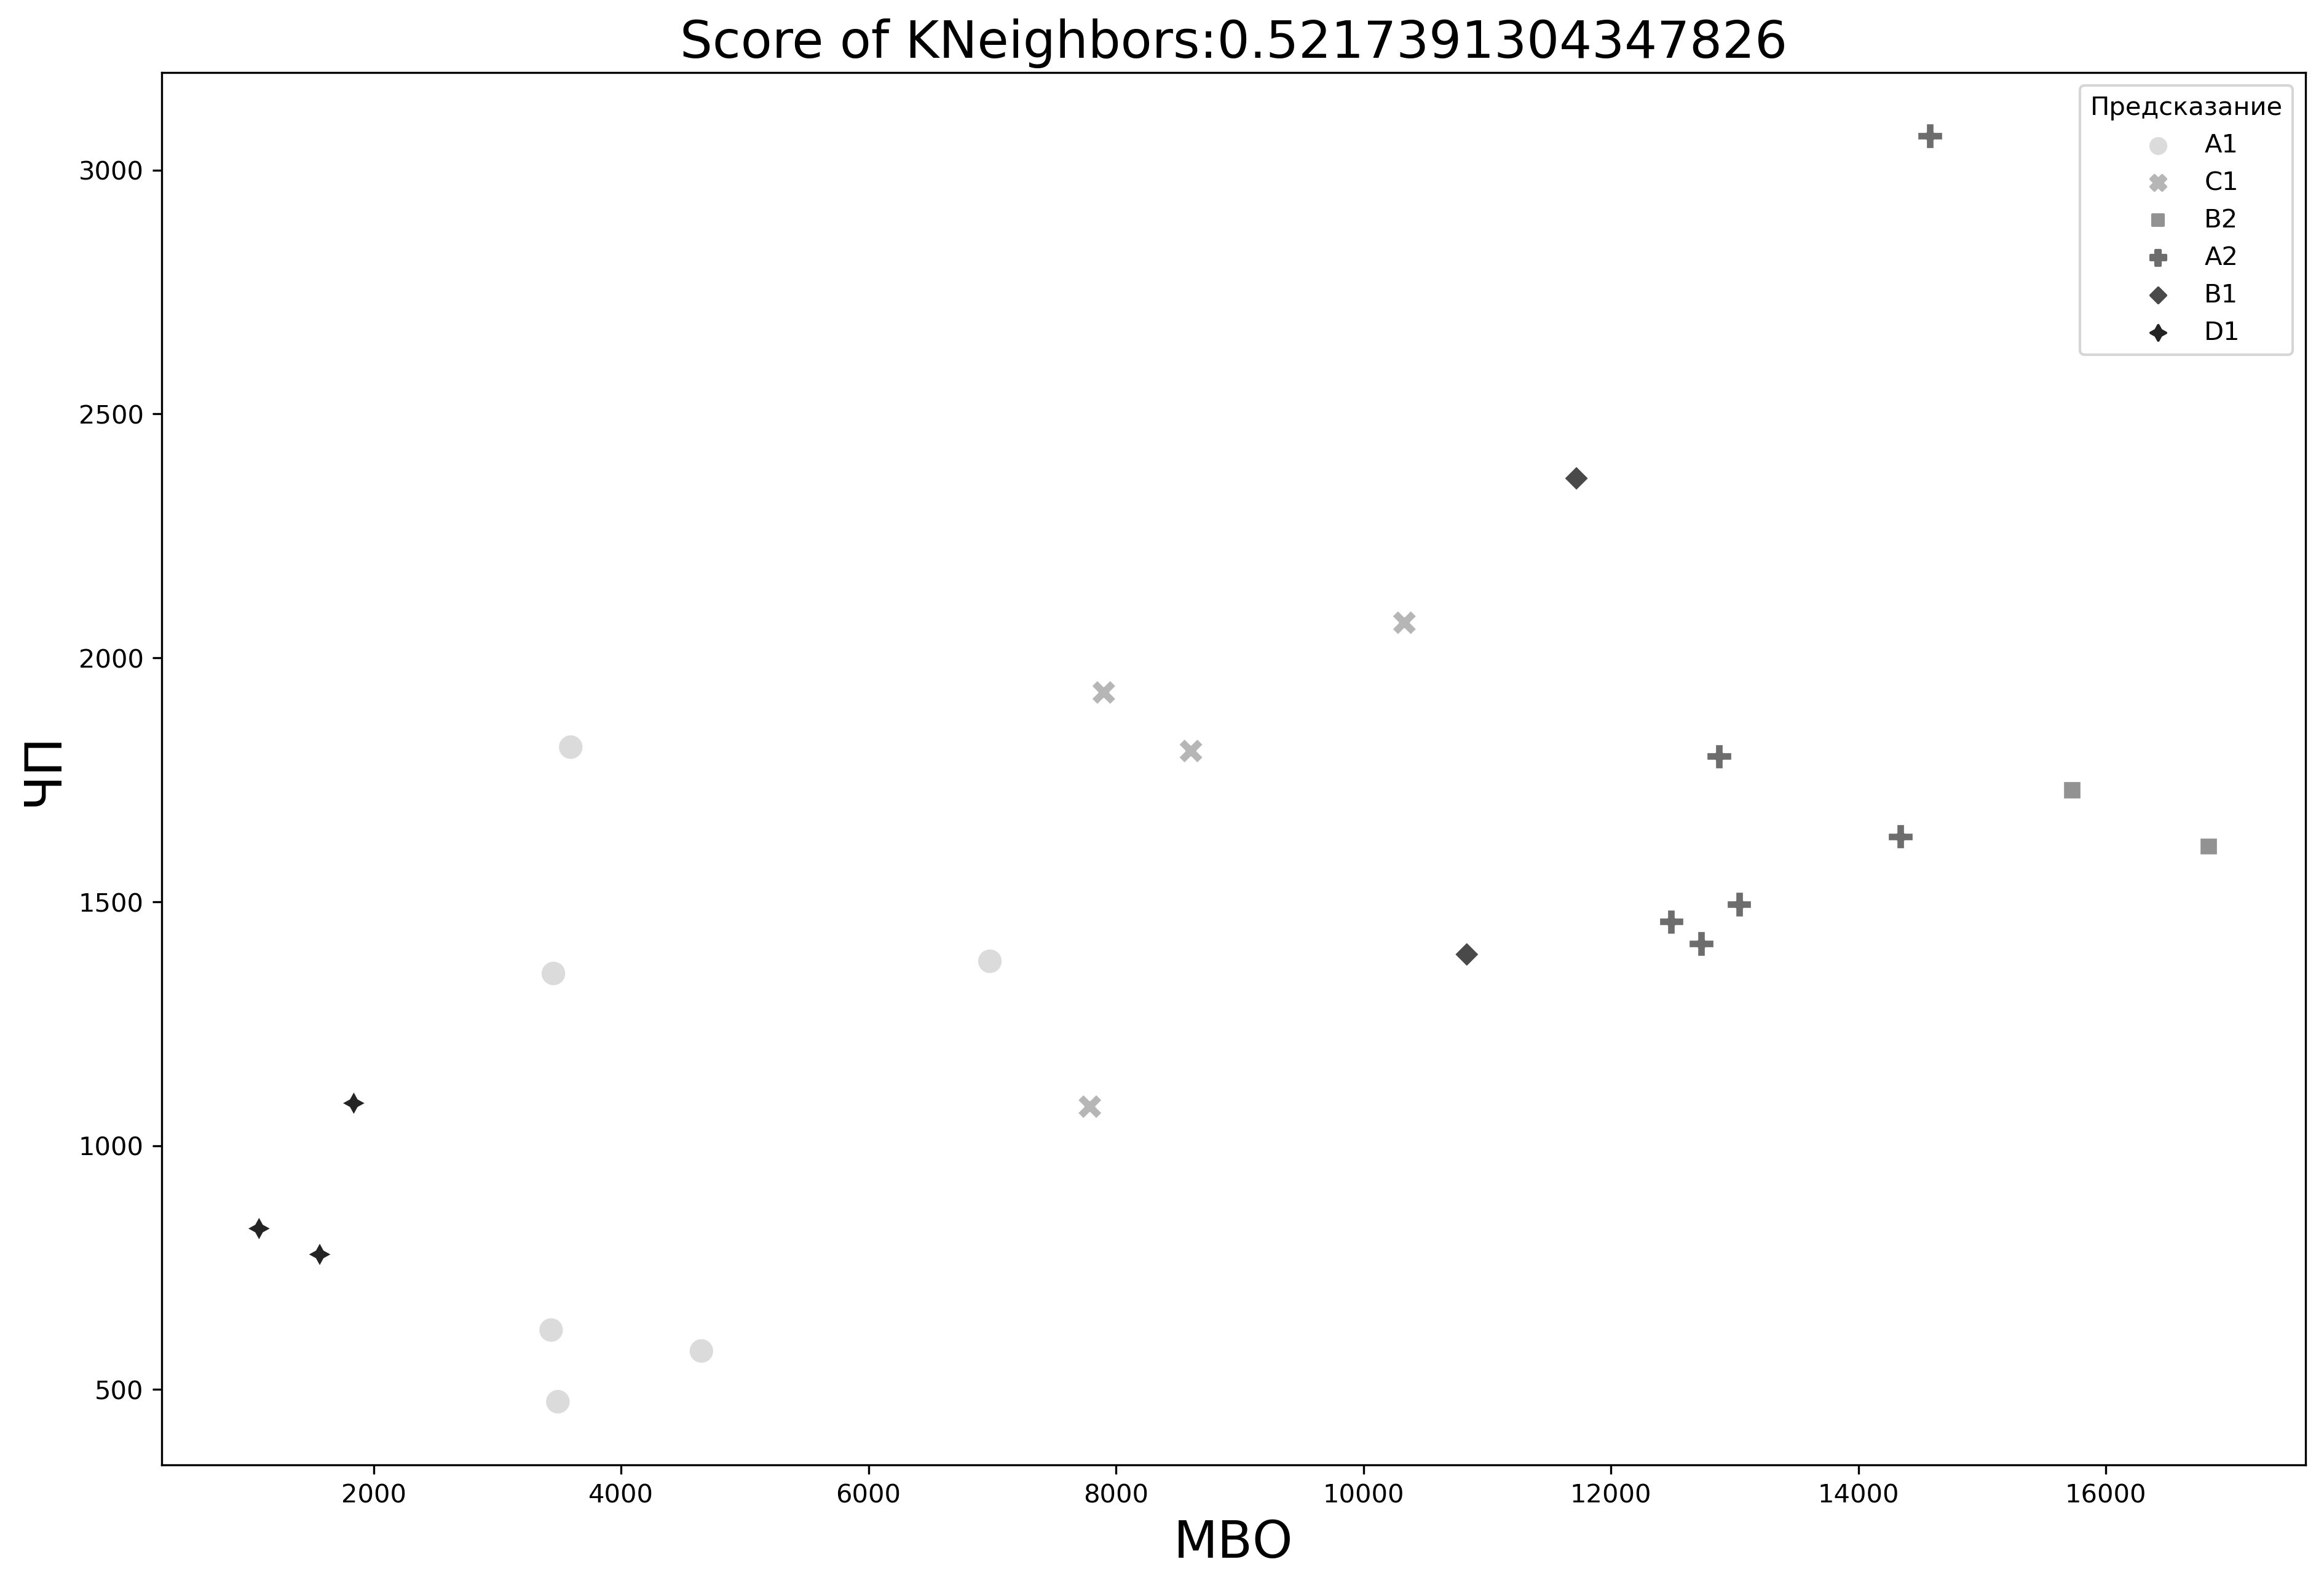

In [47]:
for i, clf in algs().items():
    alg_comparison(data, "МВО", "ЧП", i, clf)    

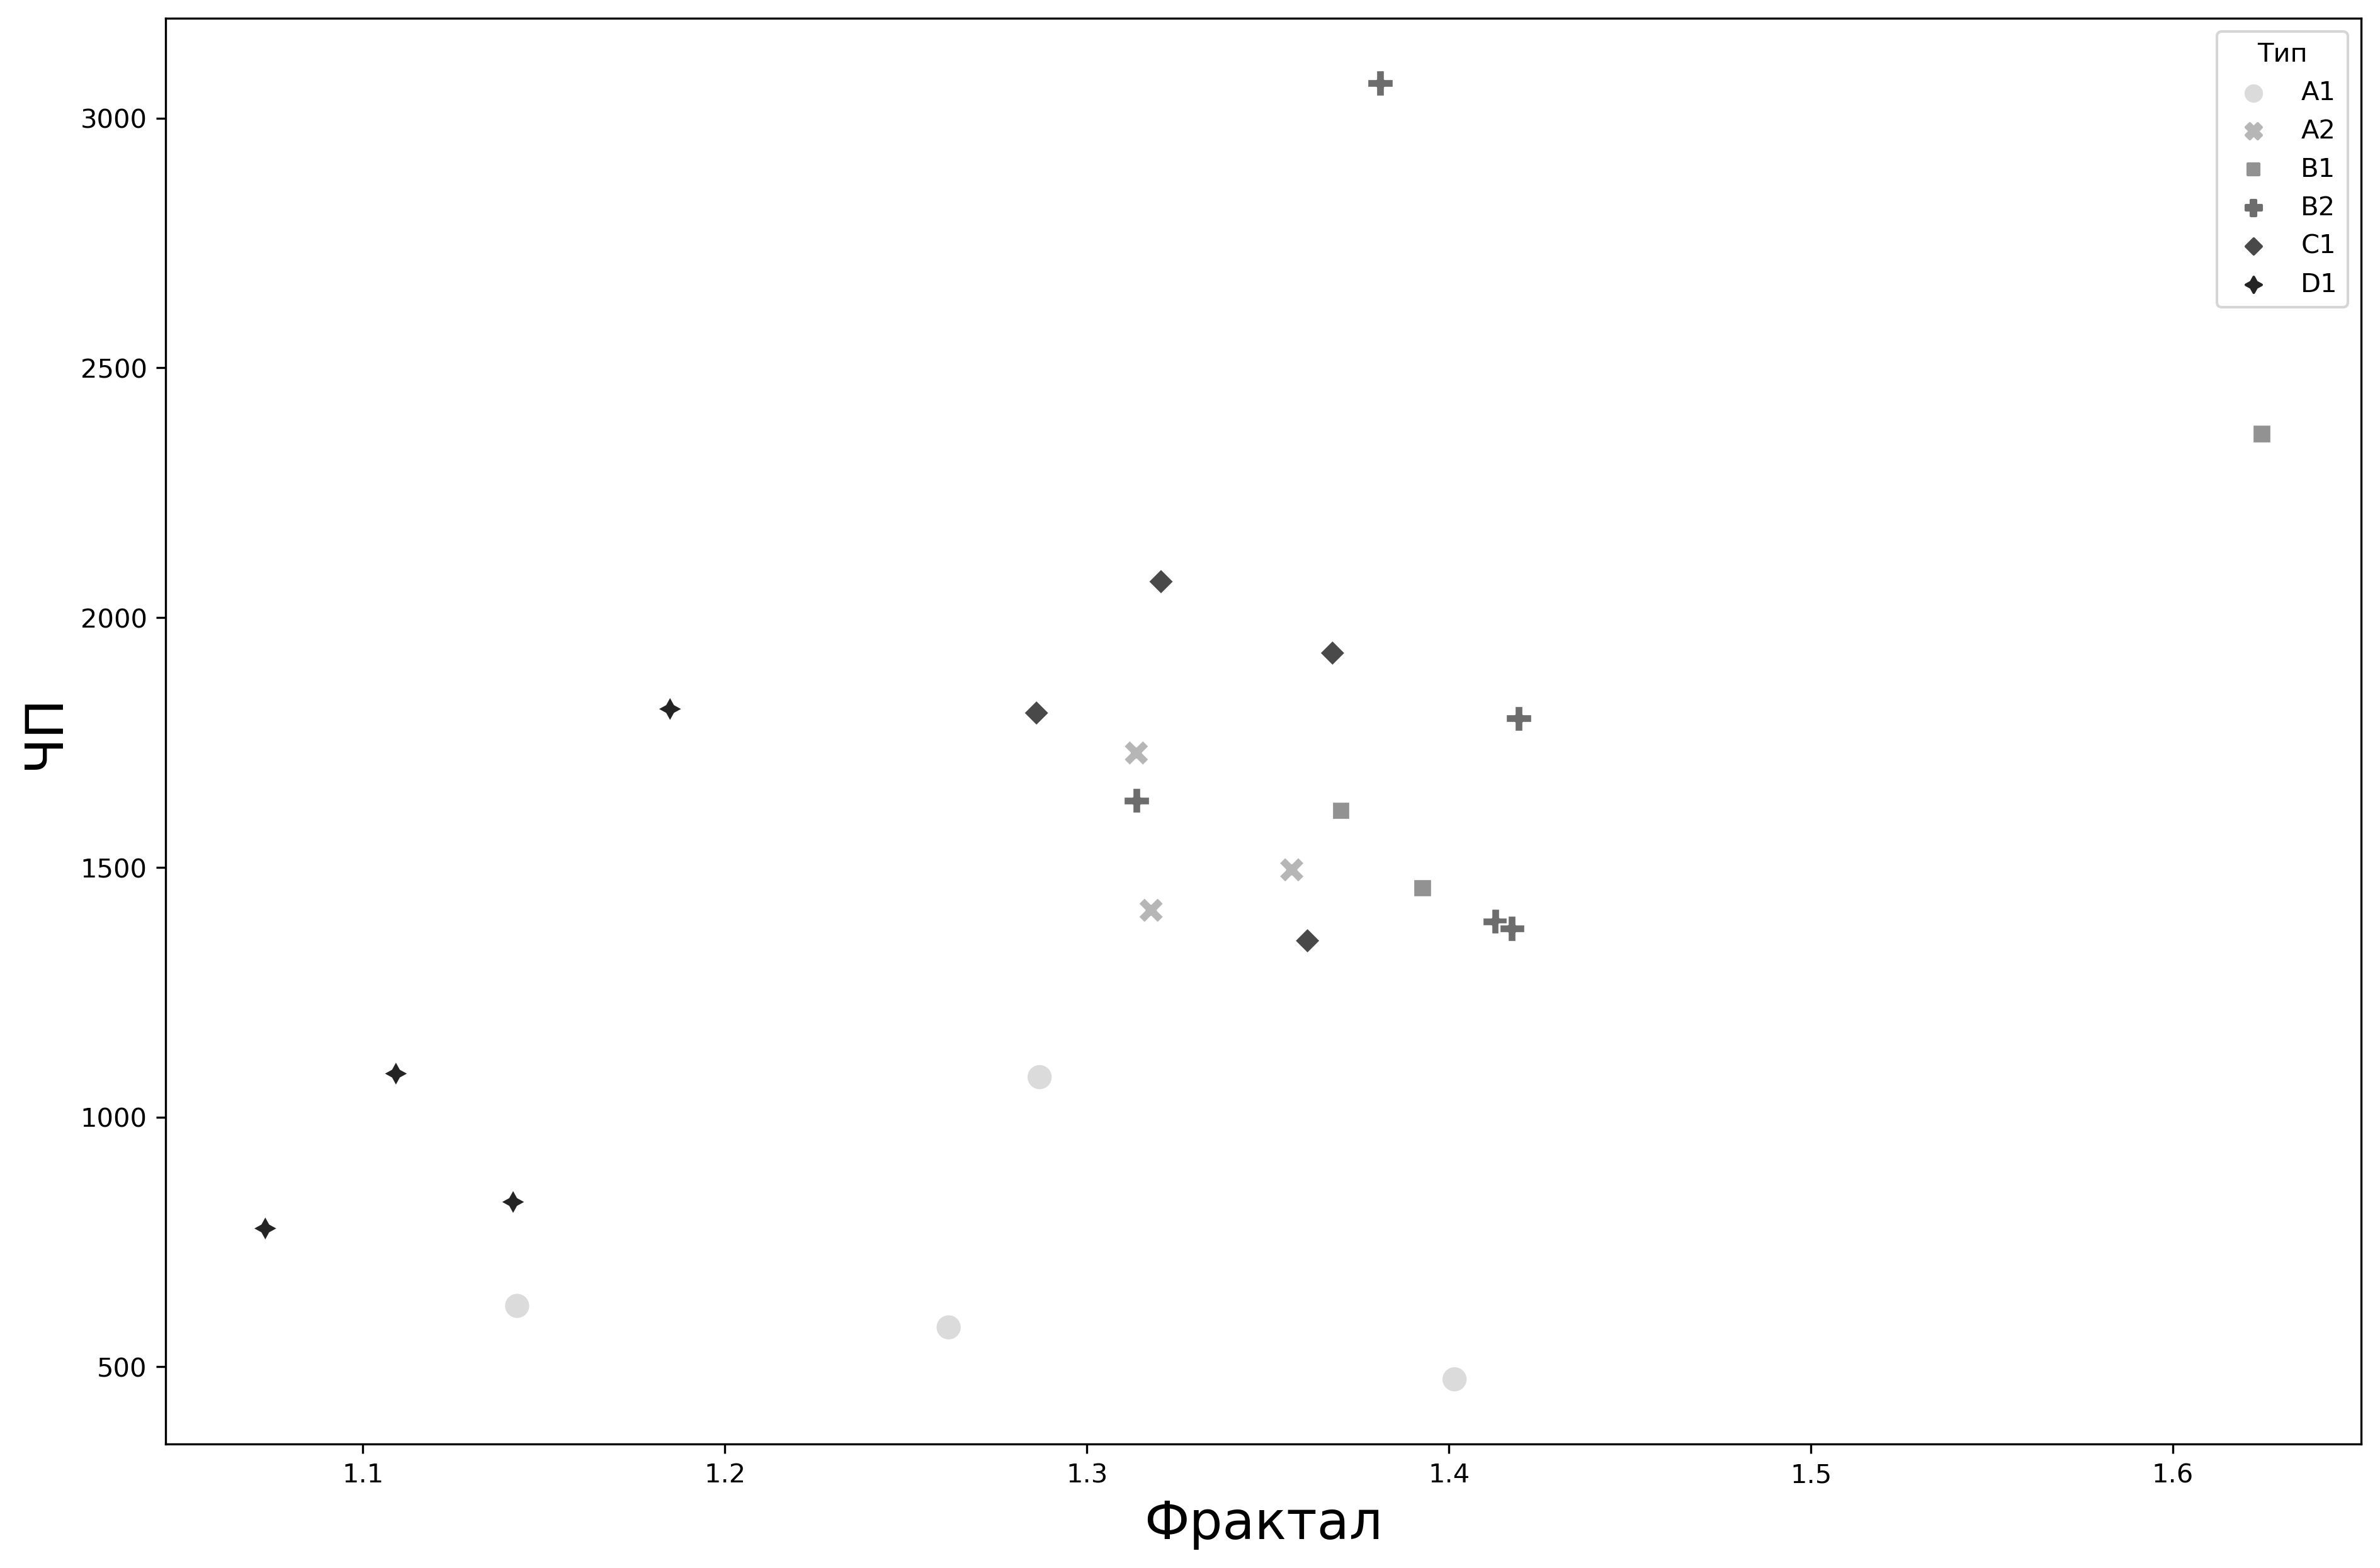

In [48]:
scatter_plot(data, "Фрактал", "ЧП")

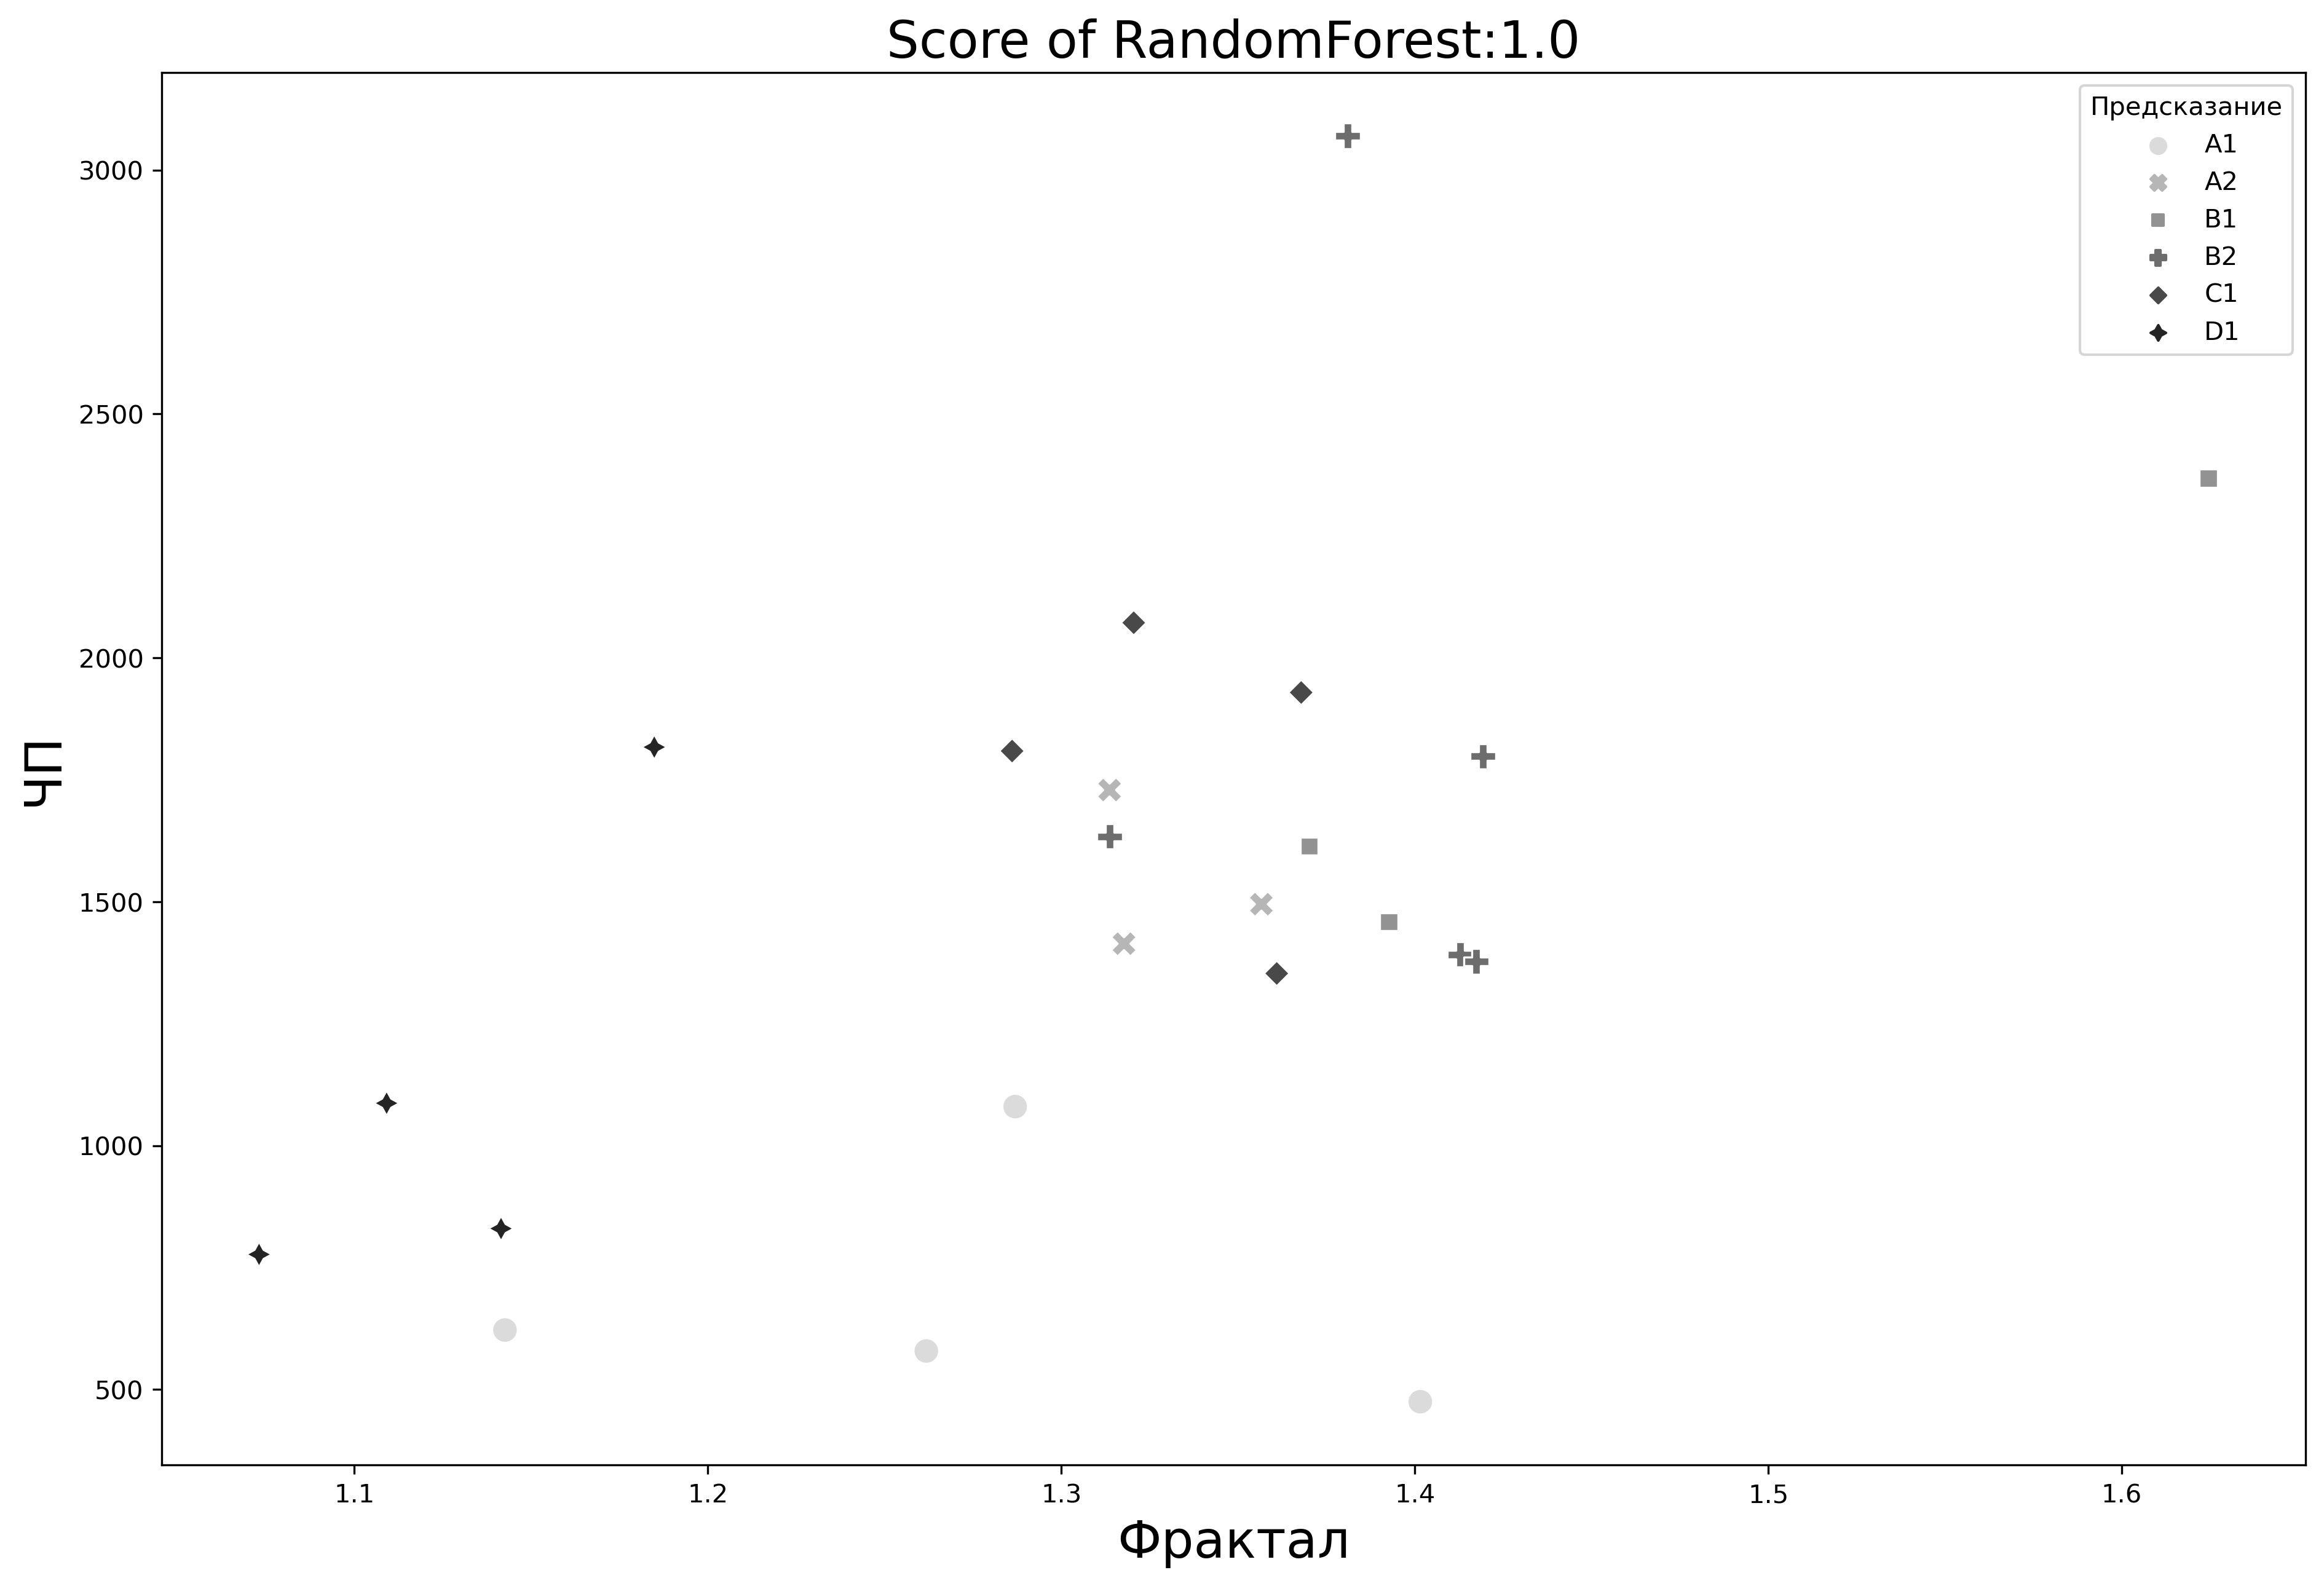

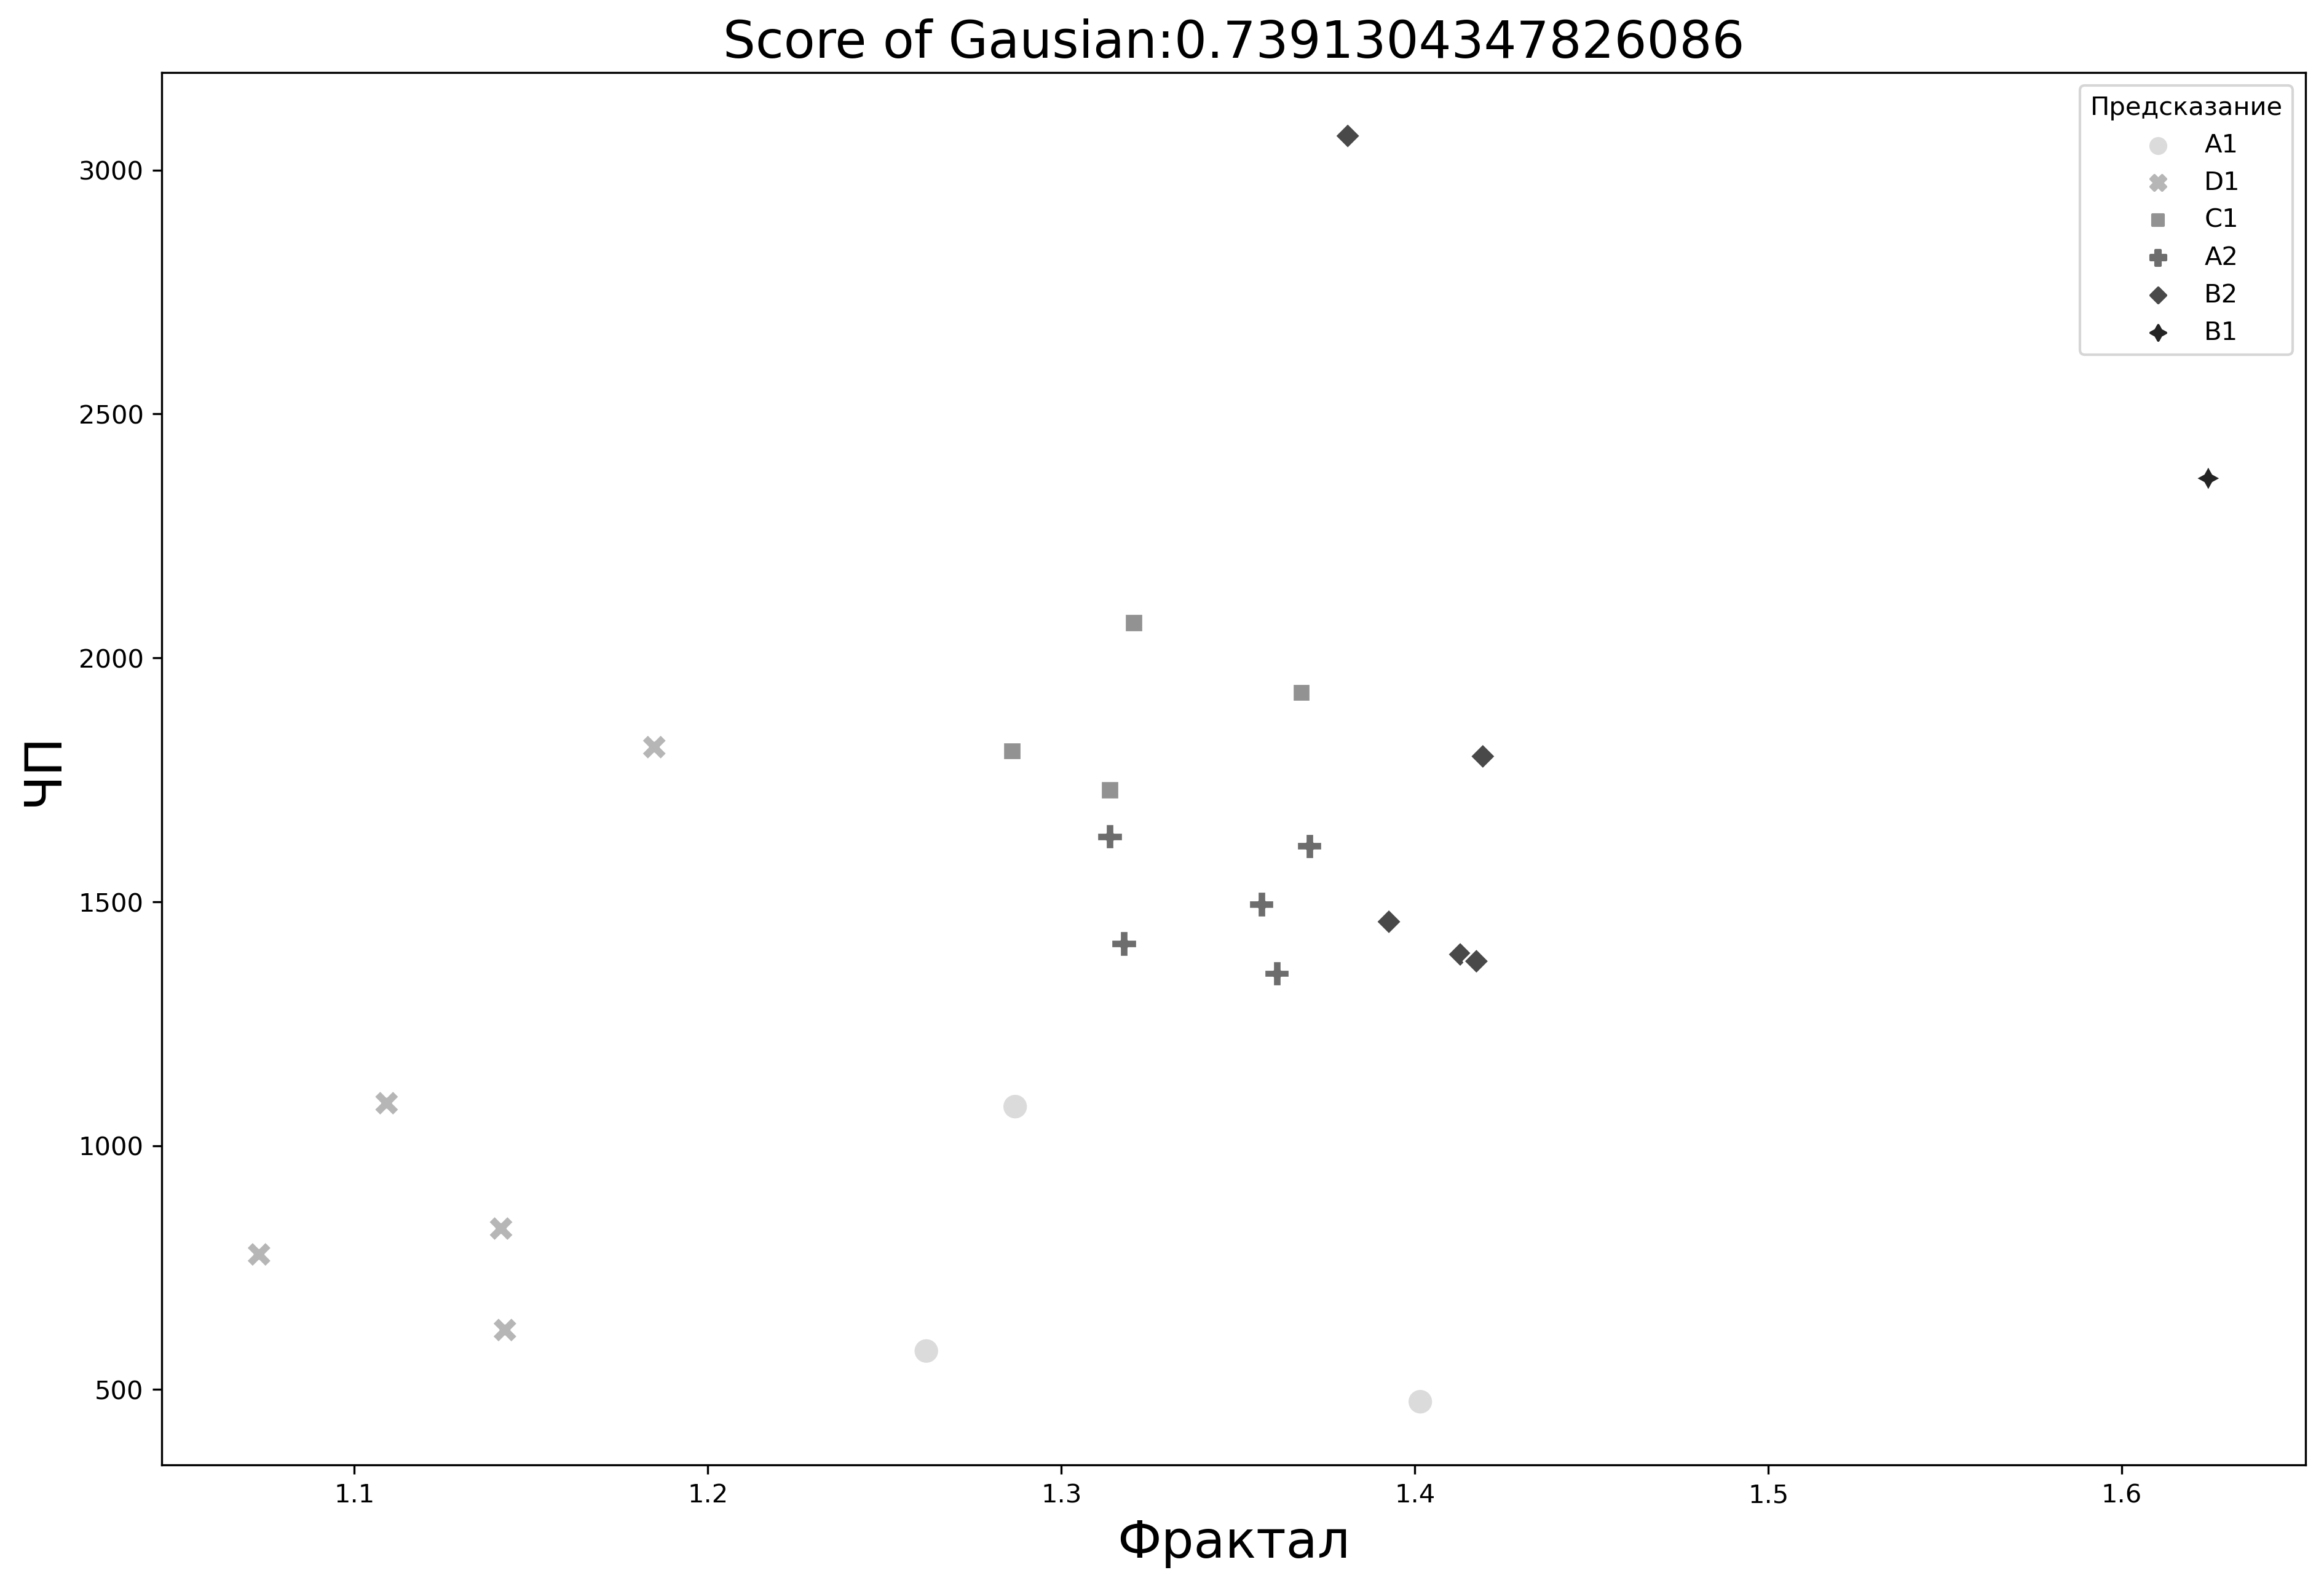

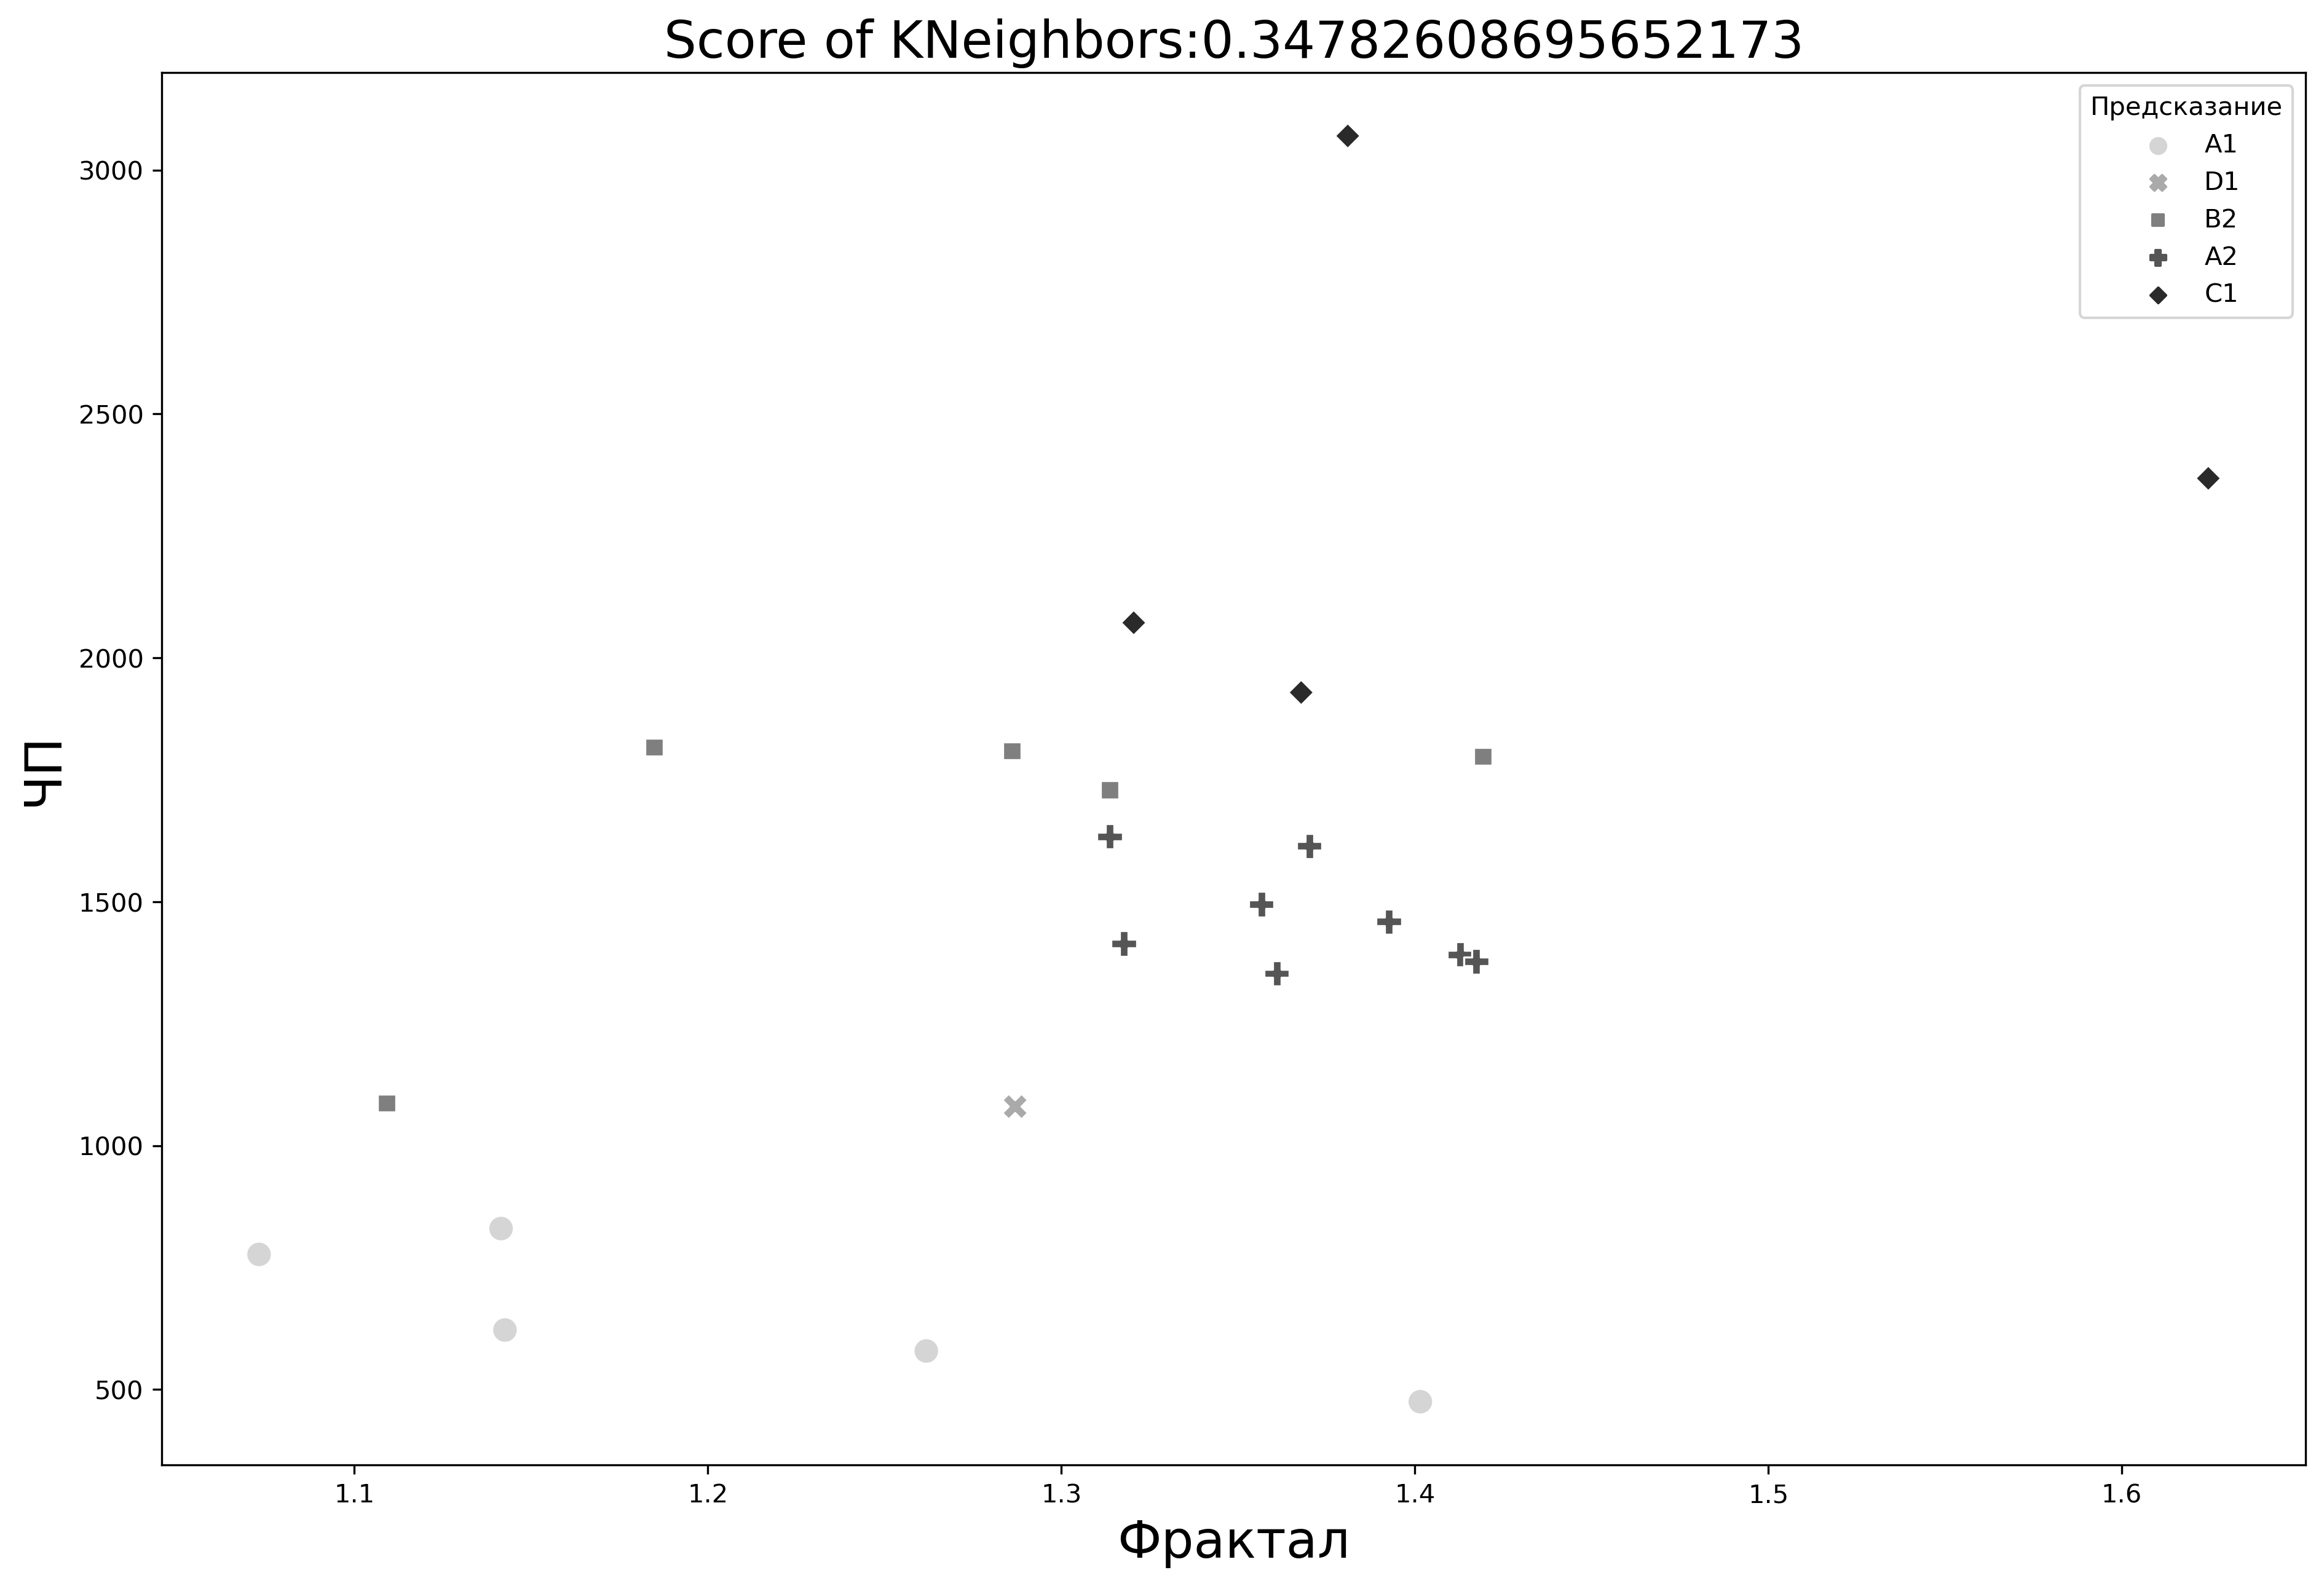

In [49]:
for i, clf in algs().items():
    alg_comparison(data, "Фрактал", "ЧП", i, clf)    

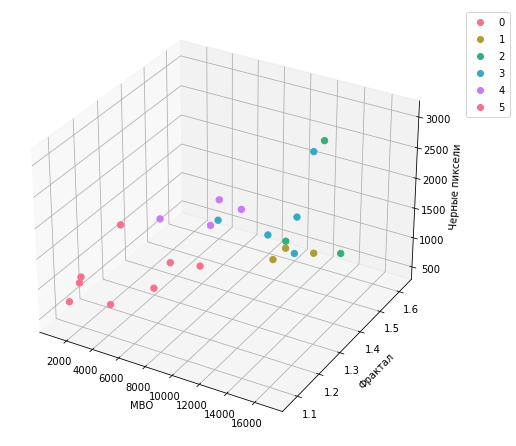

In [50]:
# %matplotlib inline  
# %matplotlib notebook
# %pylab

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

x = data['МВО']
y = data['Фрактал']
z = data['ЧП']

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

sc = ax.scatter(x, y, z, s=40, c=data["Тип"].astype('category').cat.codes, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel("МВО")
ax.set_ylabel("Фрактал")
ax.set_zlabel("Черные пиксели")

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Двумерное пространство данных

In [51]:
data = pd.DataFrame([], columns=["Фрактальная размерность", "Отношение ЧП к МВО","Тип"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        cnts = find_contour(c)
        mvp = jarvismarch(cnts)
        mch = square_polygon(mvp)
        data = data.append({"Фрактальная размерность": fractal_dimension(c), 
                            "Отношение ЧП к МВО": (c!=255).sum()/mch, 
                            "Тип": key}, ignore_index=True)

In [52]:
for i, clf in algs().items():
    clf.fit(data.drop(["Тип"],axis=1), data["Тип"])
    print("score of "+i+" is "+str(clf.score(data.drop(["Тип"],axis=1), data["Тип"])))

score of RandomForest is 1.0
score of Gausian is 0.8260869565217391
score of KNeighbors is 0.782608695652174


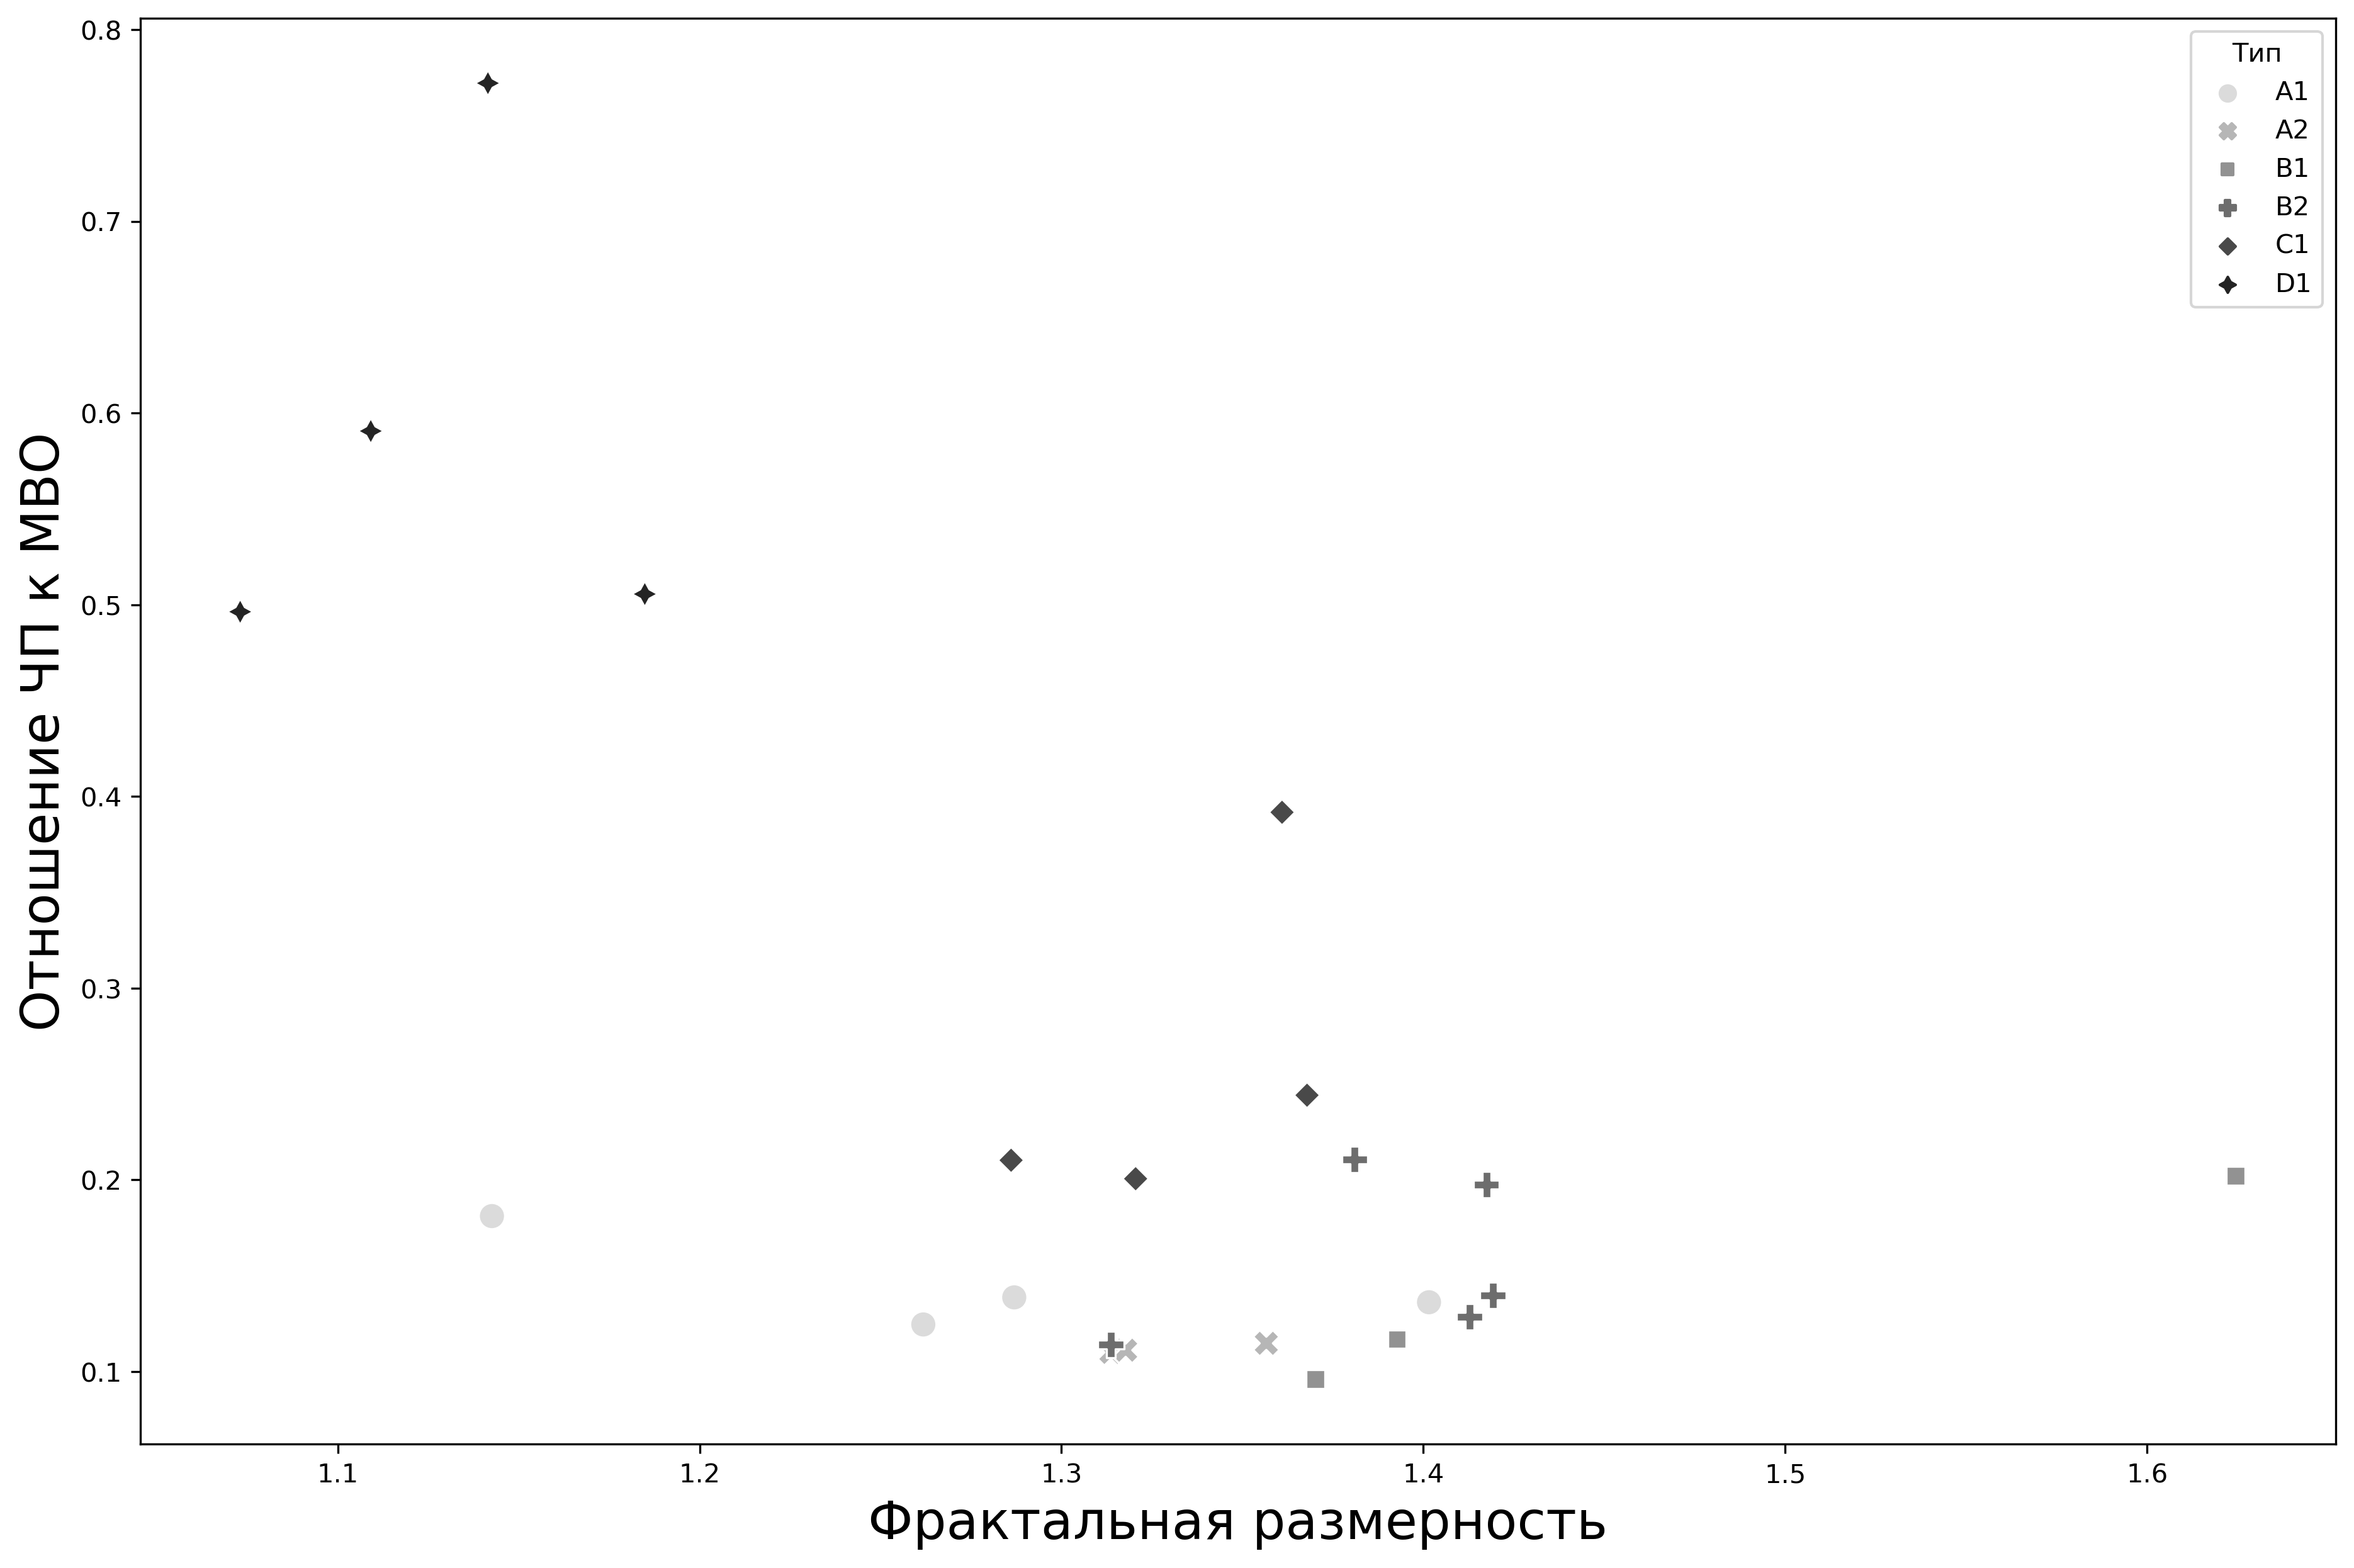

In [37]:
scatter_plot(data, "Фрактальная размерность", "Отношение ЧП к МВО")

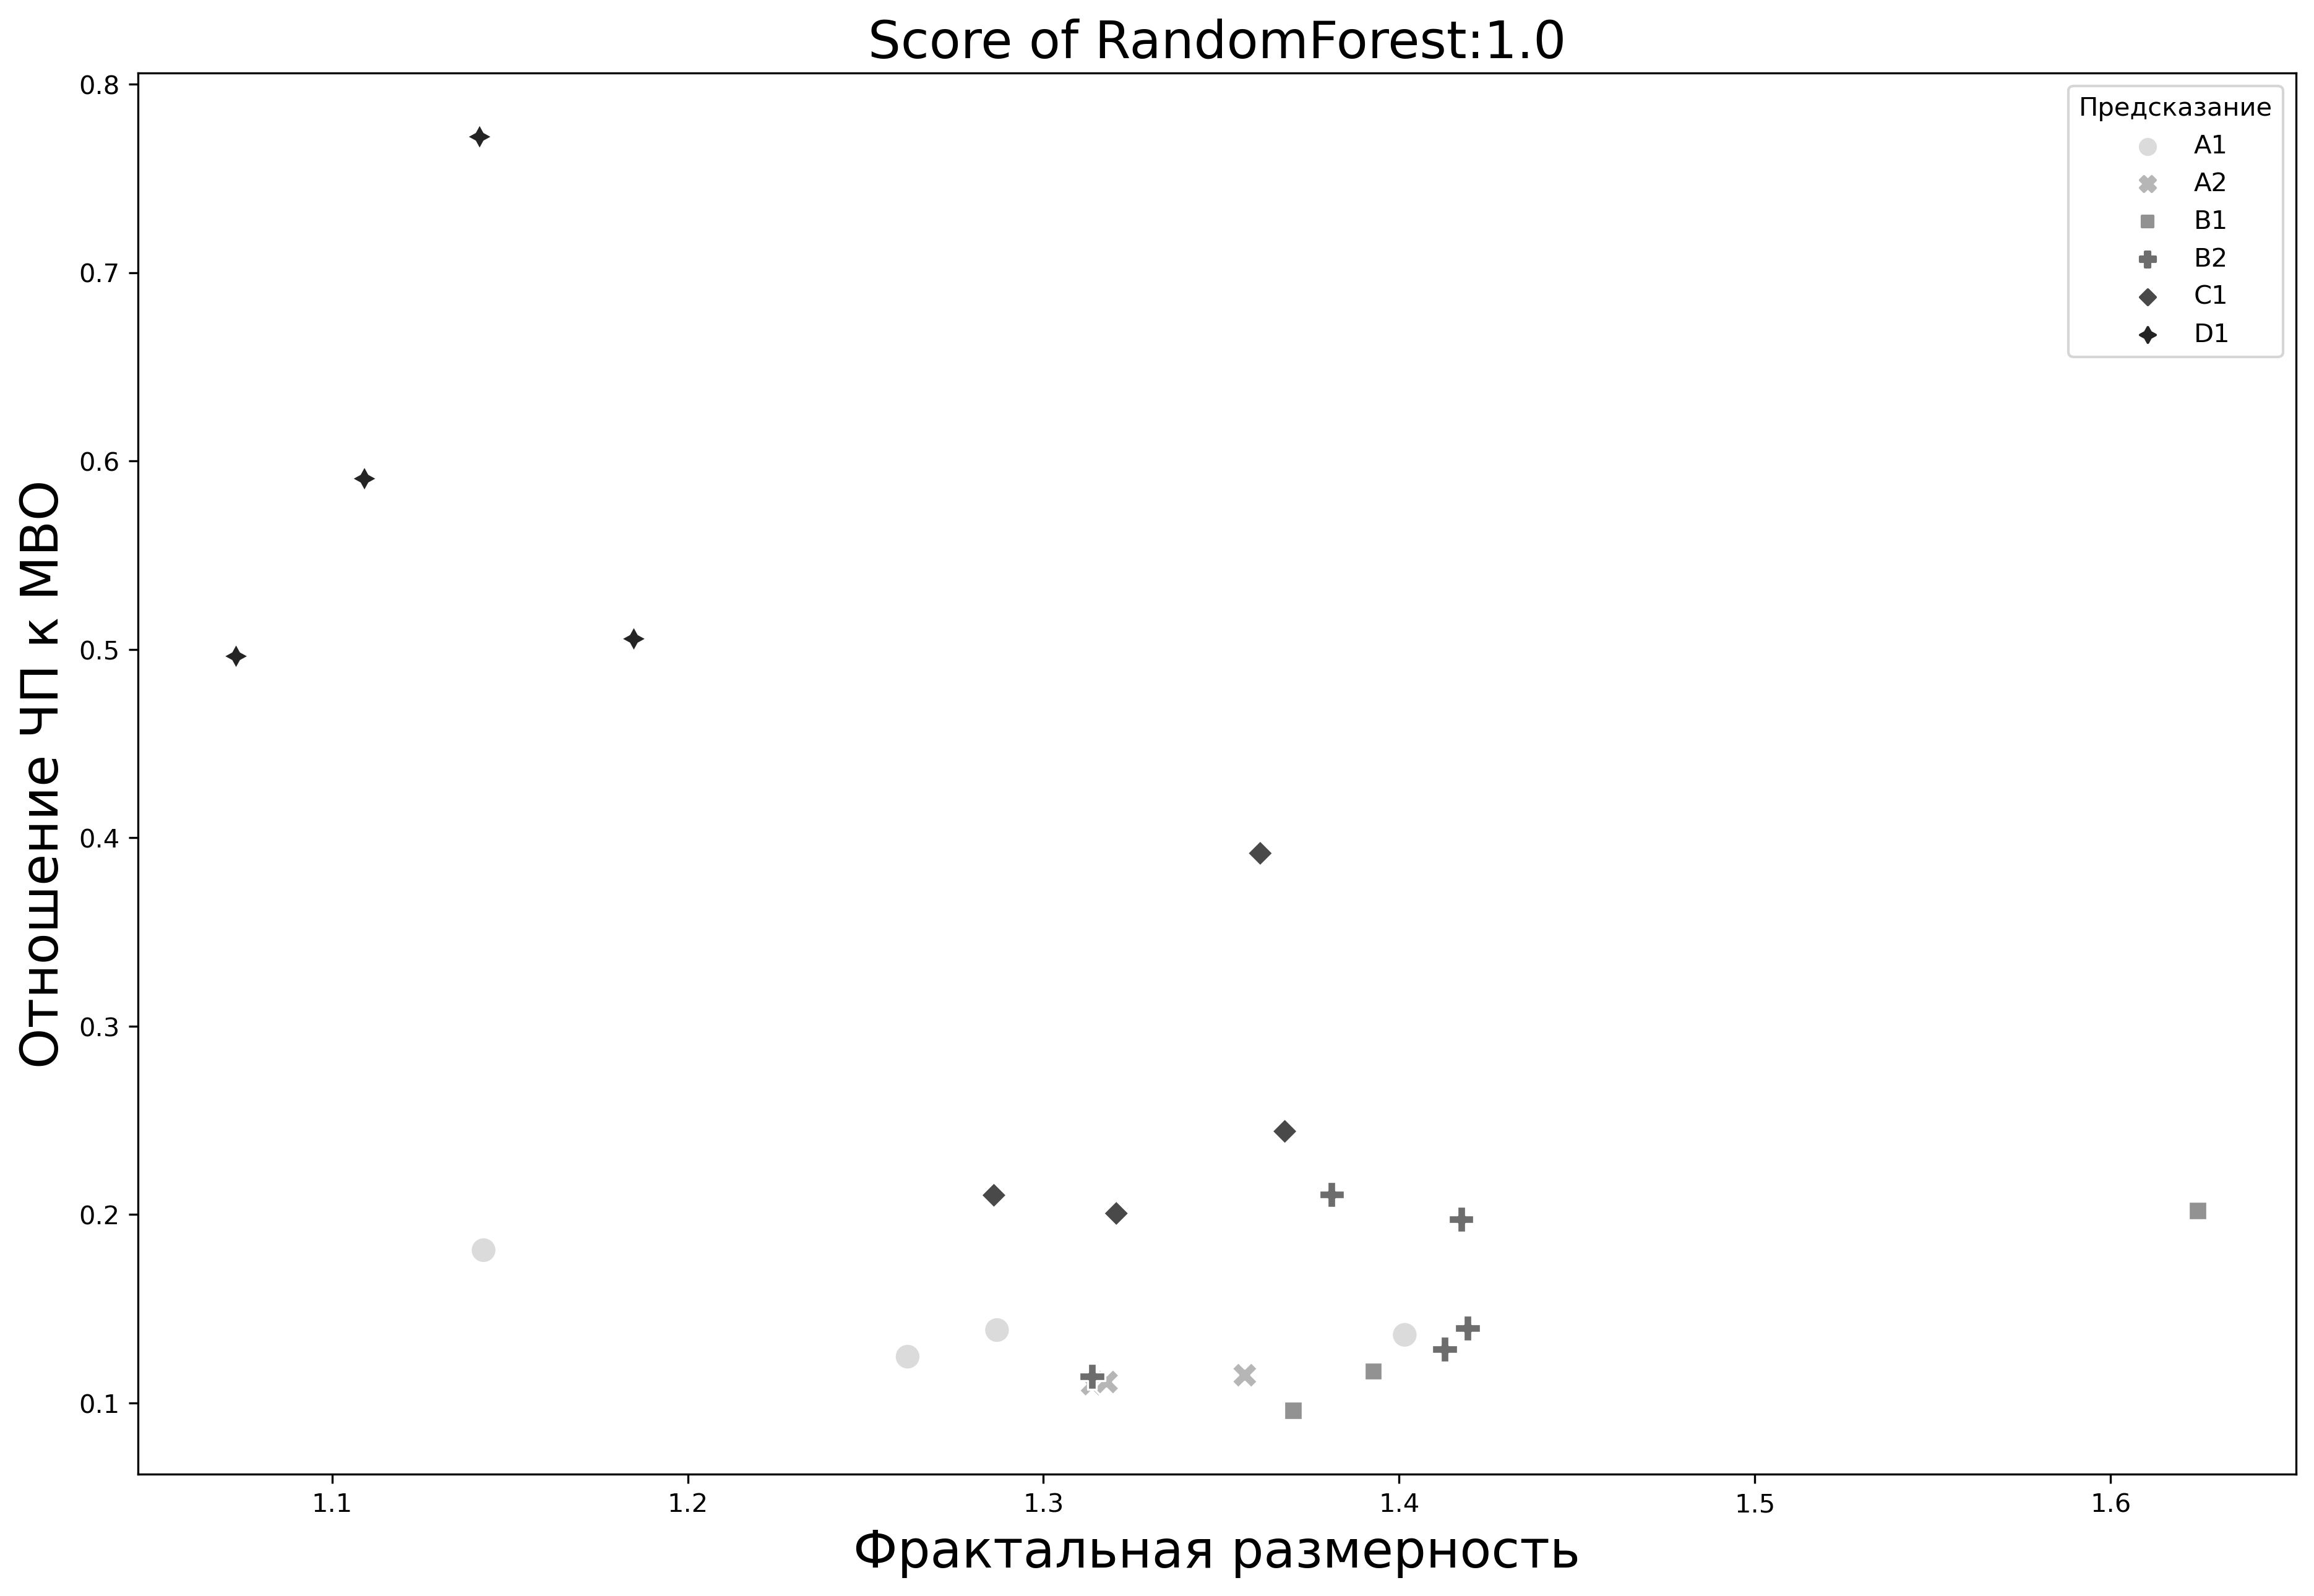

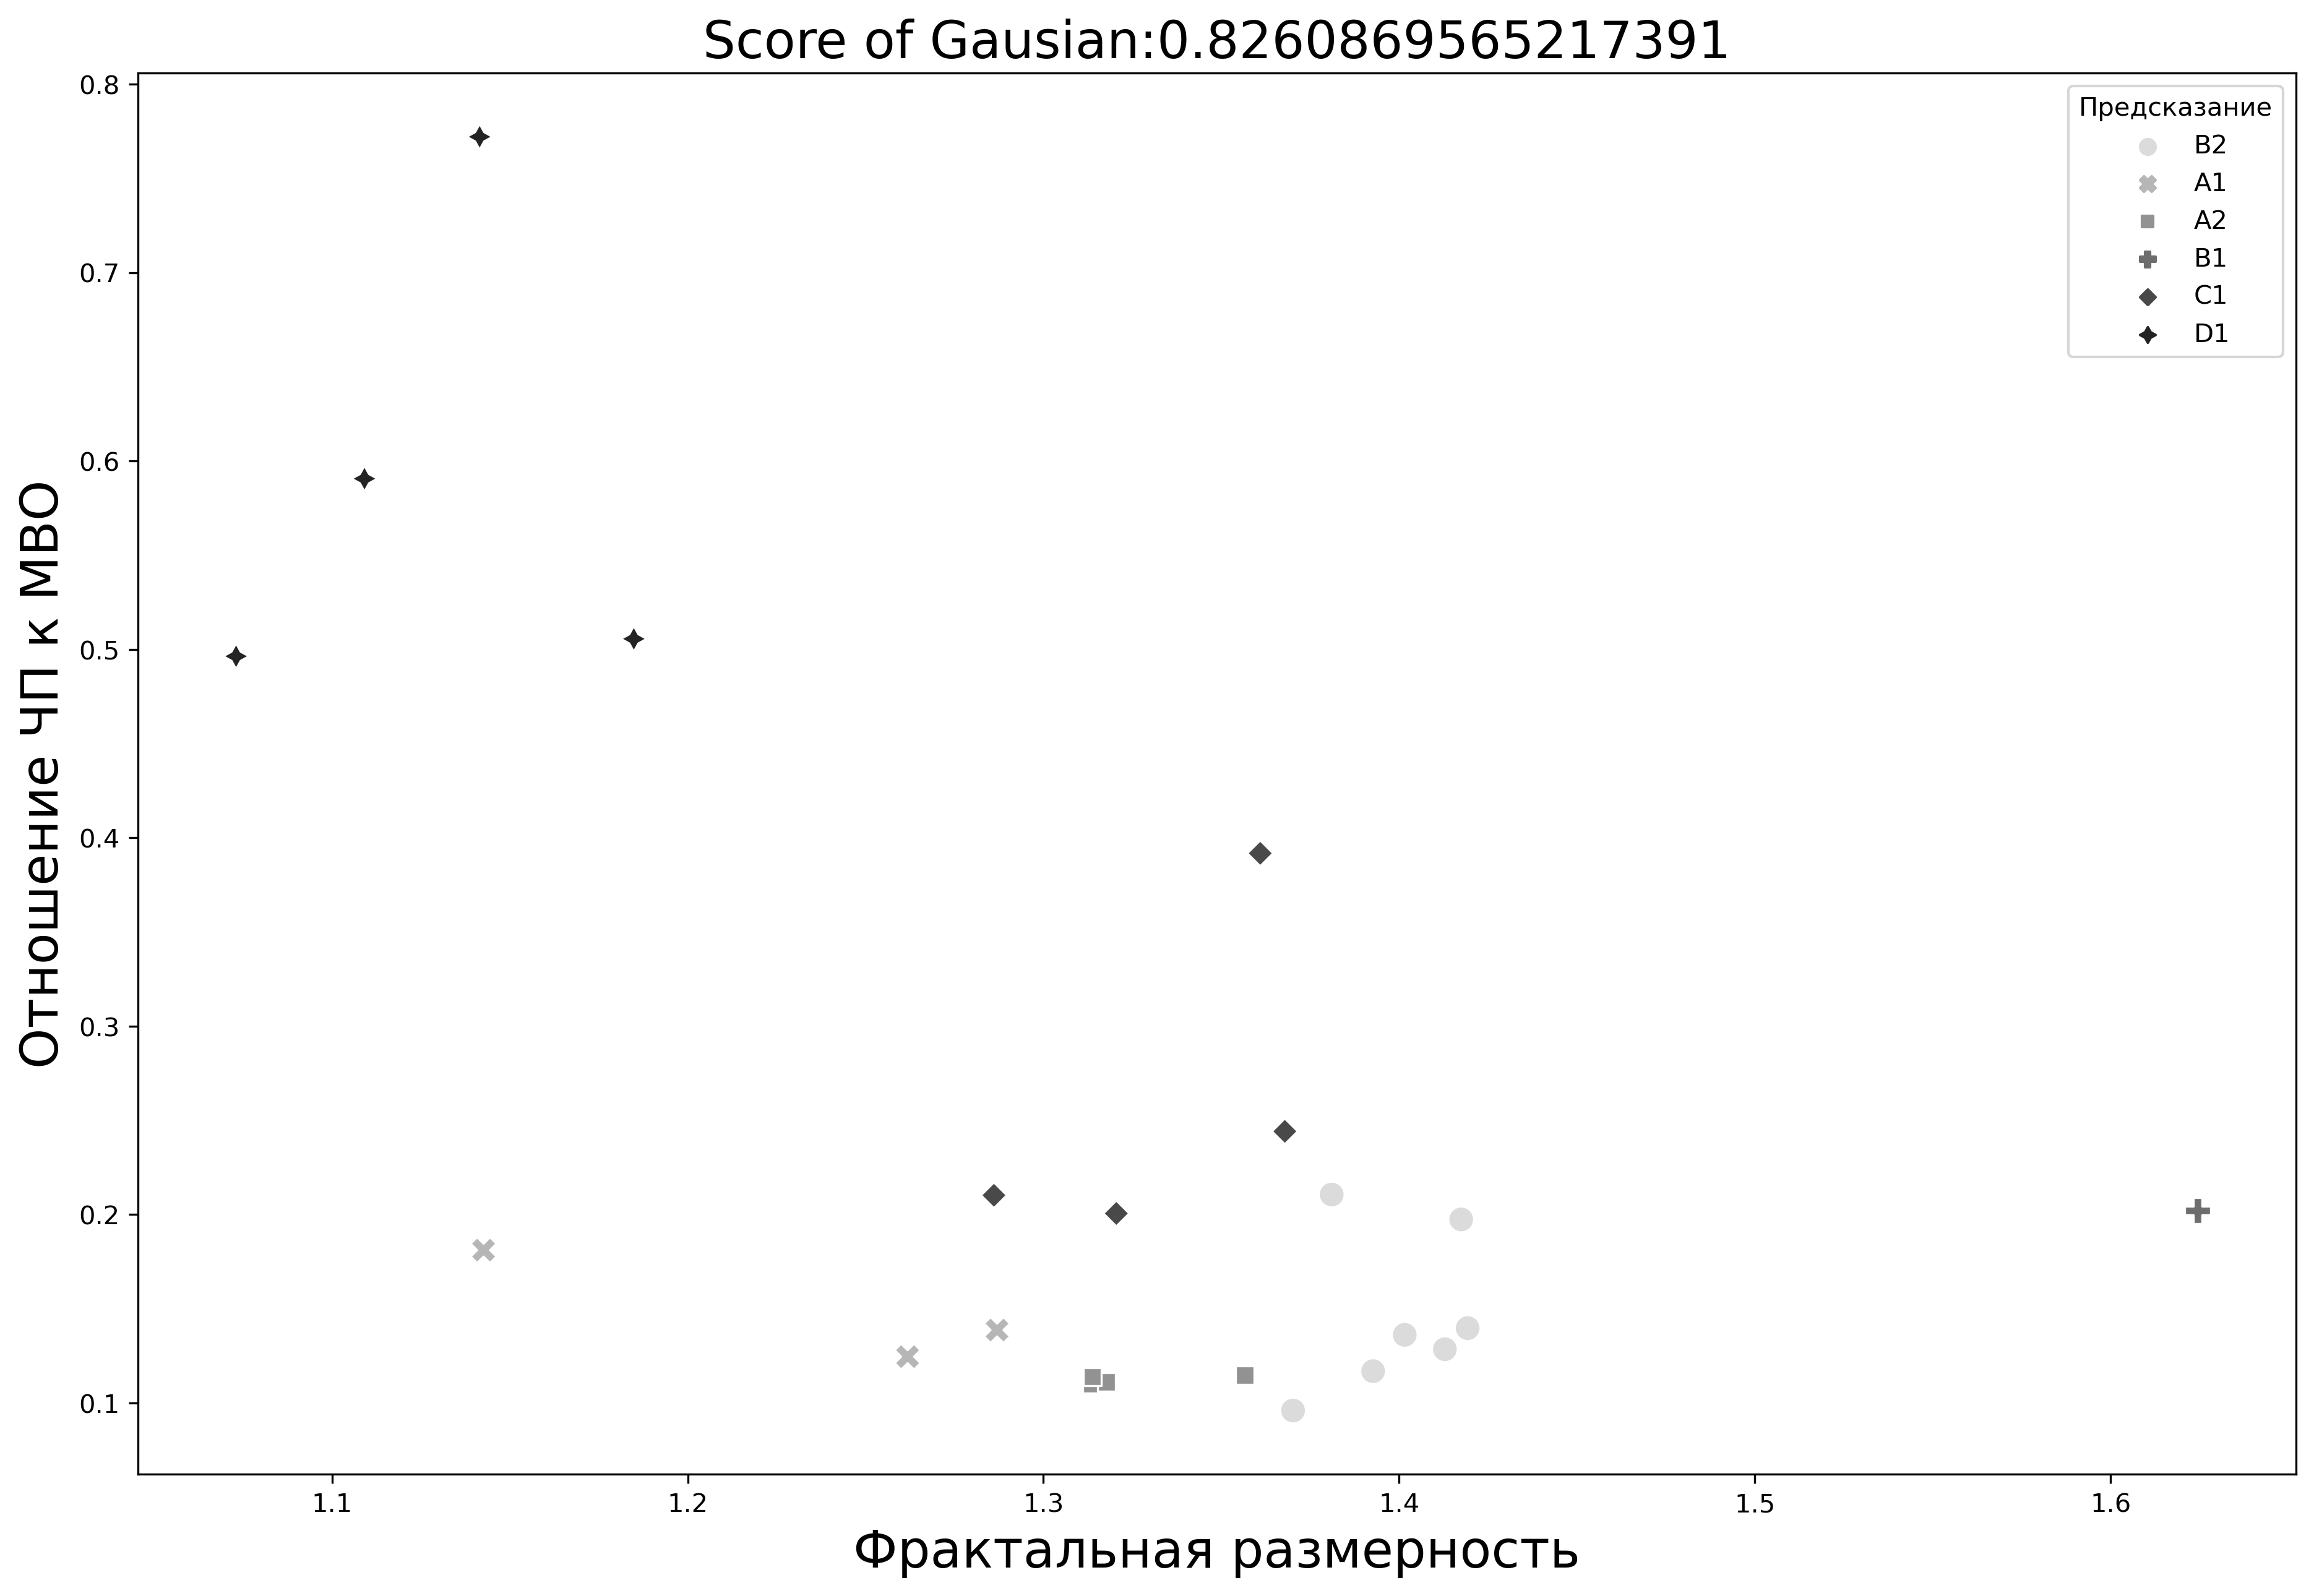

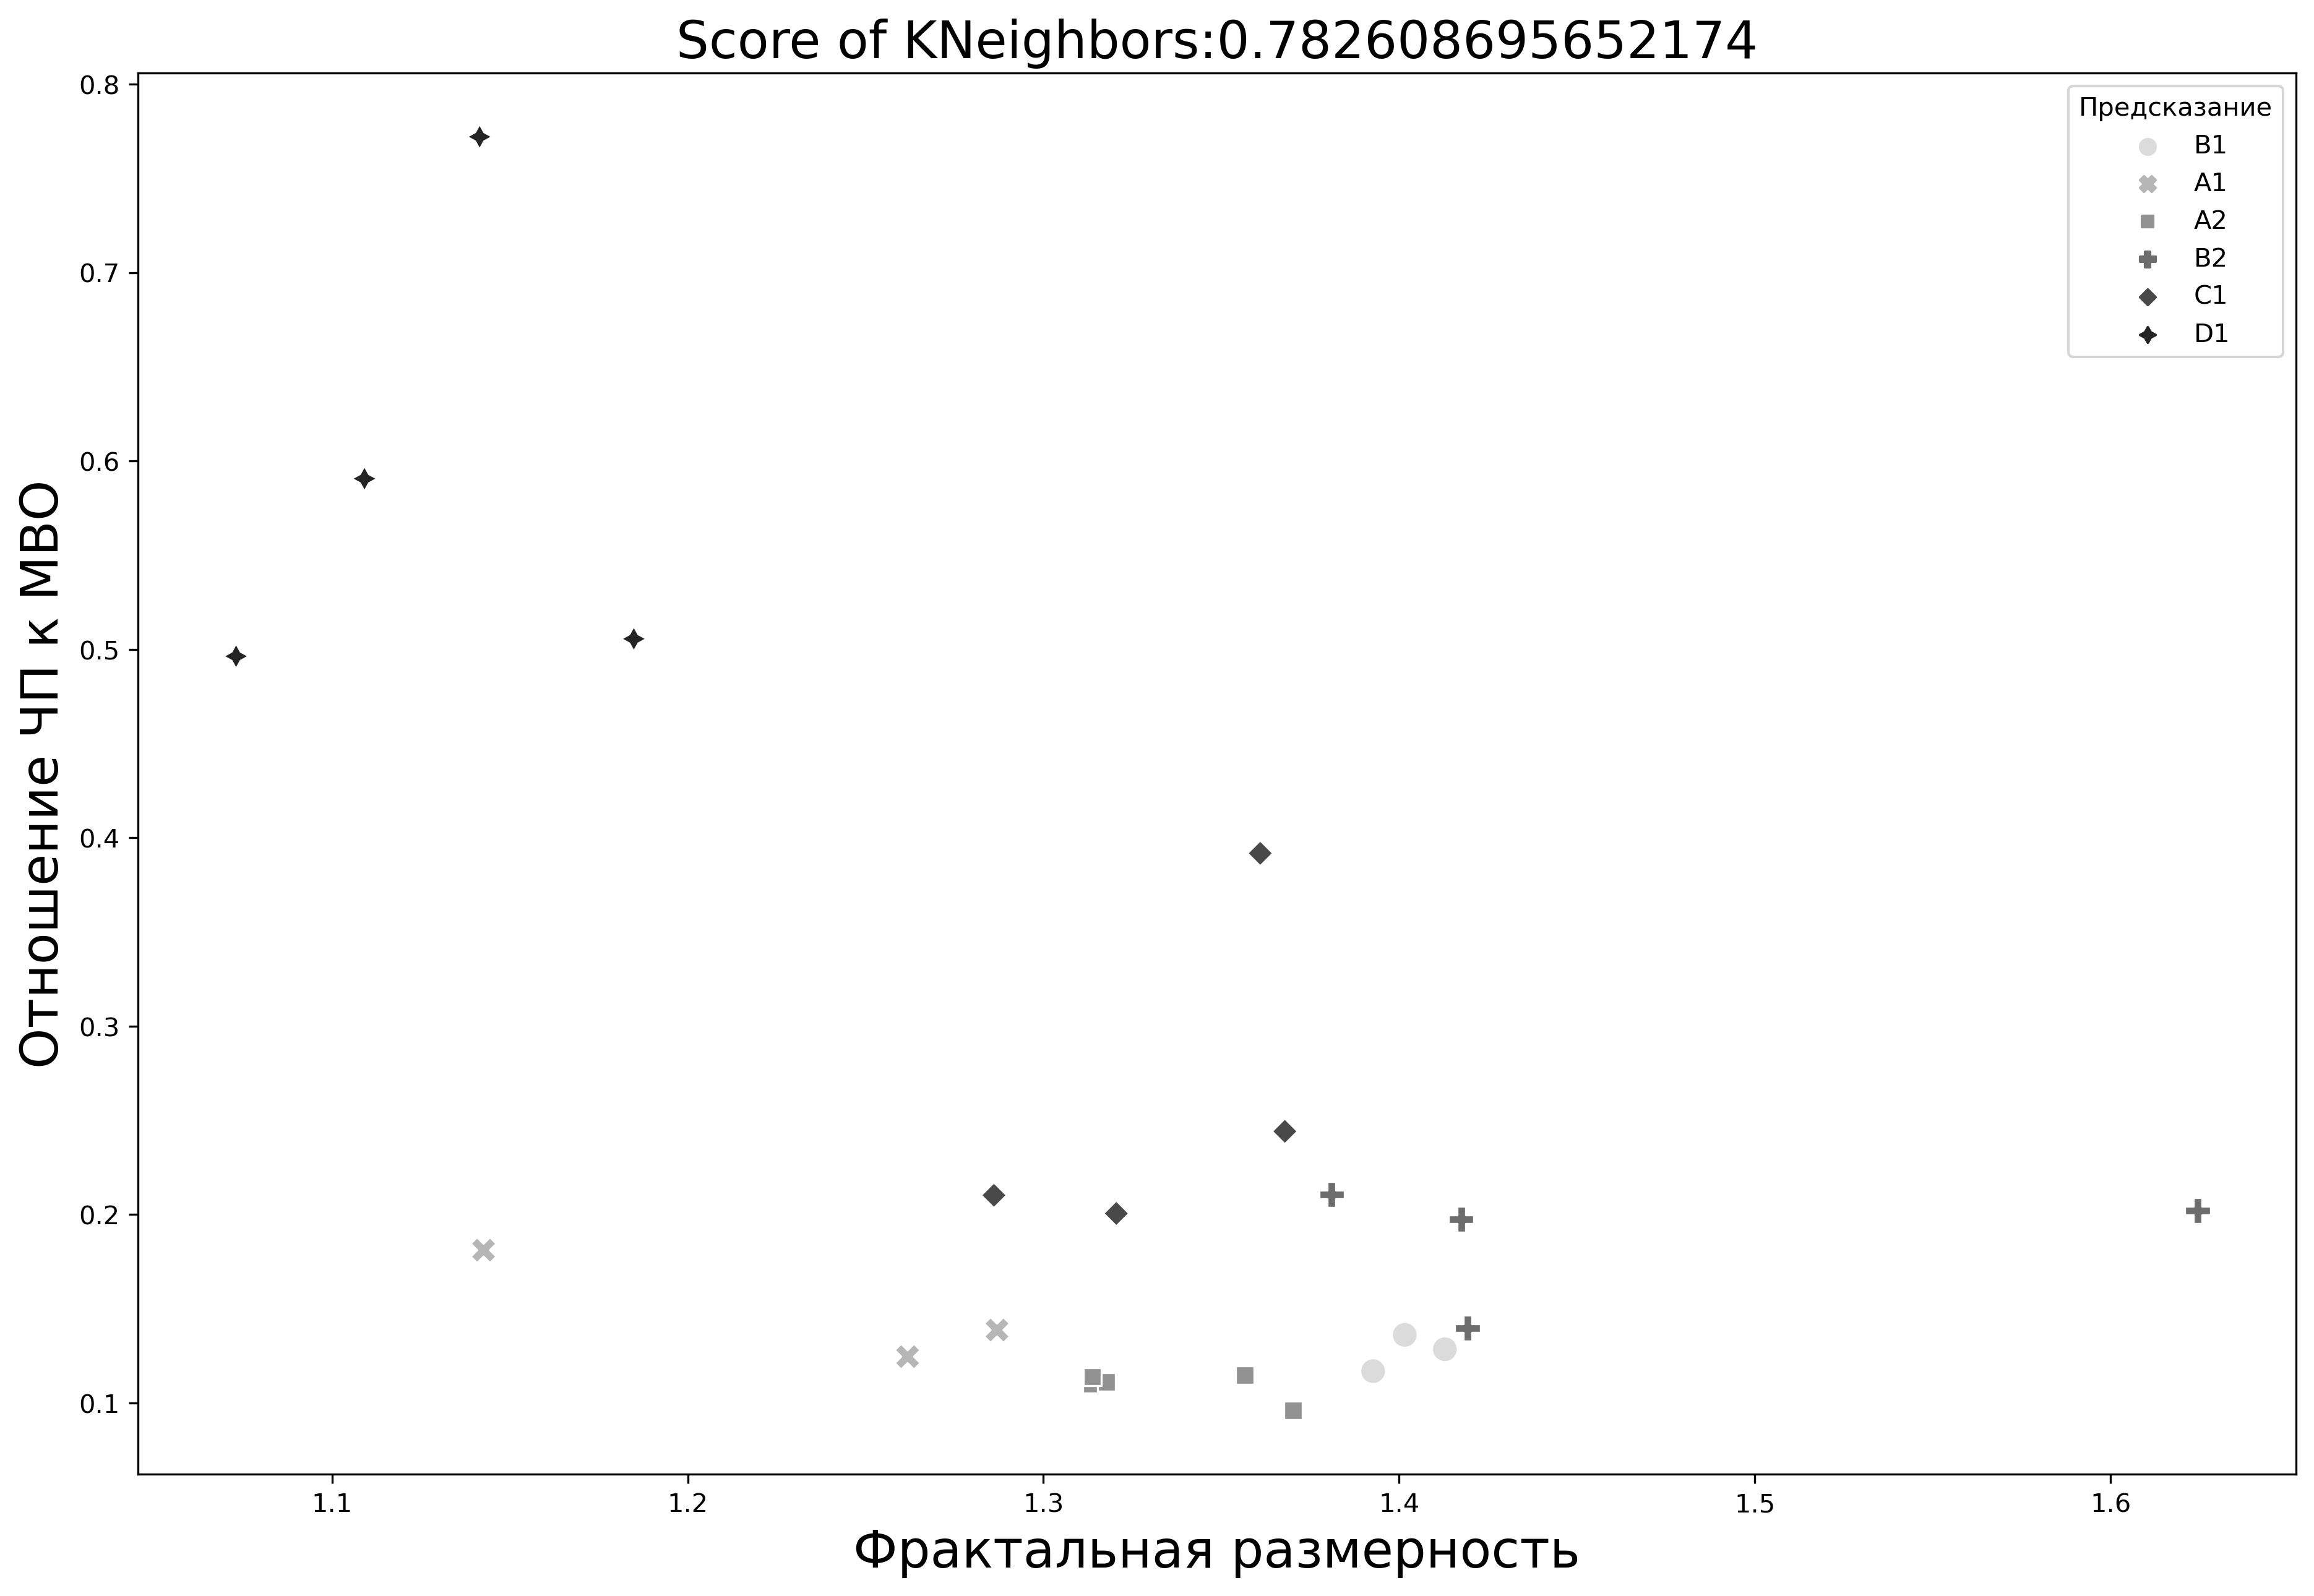

In [38]:
for i, clf in algs().items():
    alg_comparison(data, "Фрактальная размерность","Отношение ЧП к МВО", i, clf)    

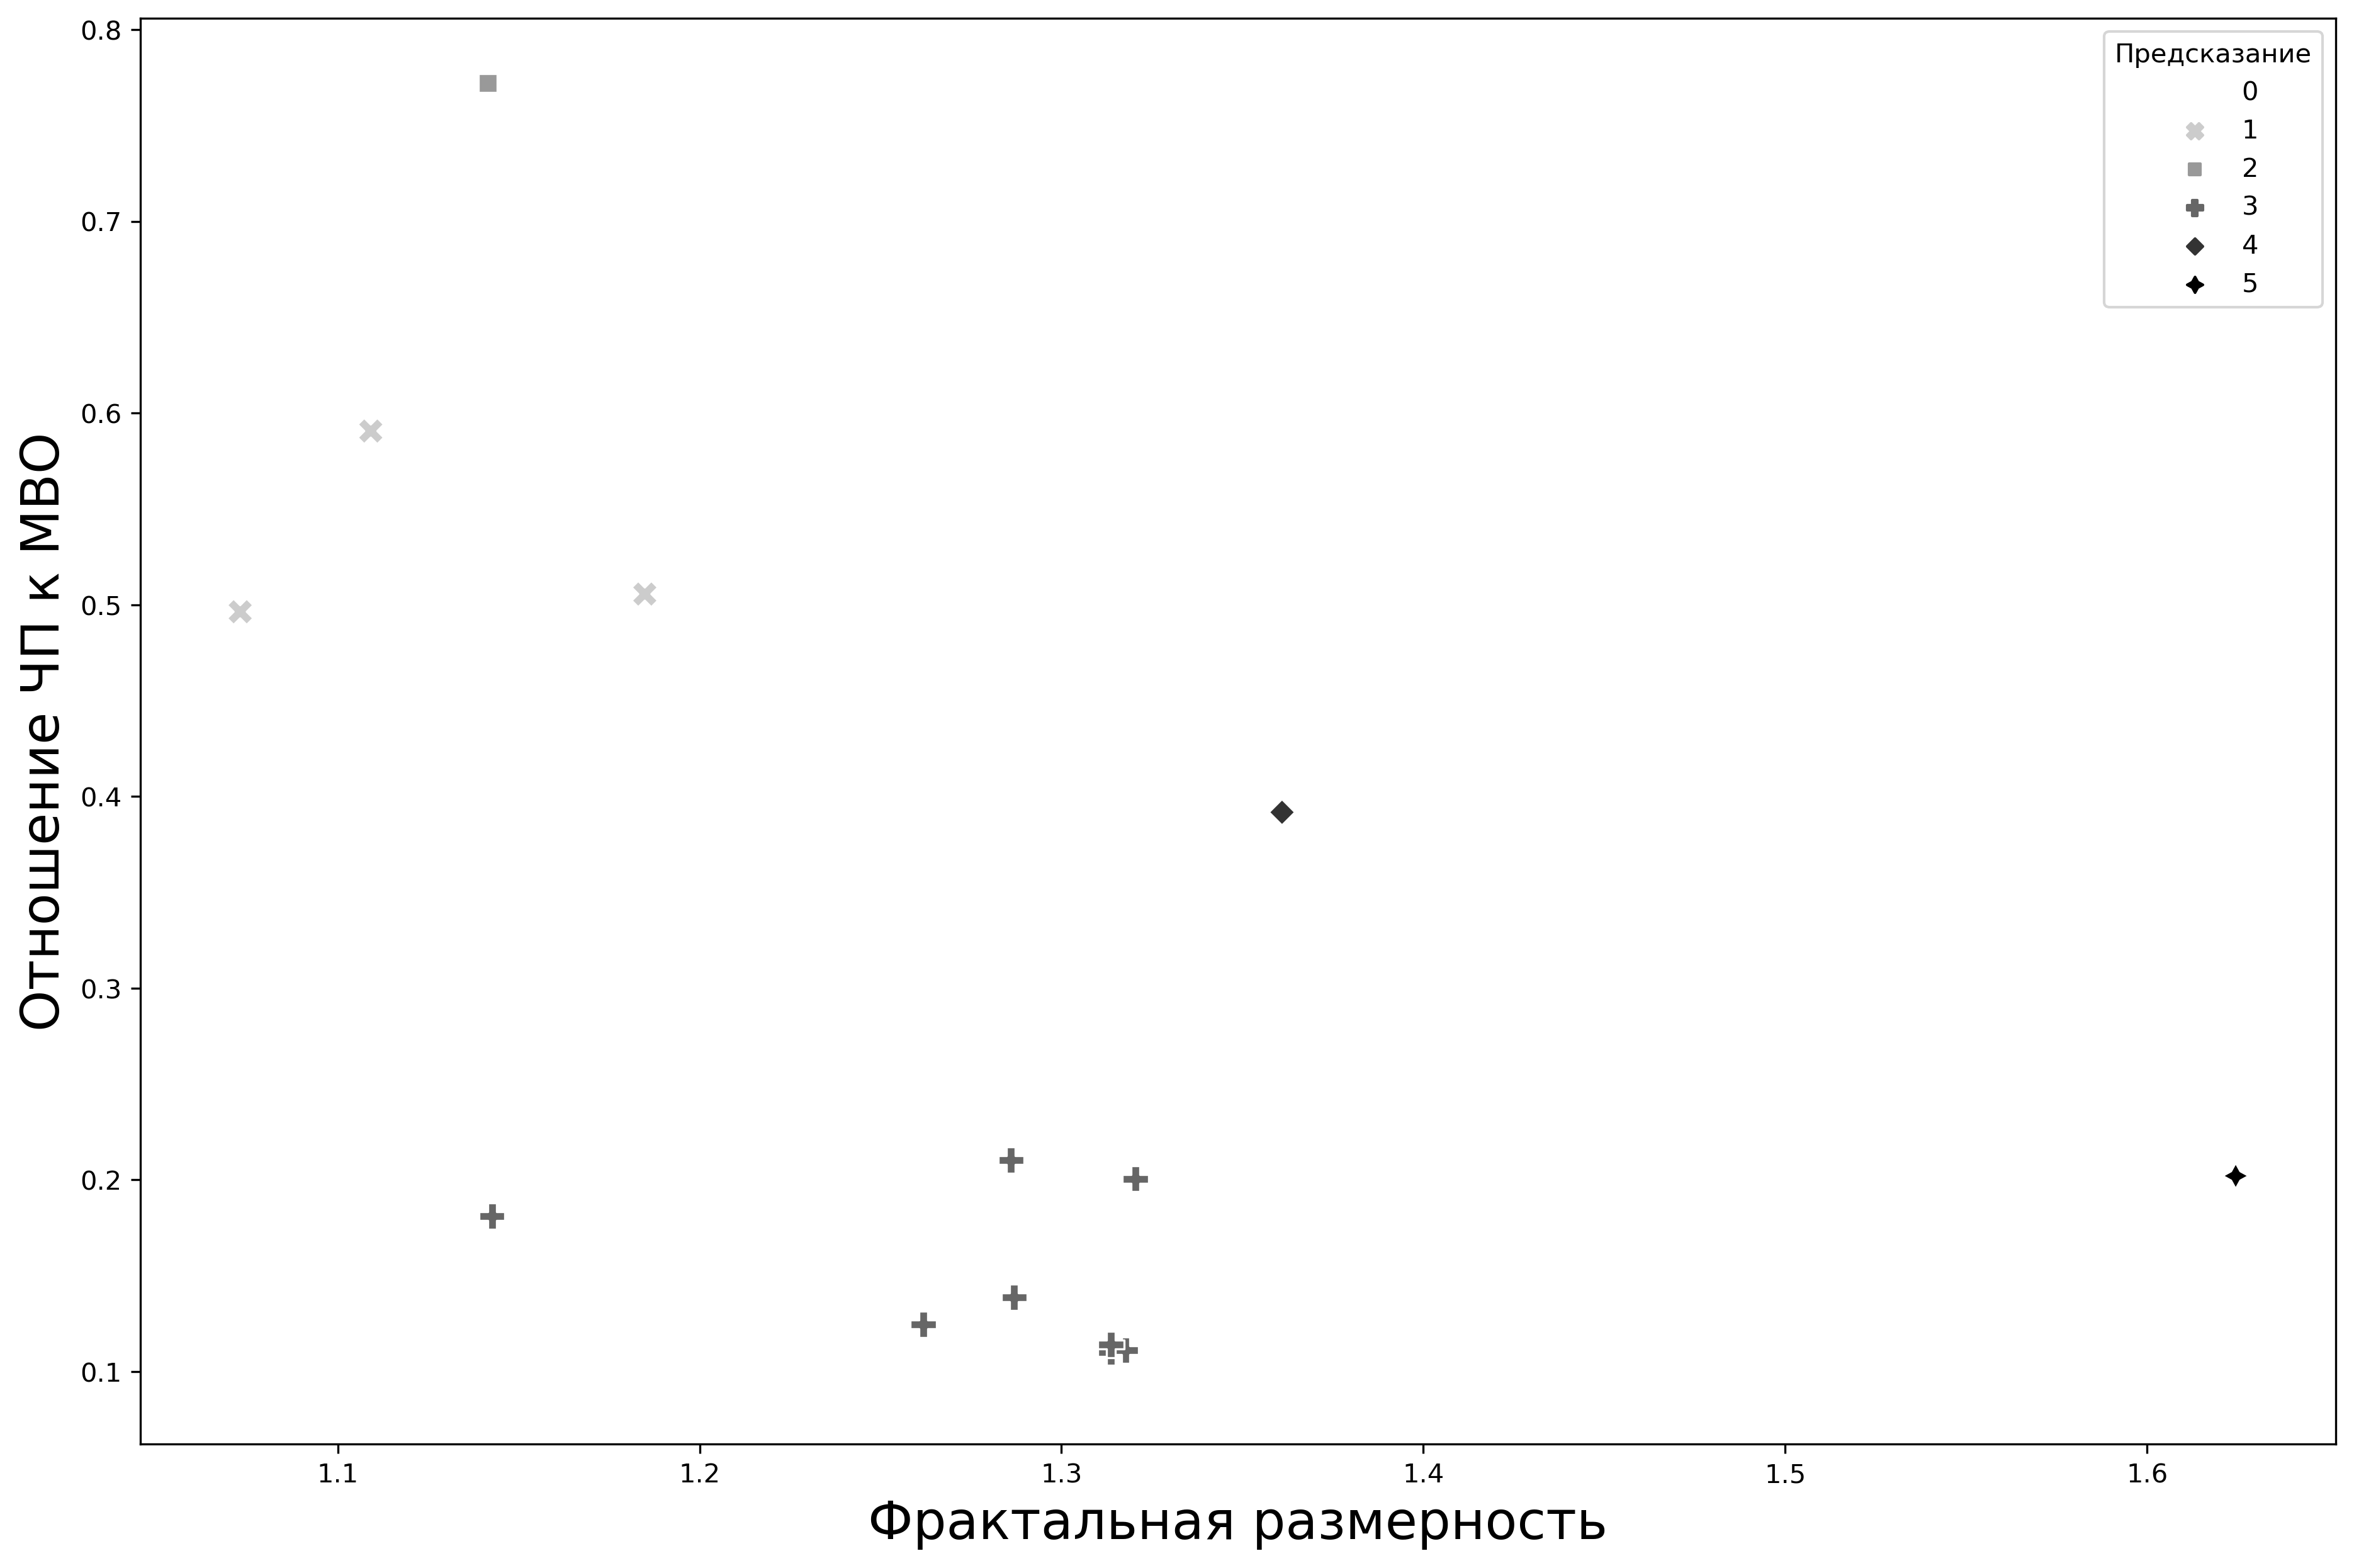

In [39]:
kmeans_vis(data, "Фрактальная размерность","Отношение ЧП к МВО")